# BINet : a binary inpainting network for patch-based image compression

## Overview

The Binary Inpainting Network (BINet) is an autoencoder framework
which incorporates learned binary inpainting in its decoder to reinstate interdependencies between adjacent
independently encoded image patches, for improved patch-based compression of still images.

<img src="files/model_diag/binet.png">

**Imports**

In [1]:
import os
import torch
%matplotlib inline
import evaluate as ev
import subprocess as sub
from img_tools import EvaluationImageDataLoaders, TrainImageDataLoaders
from networks import BINetAR, BINetOSR, SINet, MaskedBINet, ConvAR, ConvGRU

**Helper Functions**

In [2]:
"""
Function : run_cmd
    
    runs a python script from within python and prints stdout to screen in real-time
    
    Args:
        cmd (string) : command to run as subprocess
        
    Ref: https://stackoverflow.com/questions/17411966/
"""

def run_cmd(cmd):
    
    # create subprocess
    proc = sub.Popen(cmd, stdout=sub.PIPE, universal_newlines=True)
    
    # read output line for line
    while proc.poll() is None:
        
        opt = proc.stdout.readline()
        print(opt)
    
    # print rest of opt
    print(proc.stdout.read()) 
    
    return    

## Preprocess Data

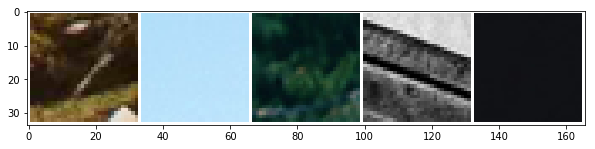

In [4]:
train_img_dl = TrainImageDataLoaders(
    b_s = 5, 
    p_s = 32, 
    root_dir='~/Pictures/Clic/Professional'
)
train_img_dl.display_data('train')

## Baseline Models

### ConvAR

An implementation of the progressive convolutional additive reconstruction (ConvAR) networks proposed in 'Variable Rate Image Compression' by G. Toderici et al. (https://arxiv.org/pdf/1511.06085.pdf) and 
'Learning to Inpaint' by M. Baig et al (https://arxiv.org/pdf/1709.08855.pdf).

<img src="files/model_diag/conv_ar.png">

**Train Model**

In [3]:
# train script cmd
cmd = [
    'python'      , 'train.py',
    '--sys'       , 'Conv',
    '--epochs'    , '15000',
    '--learn_rate', '0.0001',
    '--gamma'     , '0.5',
    '--log'       , './logs/Conv',
    '--trainDir'  , '~/Pictures/Clic/Professional',
    '--save_loc'  , './saved_models/Conv',
    '--patch_size', '32',
    '--batch_size', '32',
    '--itrs'      , '1',
    '--bits'      , '128',
    '--verbose',
    '--checkpoint'
]
# run cmd
run_cmd(cmd)

**Load Trained Model**

In [2]:
# def model
conv_ar = ConvAR(
    itrs = 16, 
    p_s  = 32,
    b_n  = 128
)

# load trained parameters
conv_ar.load_state_dict(torch.load('./saved_models/ConvAR/ConvAR.pt'))

#### Model Results
***Evaluate Model on Validation Data***

In [27]:
# create an evaluation instance
eval_model = ev.EvaluateModel(
    img_dir='~/Pictures/Clic/Professional/valid', 
    model=conv_ar
)

***Compare Validation Patches***

In [5]:
# comp patches
eval_model.compare_patches(
    itrs =  16
)

SSIM : 0.9378880679725832
PSNR : 33.59478305436605


***Validation Image Quality vs Encoder Iterations***

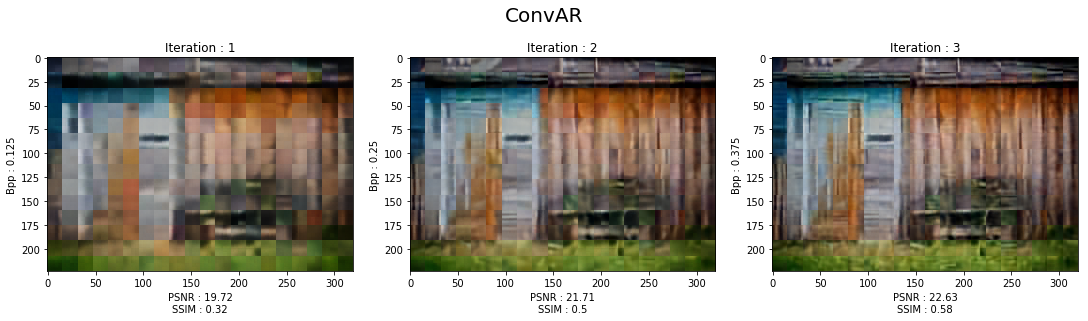

In [7]:
# Display Image Compressions 
eval_model.progressive_imshow(
    itrs=3,
    # widget=True
)

### ConvGRU-OSR

Implementation of Google's convolutional gated recurrent unit one-shot reconstruction (ConvGRU-OSR) image compression system without the entropy coding network. Model proposed in 'Full Resolution Image Compression' by G. Toderici et al (https://arxiv.org/pdf/1608.05148.pdf).

<img src="files/model_diag/conv_gru_osr.png">

**Train Model 16 Iterations**

In [3]:
# train script cmd
cmd = [
    'python'      , 'train.py',
    '--sys'       , 'ConvRNN',
    '--epochs'    , '15000',
    '--learn_rate', '0.0001',
    '--gamma'     , '0.5',
    '--log'       , './logs/ConvRNN',
    '--trainDir'  , '~/Pictures/Clic/Professional',
    '--save_loc'  , './saved_models/ConvRNN',
    '--patch_size', '32',
    '--batch_size', '32',
    '--itrs'      , '16',
    '--bits'      , '128',
    '--verbose',
    '--checkpoint'
]
# run cmd
run_cmd(cmd)

**Load Trained Model**

In [3]:
# define compression system
conv_gru_osr = ConvGRU(
    itrs = 16, 
    p_s  = 32, 
    b_n  = 128,
)

# load model parameters
conv_gru_osr.load_state_dict(
    torch.load('./saved_models/ConvGRU-OSR/ConvGRU-OSR.pt')
)

#### Model Results
**Evaluate Model on Validation Data**

In [3]:
# compare models on validation set
ImgDir = '~/Pictures/Clic/Professional/valid'

# create an eval instance
eval_model = ev.EvaluateModel(
    ImgDir, 
    conv_gru_osr
)

***Compare Evaluation Patches***

In [7]:
# comp patches
eval_model.compare_patches(itrs=16)

SSIM : 0.9597147541897416
PSNR : 36.29356897078114


***Validation Image Quality vs Encoding Iterations***

In [8]:
# Display Image Compressions 
eval_model.progressive_imshow(itrs=3)

# BINet : Binary Inpainting Networks

### Experiments
#### SINet: Sequential Inpainting Network

Learned sequential inpaiting strategy proposed by Baig et al (https://arxiv.org/pdf/1709.08855.pdf).

<img src="files/model_diag/sinet.png">

**Load SINet**

In [2]:
# define SeqNet
sinet = SINet( 
    p_s=32, 
    b_n=128,
    auto_weights="./saved_models/Conv/Conv.pt" 
)

# load model parameters
sinet.load_state_dict(
    torch.load('./saved_models/SeqInpNet/SeqInpNet.pt')
)

**Qualitative Evaluation**

In [3]:
# Evaluation Object
eval_model = ev.EvaluateModel(
    img_dir='~/Pictures/Clic/Professional/valid', 
    model=sinet
)

**SSIM and PSNR for SeqNet Inpainting**

In [7]:
# average Inpainting SSIM
eval_model._average_patch_eval(metric="SSIM", print_stat=True)
eval_model._average_patch_eval(metric="PSNR", print_stat=True)

Average SSIM over 41 Images:
0.4684520491927752
Average PSNR over 41 Images:
19.851634954891967


**Patch Inpaintings**

In [4]:
# display SeqNet patch inpaintings
eval_model.compare_patches()

SSIM : 0.5866443217836578
PSNR : 19.82197582622406


**Artificial Inpainting Test**

In [11]:
# Evaluation Object
eval_model.display_inpainting()

### Masked BINet

**Load Masked BINet**

In [12]:
# define Masked BINet
masked_binet = MaskedBINet( 
    p_s=32, 
    b_n=128
)

# load model parameters
masked_binet.load_state_dict(
    torch.load('./saved_models/MaskedBINet/MaskedBINet.pt')
)

**Qualitative Evaluation**

In [7]:
eval_model = ev.EvaluateModel(
    img_dir='~/Pictures/Clic/Professional/valid', 
    model=masked_binet
)

**SSIM and PSNR for Masked BINet Inpainting**

In [6]:
# average Inpainting SSIM
eval_model._average_patch_eval(metric="SSIM", itrs=1, print_stat=True)
eval_model._average_patch_eval(metric="PSNR", itrs=1, print_stat=True)

Average SSIM over 41 Images:
0.49708882855551856
Average PSNR over 41 Images:
22.075890981764978


**Patch Inpaintings**

SSIM : 0.6140892631603871
PSNR : 20.562894313932677


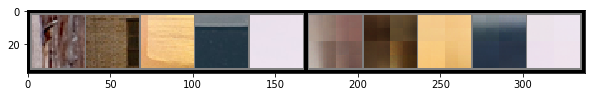

In [9]:
# display Masked BINet patch inpaintings
eval_model.compare_patches()

**Artificial Inpainting Test**

In [14]:
# Display Inpainting
eval_model.display_inpainting()

## BINetAR 

Binary inpainting at first autoencoder iteration of ConvAR.

<img src="files/model_diag/binet_ar.png">

**Train Model 16 Iteration**

In [4]:
# train script cmd
cmd = [
    'python'      , 'train.py',
    '--sys'       , 'BINetAR',
    '--epochs'    , '15000',
    '--learn_rate', '0.0001',
    '--gamma'     , '0.5',
    '--log'       , './logs/BINetAR',
    '--trainDir'  , '~/Pictures/Clic/Professional',
    '--save_loc'  , './saved_models/BINetAR',
    '--patch_size', '32',
    '--batch_size', '32',
    '--itrs'      , '16',
    '--bits'      , '128',
    '--verbose',
    '--checkpoint'
]

# run cmd
run_cmd(cmd)

Training : BINetAR

Continue Training from m.r.c : 

START TRAINING

Epoch 5051/15000

--------------------------------------

Phase: train Loss : 0.043262634132253494

Phase: valid Loss : 0.04919131100177765

Epoch time: 0.24681104024251302 min

-------------------------------------

Epoch 5052/15000

--------------------------------------

Phase: train Loss : 0.04325417448815547

Phase: valid Loss : 0.04243728145956993

Epoch time: 0.30022578636805214 min

-------------------------------------

Epoch 5053/15000

--------------------------------------

Phase: train Loss : 0.04324418600452574

Phase: valid Loss : 0.04635464400053024

Epoch time: 0.29951759974161785 min

-------------------------------------

Epoch 5054/15000

--------------------------------------

Phase: train Loss : 0.0435811129251593

Phase: valid Loss : 0.04659627564251423

Epoch time: 0.30026200612386067 min

-------------------------------------

Epoch 5055/15000

--------------------------------------

Phase: tr

Phase: train Loss : 0.04401506728639728

Phase: valid Loss : 0.04271152801811695

Epoch time: 0.30025832255681356 min

-------------------------------------

Epoch 5090/15000

--------------------------------------

Phase: train Loss : 0.04313576544978117

Phase: valid Loss : 0.0470854677259922

Epoch time: 0.29893919626871746 min

-------------------------------------

Epoch 5091/15000

--------------------------------------

Phase: train Loss : 0.04327735853822608

Phase: valid Loss : 0.04183661751449108

Epoch time: 0.29668364524841306 min

-------------------------------------

Epoch 5092/15000

--------------------------------------

Phase: train Loss : 0.0432685423446329

Phase: valid Loss : 0.05096549354493618

Epoch time: 0.3029084245363871 min

-------------------------------------

Epoch 5093/15000

--------------------------------------

Phase: train Loss : 0.04363389470075306

Phase: valid Loss : 0.041749607771635056

Epoch time: 0.24566134214401245 min

-------------------

Phase: train Loss : 0.04325068957711521

Phase: valid Loss : 0.04536416195333004

Epoch time: 0.25608567396799725 min

-------------------------------------

Epoch 5128/15000

--------------------------------------

Phase: train Loss : 0.04090228951291034

Phase: valid Loss : 0.04975070245563984

Epoch time: 0.2824384768803914 min

-------------------------------------

Epoch 5129/15000

--------------------------------------

Phase: train Loss : 0.04082129434927514

Phase: valid Loss : 0.04847879149019718

Epoch time: 0.24528472820917765 min

-------------------------------------

Epoch 5130/15000

--------------------------------------

Phase: train Loss : 0.04598551694499819

Phase: valid Loss : 0.04340672865509987

Epoch time: 0.2959225018819173 min

-------------------------------------

Epoch 5131/15000

--------------------------------------

Phase: train Loss : 0.041921102686932214

Phase: valid Loss : 0.04510139673948288

Epoch time: 0.2968998948733012 min

-------------------

Phase: train Loss : 0.042729348140327555

Phase: valid Loss : 0.04091008007526398

Epoch time: 0.3003744045893351 min

-------------------------------------

Epoch 5166/15000

--------------------------------------

Phase: train Loss : 0.04365666387112517

Phase: valid Loss : 0.045355699956417084

Epoch time: 0.29729524850845335 min

-------------------------------------

Epoch 5167/15000

--------------------------------------

Phase: train Loss : 0.04445640252609002

Phase: valid Loss : 0.04882637597620487

Epoch time: 0.2944547017415365 min

-------------------------------------

Epoch 5168/15000

--------------------------------------

Phase: train Loss : 0.04360853664969143

Phase: valid Loss : 0.045432401821017265

Epoch time: 0.29553151528040567 min

-------------------------------------

Epoch 5169/15000

--------------------------------------

Phase: train Loss : 0.041679358207865766

Phase: valid Loss : 0.044790949672460556

Epoch time: 0.30108076333999634 min

--------------

Phase: train Loss : 0.04727007634937763

Phase: valid Loss : 0.05075680837035179

Epoch time: 0.3020109415054321 min

-------------------------------------

Epoch 5204/15000

--------------------------------------

Phase: train Loss : 0.044419645282783006

Phase: valid Loss : 0.04743228480219841

Epoch time: 0.3034380555152893 min

-------------------------------------

Epoch 5205/15000

--------------------------------------

Phase: train Loss : 0.04186427044241052

Phase: valid Loss : 0.05194983817636967

Epoch time: 0.3012151042620341 min

-------------------------------------

Epoch 5206/15000

--------------------------------------

Phase: train Loss : 0.04330071650053326

Phase: valid Loss : 0.047710148617625237

Epoch time: 0.29669158458709716 min

-------------------------------------

Epoch 5207/15000

--------------------------------------

Phase: train Loss : 0.04423673980330166

Phase: valid Loss : 0.04807666502892971

Epoch time: 0.29540969133377076 min

------------------

Phase: train Loss : 0.043784283885830326

Phase: valid Loss : 0.040906406939029694

Epoch time: 0.23550676107406615 min

-------------------------------------

Epoch 5242/15000

--------------------------------------

Phase: train Loss : 0.04710853786060685

Phase: valid Loss : 0.05003746226429939

Epoch time: 0.3016684571901957 min

-------------------------------------

Epoch 5243/15000

--------------------------------------

Phase: train Loss : 0.044522822295364584

Phase: valid Loss : 0.04578499309718609

Epoch time: 0.30968113740285236 min

-------------------------------------

Epoch 5244/15000

--------------------------------------

Phase: train Loss : 0.04354549542461571

Phase: valid Loss : 0.04586707055568695

Epoch time: 0.2988483746846517 min

-------------------------------------

Epoch 5245/15000

--------------------------------------

Phase: train Loss : 0.04331856044499498

Phase: valid Loss : 0.0446934700012207

Epoch time: 0.3010850787162781 min

------------------

Phase: train Loss : 0.043840220884272925

Phase: valid Loss : 0.04844427481293678

Epoch time: 0.30199174483617147 min

-------------------------------------

Epoch 5280/15000

--------------------------------------

Phase: train Loss : 0.04551174158328458

Phase: valid Loss : 0.05005259998142719

Epoch time: 0.30607885917027794 min

-------------------------------------

Epoch 5281/15000

--------------------------------------

Phase: train Loss : 0.04615861648007443

Phase: valid Loss : 0.04330391250550747

Epoch time: 0.31095014413197836 min

-------------------------------------

Epoch 5282/15000

--------------------------------------

Phase: train Loss : 0.04071536297468763

Phase: valid Loss : 0.049525389447808266

Epoch time: 0.3104827483495077 min

-------------------------------------

Epoch 5283/15000

--------------------------------------

Phase: train Loss : 0.046304383168095035

Phase: valid Loss : 0.04471314139664173

Epoch time: 0.3070817470550537 min

----------------

Phase: train Loss : 0.04520050593112644

Phase: valid Loss : 0.043716197833418846

Epoch time: 0.3053865591684977 min

-------------------------------------

Epoch 5318/15000

--------------------------------------

Phase: train Loss : 0.04342668032959888

Phase: valid Loss : 0.048139847815036774

Epoch time: 0.31057843764623005 min

-------------------------------------

Epoch 5319/15000

--------------------------------------

Phase: train Loss : 0.042943015106414496

Phase: valid Loss : 0.046282898634672165

Epoch time: 0.3103054086367289 min

-------------------------------------

Epoch 5320/15000

--------------------------------------

Phase: train Loss : 0.04323471945367361

Phase: valid Loss : 0.04584294930100441

Epoch time: 0.3079109311103821 min

-------------------------------------

Epoch 5321/15000

--------------------------------------

Phase: train Loss : 0.04103496200159976

Phase: valid Loss : 0.044240739196538925

Epoch time: 0.3071819464365641 min

----------------

Phase: train Loss : 0.04439173540786693

Phase: valid Loss : 0.042914191260933876

Epoch time: 0.31197134256362913 min

-------------------------------------

Epoch 5356/15000

--------------------------------------

Phase: train Loss : 0.046027388031545435

Phase: valid Loss : 0.0394752686843276

Epoch time: 0.2414826512336731 min

-------------------------------------

Epoch 5357/15000

--------------------------------------

Phase: train Loss : 0.04222054083488489

Phase: valid Loss : 0.047076109796762466

Epoch time: 0.317707351843516 min

-------------------------------------

Epoch 5358/15000

--------------------------------------

Phase: train Loss : 0.04297882132232189

Phase: valid Loss : 0.048007743433117867

Epoch time: 0.31120364665985106 min

-------------------------------------

Epoch 5359/15000

--------------------------------------

Phase: train Loss : 0.042386025190353394

Phase: valid Loss : 0.04856549762189388

Epoch time: 0.3167773683865865 min

-----------------

Phase: train Loss : 0.043656558974793085

Phase: valid Loss : 0.04842980578541756

Epoch time: 0.3235580801963806 min

-------------------------------------

Epoch 5394/15000

--------------------------------------

Phase: train Loss : 0.04247020547719378

Phase: valid Loss : 0.04192633926868439

Epoch time: 0.3193905035654704 min

-------------------------------------

Epoch 5395/15000

--------------------------------------

Phase: train Loss : 0.04312033245438024

Phase: valid Loss : 0.040050799027085304

Epoch time: 0.31881622076034544 min

-------------------------------------

Epoch 5396/15000

--------------------------------------

Phase: train Loss : 0.044699080876613916

Phase: valid Loss : 0.048407841473817825

Epoch time: 0.3195358117421468 min

-------------------------------------

Epoch 5397/15000

--------------------------------------

Phase: train Loss : 0.045257774034613056

Phase: valid Loss : 0.04875044338405132

Epoch time: 0.32312912146250405 min

---------------

Phase: train Loss : 0.04660122880810186

Phase: valid Loss : 0.04403510503470898

Epoch time: 0.33506581783294676 min

-------------------------------------

Epoch 5432/15000

--------------------------------------

Phase: train Loss : 0.04469902597759899

Phase: valid Loss : 0.048882775008678436

Epoch time: 0.3258538802464803 min

-------------------------------------

Epoch 5433/15000

--------------------------------------

Phase: train Loss : 0.04621129502591334

Phase: valid Loss : 0.04400681331753731

Epoch time: 0.24092376629511517 min

-------------------------------------

Epoch 5434/15000

--------------------------------------

Phase: train Loss : 0.0436104506646332

Phase: valid Loss : 0.045153239741921425

Epoch time: 0.3251365661621094 min

-------------------------------------

Epoch 5435/15000

--------------------------------------

Phase: train Loss : 0.04280386982779754

Phase: valid Loss : 0.05460592359304428

Epoch time: 0.330044690767924 min

--------------------

Phase: train Loss : 0.04395184783559097

Phase: valid Loss : 0.04780535586178303

Epoch time: 0.3335673014322917 min

-------------------------------------

Epoch 5470/15000

--------------------------------------

Phase: train Loss : 0.045782427254476045

Phase: valid Loss : 0.04587116464972496

Epoch time: 0.33784393866856893 min

-------------------------------------

Epoch 5471/15000

--------------------------------------

Phase: train Loss : 0.04255563628516699

Phase: valid Loss : 0.04519250988960266

Epoch time: 0.33655144770940143 min

-------------------------------------

Epoch 5472/15000

--------------------------------------

Phase: train Loss : 0.04436139811418558

Phase: valid Loss : 0.04119737260043621

Epoch time: 0.3006500164667765 min

-------------------------------------

Epoch 5473/15000

--------------------------------------

Phase: train Loss : 0.04495667901478315

Phase: valid Loss : 0.04707222245633602

Epoch time: 0.24286502202351887 min

------------------

Phase: train Loss : 0.04232093682022471

Phase: valid Loss : 0.04861931502819061

Epoch time: 0.3443762421607971 min

-------------------------------------

Epoch 5508/15000

--------------------------------------

Phase: train Loss : 0.04321900657133052

Phase: valid Loss : 0.04309854470193386

Epoch time: 0.34566707611083985 min

-------------------------------------

Epoch 5509/15000

--------------------------------------

Phase: train Loss : 0.04348404195747877

Phase: valid Loss : 0.047262249514460564

Epoch time: 0.35223026275634767 min

-------------------------------------

Epoch 5510/15000

--------------------------------------

Phase: train Loss : 0.042006281253538634

Phase: valid Loss : 0.04657345823943615

Epoch time: 0.2949280858039856 min

-------------------------------------

Epoch 5511/15000

--------------------------------------

Phase: train Loss : 0.04357809906727389

Phase: valid Loss : 0.042624182999134064

Epoch time: 0.28780996799468994 min

----------------

Phase: train Loss : 0.04406820512131641

Phase: valid Loss : 0.045697275549173355

Epoch time: 0.2791427771250407 min

-------------------------------------

Epoch 5546/15000

--------------------------------------

Phase: train Loss : 0.04541888538944094

Phase: valid Loss : 0.050511738285422325

Epoch time: 0.2871542731920878 min

-------------------------------------

Epoch 5547/15000

--------------------------------------

Phase: train Loss : 0.04186539489187693

Phase: valid Loss : 0.04911583475768566

Epoch time: 0.2824410637219747 min

-------------------------------------

Epoch 5548/15000

--------------------------------------

Phase: train Loss : 0.0422908553951665

Phase: valid Loss : 0.04533199779689312

Epoch time: 0.2848698258399963 min

-------------------------------------

Epoch 5549/15000

--------------------------------------

Phase: train Loss : 0.044535133007325624

Phase: valid Loss : 0.0438531581312418

Epoch time: 0.28482979933420816 min

--------------------

Phase: train Loss : 0.046590941713044516

Phase: valid Loss : 0.043036701157689095

Epoch time: 0.2831134597460429 min

-------------------------------------

Epoch 5584/15000

--------------------------------------

Phase: train Loss : 0.044931367725918166

Phase: valid Loss : 0.04639383964240551

Epoch time: 0.2863369981447856 min

-------------------------------------

Epoch 5585/15000

--------------------------------------

Phase: train Loss : 0.042310419443406556

Phase: valid Loss : 0.047233015298843384

Epoch time: 0.2893806219100952 min

-------------------------------------

Epoch 5586/15000

--------------------------------------

Phase: train Loss : 0.04273204632887715

Phase: valid Loss : 0.048902031034231186

Epoch time: 0.28738866647084554 min

-------------------------------------

Epoch 5587/15000

--------------------------------------

Phase: train Loss : 0.04341395846322963

Phase: valid Loss : 0.04951796866953373

Epoch time: 0.23616180419921876 min

--------------

Phase: train Loss : 0.04261803587800578

Phase: valid Loss : 0.04888751916587353

Epoch time: 0.28360524972279866 min

-------------------------------------

Epoch 5622/15000

--------------------------------------

Phase: train Loss : 0.041281590336247495

Phase: valid Loss : 0.04845070652663708

Epoch time: 0.2390931765238444 min

-------------------------------------

Epoch 5623/15000

--------------------------------------

Phase: train Loss : 0.04095102434879855

Phase: valid Loss : 0.044518543407320976

Epoch time: 0.23760536511739094 min

-------------------------------------

Epoch 5624/15000

--------------------------------------

Phase: train Loss : 0.043840363033508

Phase: valid Loss : 0.04931580275297165

Epoch time: 0.28305187622706096 min

-------------------------------------

Epoch 5625/15000

--------------------------------------

Phase: train Loss : 0.04318768080127867

Phase: valid Loss : 0.04130597785115242

Epoch time: 0.28371938069661456 min

------------------

Phase: train Loss : 0.041810528424225356

Phase: valid Loss : 0.04311631992459297

Epoch time: 0.28579508463541664 min

-------------------------------------

Epoch 5660/15000

--------------------------------------

Phase: train Loss : 0.03929256069424905

Phase: valid Loss : 0.045136332511901855

Epoch time: 0.2740237315495809 min

-------------------------------------

Epoch 5661/15000

--------------------------------------

Phase: train Loss : 0.04158721707369152

Phase: valid Loss : 0.04368753544986248

Epoch time: 0.2452661156654358 min

-------------------------------------

Epoch 5662/15000

--------------------------------------

Phase: train Loss : 0.03992263815904919

Phase: valid Loss : 0.04775732941925526

Epoch time: 0.28329607248306277 min

-------------------------------------

Epoch 5663/15000

--------------------------------------

Phase: train Loss : 0.040359735390857646

Phase: valid Loss : 0.04173321835696697

Epoch time: 0.2779412468274434 min

-----------------

Phase: train Loss : 0.04353585868681732

Phase: valid Loss : 0.04836365021765232

Epoch time: 0.28935985962549843 min

-------------------------------------

Epoch 5698/15000

--------------------------------------

Phase: train Loss : 0.041014447023994045

Phase: valid Loss : 0.046389566734433174

Epoch time: 0.24022707144419353 min

-------------------------------------

Epoch 5699/15000

--------------------------------------

Phase: train Loss : 0.04490417849860693

Phase: valid Loss : 0.05213962681591511

Epoch time: 0.28172433376312256 min

-------------------------------------

Epoch 5700/15000

--------------------------------------

Phase: train Loss : 0.041820569846190904

Phase: valid Loss : 0.04310771822929382

Epoch time: 0.2854070027669271 min

-------------------------------------

Epoch 5701/15000

--------------------------------------

Phase: train Loss : 0.04231560494946806

Phase: valid Loss : 0.05114872567355633

Epoch time: 0.2791950345039368 min

----------------

Phase: train Loss : 0.04215619820905359

Phase: valid Loss : 0.04411126673221588

Epoch time: 0.28490309715270995 min

-------------------------------------

Epoch 5736/15000

--------------------------------------

Phase: train Loss : 0.04266396164894104

Phase: valid Loss : 0.04831981472671032

Epoch time: 0.28696444431940715 min

-------------------------------------

Epoch 5737/15000

--------------------------------------

Phase: train Loss : 0.04420926265026394

Phase: valid Loss : 0.04497186280786991

Epoch time: 0.28584272861480714 min

-------------------------------------

Epoch 5738/15000

--------------------------------------

Phase: train Loss : 0.04540792401683958

Phase: valid Loss : 0.04740533232688904

Epoch time: 0.2851002057393392 min

-------------------------------------

Epoch 5739/15000

--------------------------------------

Phase: train Loss : 0.044119632753886674

Phase: valid Loss : 0.04535364359617233

Epoch time: 0.29388248523076377 min

-----------------

Phase: train Loss : 0.04159204387351086

Phase: valid Loss : 0.04775840975344181

Epoch time: 0.24581630229949952 min

-------------------------------------

Epoch 5774/15000

--------------------------------------

Phase: train Loss : 0.04284955070991265

Phase: valid Loss : 0.04157918132841587

Epoch time: 0.27497901519139606 min

-------------------------------------

Epoch 5775/15000

--------------------------------------

Phase: train Loss : 0.04412814484615075

Phase: valid Loss : 0.05284120701253414

Epoch time: 0.2866091251373291 min

-------------------------------------

Epoch 5776/15000

--------------------------------------

Phase: train Loss : 0.0415181739157752

Phase: valid Loss : 0.04390103183686733

Epoch time: 0.23823740879694622 min

-------------------------------------

Epoch 5777/15000

--------------------------------------

Phase: train Loss : 0.042752514348218314

Phase: valid Loss : 0.04867425560951233

Epoch time: 0.2852278590202332 min

-------------------

Phase: train Loss : 0.04433510942678703

Phase: valid Loss : 0.04168224707245827

Epoch time: 0.29111465215682986 min

-------------------------------------

Epoch 5812/15000

--------------------------------------

Phase: train Loss : 0.044902285658999494

Phase: valid Loss : 0.04711947962641716

Epoch time: 0.2854335824648539 min

-------------------------------------

Epoch 5813/15000

--------------------------------------

Phase: train Loss : 0.038784740394667575

Phase: valid Loss : 0.05243368446826935

Epoch time: 0.24544384876887004 min

-------------------------------------

Epoch 5814/15000

--------------------------------------

Phase: train Loss : 0.04631051342738302

Phase: valid Loss : 0.045849427580833435

Epoch time: 0.2844544529914856 min

-------------------------------------

Epoch 5815/15000

--------------------------------------

Phase: train Loss : 0.043458838800066395

Phase: valid Loss : 0.04525214806199074

Epoch time: 0.28811033964157107 min

---------------

Phase: train Loss : 0.040611733045232926

Phase: valid Loss : 0.045516468584537506

Epoch time: 0.29246110916137696 min

-------------------------------------

Epoch 5850/15000

--------------------------------------

Phase: train Loss : 0.04301548523730353

Phase: valid Loss : 0.04794127494096756

Epoch time: 0.2892462650934855 min

-------------------------------------

Epoch 5851/15000

--------------------------------------

Phase: train Loss : 0.04360143859919749

Phase: valid Loss : 0.04314689338207245

Epoch time: 0.2866502086321513 min

-------------------------------------

Epoch 5852/15000

--------------------------------------

Phase: train Loss : 0.04403408920686496

Phase: valid Loss : 0.04802381247282028

Epoch time: 0.28397701581319174 min

-------------------------------------

Epoch 5853/15000

--------------------------------------

Phase: train Loss : 0.043356596247146

Phase: valid Loss : 0.042406534776091576

Epoch time: 0.23971632719039918 min

------------------

Phase: train Loss : 0.04256748937462505

Phase: valid Loss : 0.04267479106783867

Epoch time: 0.23550727764765422 min

-------------------------------------

Epoch 5888/15000

--------------------------------------

Phase: train Loss : 0.04373058647309479

Phase: valid Loss : 0.04131956025958061

Epoch time: 0.294425090154012 min

-------------------------------------

Epoch 5889/15000

--------------------------------------

Phase: train Loss : 0.04425617709363762

Phase: valid Loss : 0.03875782433897257

Epoch time: 0.2890980005264282 min

-------------------------------------

Epoch 5890/15000

--------------------------------------

Phase: train Loss : 0.04286154555646997

Phase: valid Loss : 0.04588424041867256

Epoch time: 0.29135387738545737 min

-------------------------------------

Epoch 5891/15000

--------------------------------------

Phase: train Loss : 0.043104214691802076

Phase: valid Loss : 0.05011795833706856

Epoch time: 0.2809560298919678 min

--------------------

Phase: train Loss : 0.042790435450641734

Phase: valid Loss : 0.04022644180804491

Epoch time: 0.24252637227376303 min

-------------------------------------

Epoch 5926/15000

--------------------------------------

Phase: train Loss : 0.04207410467298407

Phase: valid Loss : 0.04119184613227844

Epoch time: 0.2825557072957357 min

-------------------------------------

Epoch 5927/15000

--------------------------------------

Phase: train Loss : 0.04440170565718099

Phase: valid Loss : 0.04721534065902233

Epoch time: 0.28614521423975625 min

-------------------------------------

Epoch 5928/15000

--------------------------------------

Phase: train Loss : 0.04400908211736303

Phase: valid Loss : 0.047461094334721565

Epoch time: 0.28121313254038494 min

-------------------------------------

Epoch 5929/15000

--------------------------------------

Phase: train Loss : 0.044182912691643365

Phase: valid Loss : 0.04815453663468361

Epoch time: 0.28430023590723674 min

---------------

Phase: train Loss : 0.0447847749057569

Phase: valid Loss : 0.045702073723077774

Epoch time: 0.28006699482599895 min

-------------------------------------

Epoch 5964/15000

--------------------------------------

Phase: train Loss : 0.044345146339190636

Phase: valid Loss : 0.048367761075496674

Epoch time: 0.24147748549779255 min

-------------------------------------

Epoch 5965/15000

--------------------------------------

Phase: train Loss : 0.04457437913668783

Phase: valid Loss : 0.04479067400097847

Epoch time: 0.2817804495493571 min

-------------------------------------

Epoch 5966/15000

--------------------------------------

Phase: train Loss : 0.04123243366024996

Phase: valid Loss : 0.0493512824177742

Epoch time: 0.2806418061256409 min

-------------------------------------

Epoch 5967/15000

--------------------------------------

Phase: train Loss : 0.04557734443561027

Phase: valid Loss : 0.04876812361180782

Epoch time: 0.2818689743677775 min

-------------------

Phase: train Loss : 0.04356379208988265

Phase: valid Loss : 0.04684620909392834

Epoch time: 0.28191208839416504 min

-------------------------------------

Epoch 6002/15000

--------------------------------------

Phase: train Loss : 0.04409428999612206

Phase: valid Loss : 0.04399816691875458

Epoch time: 0.2856346805890401 min

-------------------------------------

Epoch 6003/15000

--------------------------------------

Phase: train Loss : 0.042412322014570236

Phase: valid Loss : 0.04020385816693306

Epoch time: 0.28707058827082316 min

-------------------------------------

Epoch 6004/15000

--------------------------------------

Phase: train Loss : 0.04356152721141514

Phase: valid Loss : 0.03967745043337345

Epoch time: 0.2831664244333903 min

-------------------------------------

Epoch 6005/15000

--------------------------------------

Phase: train Loss : 0.04057527353104792

Phase: valid Loss : 0.0409066341817379

Epoch time: 0.28389654954274496 min

-------------------

Phase: train Loss : 0.044411715904348774

Phase: valid Loss : 0.04640310816466808

Epoch time: 0.28665926853815715 min

-------------------------------------

Epoch 6040/15000

--------------------------------------

Phase: train Loss : 0.043312211373918934

Phase: valid Loss : 0.04586613364517689

Epoch time: 0.28810689846674603 min

-------------------------------------

Epoch 6041/15000

--------------------------------------

Phase: train Loss : 0.04412949683242723

Phase: valid Loss : 0.045758284628391266

Epoch time: 0.28152127265930177 min

-------------------------------------

Epoch 6042/15000

--------------------------------------

Phase: train Loss : 0.043762426333207836

Phase: valid Loss : 0.04583991318941116

Epoch time: 0.28425051768620807 min

-------------------------------------

Epoch 6043/15000

--------------------------------------

Phase: train Loss : 0.04217759274730557

Phase: valid Loss : 0.041546786203980446

Epoch time: 0.24468158880869548 min

------------

Phase: train Loss : 0.04312947559121408

Phase: valid Loss : 0.04417182505130768

Epoch time: 0.27995579640070595 min

-------------------------------------

Epoch 6078/15000

--------------------------------------

Phase: train Loss : 0.042177656861512286

Phase: valid Loss : 0.04263470135629177

Epoch time: 0.28208556572596233 min

-------------------------------------

Epoch 6079/15000

--------------------------------------

Phase: train Loss : 0.04472689232543895

Phase: valid Loss : 0.04547243192791939

Epoch time: 0.28741348584493004 min

-------------------------------------

Epoch 6080/15000

--------------------------------------

Phase: train Loss : 0.044016993947719275

Phase: valid Loss : 0.047175707295536995

Epoch time: 0.28590739965438844 min

-------------------------------------

Epoch 6081/15000

--------------------------------------

Phase: train Loss : 0.04477598224031298

Phase: valid Loss : 0.049003878608345985

Epoch time: 0.2799491882324219 min

--------------

Phase: train Loss : 0.04430562512655007

Phase: valid Loss : 0.04588034190237522

Epoch time: 0.2932945410410563 min

-------------------------------------

Epoch 6116/15000

--------------------------------------

Phase: train Loss : 0.04356554836819047

Phase: valid Loss : 0.049111317843198776

Epoch time: 0.28784536123275756 min

-------------------------------------

Epoch 6117/15000

--------------------------------------

Phase: train Loss : 0.043549713531607075

Phase: valid Loss : 0.04357442818582058

Epoch time: 0.2862510601679484 min

-------------------------------------

Epoch 6118/15000

--------------------------------------

Phase: train Loss : 0.04342110651104074

Phase: valid Loss : 0.04370505176484585

Epoch time: 0.29072629610697426 min

-------------------------------------

Epoch 6119/15000

--------------------------------------

Phase: train Loss : 0.04267774394860393

Phase: valid Loss : 0.05480855517089367

Epoch time: 0.2919490456581116 min

------------------

Phase: train Loss : 0.044487097545673975

Phase: valid Loss : 0.04645126685500145

Epoch time: 0.2910767833391825 min

-------------------------------------

Epoch 6154/15000

--------------------------------------

Phase: train Loss : 0.04173784575572139

Phase: valid Loss : 0.03989330306649208

Epoch time: 0.2853561878204346 min

-------------------------------------

Epoch 6155/15000

--------------------------------------

Phase: train Loss : 0.04320411031183444

Phase: valid Loss : 0.04475981369614601

Epoch time: 0.2842253883679708 min

-------------------------------------

Epoch 6156/15000

--------------------------------------

Phase: train Loss : 0.04255688210066996

Phase: valid Loss : 0.039364502765238285

Epoch time: 0.2843886613845825 min

-------------------------------------

Epoch 6157/15000

--------------------------------------

Phase: train Loss : 0.04146487755995048

Phase: valid Loss : 0.04391161911189556

Epoch time: 0.2917468508084615 min

--------------------

Phase: train Loss : 0.045631886508904006

Phase: valid Loss : 0.04693811945617199

Epoch time: 0.24633229573567708 min

-------------------------------------

Epoch 6192/15000

--------------------------------------

Phase: train Loss : 0.04572563363533271

Phase: valid Loss : 0.04613012634217739

Epoch time: 0.28717296520868935 min

-------------------------------------

Epoch 6193/15000

--------------------------------------

Phase: train Loss : 0.04172876163532859

Phase: valid Loss : 0.04656483791768551

Epoch time: 0.2471556544303894 min

-------------------------------------

Epoch 6194/15000

--------------------------------------

Phase: train Loss : 0.04204138182103634

Phase: valid Loss : 0.0442307461053133

Epoch time: 0.2845428983370463 min

-------------------------------------

Epoch 6195/15000

--------------------------------------

Phase: train Loss : 0.041223570900528056

Phase: valid Loss : 0.041908979415893555

Epoch time: 0.28989014625549314 min

-----------------

Phase: train Loss : 0.04449064823749818

Phase: valid Loss : 0.04845336079597473

Epoch time: 0.23952093919118245 min

-------------------------------------

Epoch 6230/15000

--------------------------------------

Phase: train Loss : 0.042241079046538

Phase: valid Loss : 0.04635138250887394

Epoch time: 0.2874861001968384 min

-------------------------------------

Epoch 6231/15000

--------------------------------------

Phase: train Loss : 0.0421270942805629

Phase: valid Loss : 0.04250604845583439

Epoch time: 0.29555282592773435 min

-------------------------------------

Epoch 6232/15000

--------------------------------------

Phase: train Loss : 0.04311227386719302

Phase: valid Loss : 0.04615325294435024

Epoch time: 0.28982075055440265 min

-------------------------------------

Epoch 6233/15000

--------------------------------------

Phase: train Loss : 0.04430434568540046

Phase: valid Loss : 0.04384906403720379

Epoch time: 0.29330381949742634 min

---------------------

Phase: train Loss : 0.043121657873454844

Phase: valid Loss : 0.04727881960570812

Epoch time: 0.2776336471239726 min

-------------------------------------

Epoch 6268/15000

--------------------------------------

Phase: train Loss : 0.042243757922398414

Phase: valid Loss : 0.03971446305513382

Epoch time: 0.29451000690460205 min

-------------------------------------

Epoch 6269/15000

--------------------------------------

Phase: train Loss : 0.042516678963836874

Phase: valid Loss : 0.040305182337760925

Epoch time: 0.2873780886332194 min

-------------------------------------

Epoch 6270/15000

--------------------------------------

Phase: train Loss : 0.043521538965011895

Phase: valid Loss : 0.04792279563844204

Epoch time: 0.2899382472038269 min

-------------------------------------

Epoch 6271/15000

--------------------------------------

Phase: train Loss : 0.04294685293969355

Phase: valid Loss : 0.045748213306069374

Epoch time: 0.24122202793757122 min

--------------

Phase: train Loss : 0.044546915120200106

Phase: valid Loss : 0.04351818561553955

Epoch time: 0.30026765664418537 min

-------------------------------------

Epoch 6306/15000

--------------------------------------

Phase: train Loss : 0.04316974941052889

Phase: valid Loss : 0.04878651350736618

Epoch time: 0.2431788404782613 min

-------------------------------------

Epoch 6307/15000

--------------------------------------

Phase: train Loss : 0.04548073461965511

Phase: valid Loss : 0.0499466173350811

Epoch time: 0.29426777362823486 min

-------------------------------------

Epoch 6308/15000

--------------------------------------

Phase: train Loss : 0.043554785612382386

Phase: valid Loss : 0.03951063845306635

Epoch time: 0.2938923199971517 min

-------------------------------------

Epoch 6309/15000

--------------------------------------

Phase: train Loss : 0.04319274347079428

Phase: valid Loss : 0.04292147606611252

Epoch time: 0.29111971457799274 min

------------------

Phase: train Loss : 0.04686676808877995

Phase: valid Loss : 0.04790804721415043

Epoch time: 0.29464555184046426 min

-------------------------------------

Epoch 6344/15000

--------------------------------------

Phase: train Loss : 0.043701930853881334

Phase: valid Loss : 0.0436906423419714

Epoch time: 0.30192537705103556 min

-------------------------------------

Epoch 6345/15000

--------------------------------------

Phase: train Loss : 0.04356116919141067

Phase: valid Loss : 0.0418151430785656

Epoch time: 0.2952919403711955 min

-------------------------------------

Epoch 6346/15000

--------------------------------------

Phase: train Loss : 0.04139342570775434

Phase: valid Loss : 0.047056274488568306

Epoch time: 0.29561397234598796 min

-------------------------------------

Epoch 6347/15000

--------------------------------------

Phase: train Loss : 0.04322708613778416

Phase: valid Loss : 0.0473852064460516

Epoch time: 0.2926622867584229 min

--------------------

Phase: train Loss : 0.04264401526827561

Phase: valid Loss : 0.043356265872716904

Epoch time: 0.29515859683354695 min

-------------------------------------

Epoch 6382/15000

--------------------------------------

Phase: train Loss : 0.04353269738586325

Phase: valid Loss : 0.04470149427652359

Epoch time: 0.24800712664922078 min

-------------------------------------

Epoch 6383/15000

--------------------------------------

Phase: train Loss : 0.043781649517385585

Phase: valid Loss : 0.04763893410563469

Epoch time: 0.2970757762591044 min

-------------------------------------

Epoch 6384/15000

--------------------------------------

Phase: train Loss : 0.042018451090706024

Phase: valid Loss : 0.045405156910419464

Epoch time: 0.29581400950749714 min

-------------------------------------

Epoch 6385/15000

--------------------------------------

Phase: train Loss : 0.0420726655345214

Phase: valid Loss : 0.04499628581106663

Epoch time: 0.29784836371739704 min

---------------

Phase: train Loss : 0.04388887886154024

Phase: valid Loss : 0.05392601527273655

Epoch time: 0.23761838674545288 min

-------------------------------------

Epoch 6420/15000

--------------------------------------

Phase: train Loss : 0.044261244566817036

Phase: valid Loss : 0.04797583445906639

Epoch time: 0.28591089248657225 min

-------------------------------------

Epoch 6421/15000

--------------------------------------

Phase: train Loss : 0.04468261803451337

Phase: valid Loss : 0.04543165862560272

Epoch time: 0.2804628213246663 min

-------------------------------------

Epoch 6422/15000

--------------------------------------

Phase: train Loss : 0.041152654999965115

Phase: valid Loss : 0.04567892476916313

Epoch time: 0.28380616505940753 min

-------------------------------------

Epoch 6423/15000

--------------------------------------

Phase: train Loss : 0.04253732118951647

Phase: valid Loss : 0.04585106298327446

Epoch time: 0.2929030219713847 min

-----------------

Phase: train Loss : 0.04120816545266854

Phase: valid Loss : 0.043849729001522064

Epoch time: 0.28723599116007487 min

-------------------------------------

Epoch 6458/15000

--------------------------------------

Phase: train Loss : 0.04596777475978199

Phase: valid Loss : 0.04386992007493973

Epoch time: 0.2808858116467794 min

-------------------------------------

Epoch 6459/15000

--------------------------------------

Phase: train Loss : 0.04226798956331454

Phase: valid Loss : 0.045725736767053604

Epoch time: 0.2862256407737732 min

-------------------------------------

Epoch 6460/15000

--------------------------------------

Phase: train Loss : 0.04255837300106099

Phase: valid Loss : 0.053605591878294945

Epoch time: 0.2434487740198771 min

-------------------------------------

Epoch 6461/15000

--------------------------------------

Phase: train Loss : 0.04315364125527834

Phase: valid Loss : 0.04792733117938042

Epoch time: 0.28743592500686643 min

-----------------

Phase: train Loss : 0.04220803591765856

Phase: valid Loss : 0.045254575088620186

Epoch time: 0.28628596862157185 min

-------------------------------------

Epoch 6496/15000

--------------------------------------

Phase: train Loss : 0.04657193038024401

Phase: valid Loss : 0.04536600783467293

Epoch time: 0.28615878025690716 min

-------------------------------------

Epoch 6497/15000

--------------------------------------

Phase: train Loss : 0.039902815301167335

Phase: valid Loss : 0.04755786992609501

Epoch time: 0.23722174962361653 min

-------------------------------------

Epoch 6498/15000

--------------------------------------

Phase: train Loss : 0.040799077208104884

Phase: valid Loss : 0.05060329847037792

Epoch time: 0.2930609385172526 min

-------------------------------------

Epoch 6499/15000

--------------------------------------

Phase: train Loss : 0.042862670300038236

Phase: valid Loss : 0.05216560512781143

Epoch time: 0.2884909431139628 min

---------------

Phase: train Loss : 0.043309410543818226

Phase: valid Loss : 0.041701415553689

Epoch time: 0.28760634263356527 min

-------------------------------------

Epoch 6534/15000

--------------------------------------

Phase: train Loss : 0.04158705414125794

Phase: valid Loss : 0.047054702416062355

Epoch time: 0.2911236564318339 min

-------------------------------------

Epoch 6535/15000

--------------------------------------

Phase: train Loss : 0.045009262467685496

Phase: valid Loss : 0.04236399382352829

Epoch time: 0.2862894097963969 min

-------------------------------------

Epoch 6536/15000

--------------------------------------

Phase: train Loss : 0.042547836115485745

Phase: valid Loss : 0.04795217141509056

Epoch time: 0.28502962986628216 min

-------------------------------------

Epoch 6537/15000

--------------------------------------

Phase: train Loss : 0.04454943302430605

Phase: valid Loss : 0.040319062769412994

Epoch time: 0.2872279326121012 min

-----------------

Phase: train Loss : 0.044720329344272614

Phase: valid Loss : 0.044945964589715004

Epoch time: 0.2876325170199076 min

-------------------------------------

Epoch 6572/15000

--------------------------------------

Phase: train Loss : 0.043975192465280234

Phase: valid Loss : 0.047761375084519386

Epoch time: 0.2909167925516764 min

-------------------------------------

Epoch 6573/15000

--------------------------------------

Phase: train Loss : 0.04379546906995146

Phase: valid Loss : 0.04669168218970299

Epoch time: 0.29376427332560223 min

-------------------------------------

Epoch 6574/15000

--------------------------------------

Phase: train Loss : 0.04468300938606262

Phase: valid Loss : 0.047639429569244385

Epoch time: 0.2506353457768758 min

-------------------------------------

Epoch 6575/15000

--------------------------------------

Phase: train Loss : 0.04432085283884877

Phase: valid Loss : 0.04643818736076355

Epoch time: 0.29361329078674314 min

---------------

Phase: train Loss : 0.04374577144258901

Phase: valid Loss : 0.04760316014289856

Epoch time: 0.297129762172699 min

-------------------------------------

Epoch 6610/15000

--------------------------------------

Phase: train Loss : 0.04576565697789192

Phase: valid Loss : 0.043734319508075714

Epoch time: 0.29078042109807334 min

-------------------------------------

Epoch 6611/15000

--------------------------------------

Phase: train Loss : 0.042465085849950186

Phase: valid Loss : 0.04714404419064522

Epoch time: 0.2908114790916443 min

-------------------------------------

Epoch 6612/15000

--------------------------------------

Phase: train Loss : 0.042564230627919496

Phase: valid Loss : 0.043960340321063995

Epoch time: 0.2905900955200195 min

-------------------------------------

Epoch 6613/15000

--------------------------------------

Phase: train Loss : 0.043905622472888546

Phase: valid Loss : 0.04261748120188713

Epoch time: 0.2880803426106771 min

-----------------

Phase: train Loss : 0.043236318779619115

Phase: valid Loss : 0.05403834022581577

Epoch time: 0.29977367719014486 min

-------------------------------------

Epoch 6648/15000

--------------------------------------

Phase: train Loss : 0.04378126483214529

Phase: valid Loss : 0.04234214685857296

Epoch time: 0.29721497694651283 min

-------------------------------------

Epoch 6649/15000

--------------------------------------

Phase: train Loss : 0.04275497323588321

Phase: valid Loss : 0.046352941542863846

Epoch time: 0.2903792301813761 min

-------------------------------------

Epoch 6650/15000

--------------------------------------

Phase: train Loss : 0.04543169293748705

Phase: valid Loss : 0.04565286263823509

Epoch time: 0.3026853919029236 min

-------------------------------------

Epoch 6651/15000

--------------------------------------

Phase: train Loss : 0.04269156997141085

Phase: valid Loss : 0.04541610926389694

Epoch time: 0.29002211888631185 min

-----------------

Phase: train Loss : 0.04272416488904702

Phase: valid Loss : 0.04643982648849487

Epoch time: 0.2917129476865133 min

-------------------------------------

Epoch 6686/15000

--------------------------------------

Phase: train Loss : 0.04215848181200655

Phase: valid Loss : 0.045842913910746574

Epoch time: 0.29347479740778604 min

-------------------------------------

Epoch 6687/15000

--------------------------------------

Phase: train Loss : 0.044698299938126615

Phase: valid Loss : 0.047799622640013695

Epoch time: 0.2919154644012451 min

-------------------------------------

Epoch 6688/15000

--------------------------------------

Phase: train Loss : 0.04443073704054481

Phase: valid Loss : 0.04775904305279255

Epoch time: 0.29607423543930056 min

-------------------------------------

Epoch 6689/15000

--------------------------------------

Phase: train Loss : 0.042613319366386064

Phase: valid Loss : 0.04317410662770271

Epoch time: 0.29815167586008706 min

---------------

Phase: train Loss : 0.04028215827910524

Phase: valid Loss : 0.044646210968494415

Epoch time: 0.2974730094273885 min

-------------------------------------

Epoch 6724/15000

--------------------------------------

Phase: train Loss : 0.04222303128948337

Phase: valid Loss : 0.04789166338741779

Epoch time: 0.3015825510025024 min

-------------------------------------

Epoch 6725/15000

--------------------------------------

Phase: train Loss : 0.04503917537237469

Phase: valid Loss : 0.039756312035024166

Epoch time: 0.2976769248644511 min

-------------------------------------

Epoch 6726/15000

--------------------------------------

Phase: train Loss : 0.042331772905431296

Phase: valid Loss : 0.04697084426879883

Epoch time: 0.3030526717503866 min

-------------------------------------

Epoch 6727/15000

--------------------------------------

Phase: train Loss : 0.04581677227428085

Phase: valid Loss : 0.04869127459824085

Epoch time: 0.2984745422999064 min

-------------------

Phase: train Loss : 0.04185316388152147

Phase: valid Loss : 0.042982036247849464

Epoch time: 0.30501058101654055 min

-------------------------------------

Epoch 6762/15000

--------------------------------------

Phase: train Loss : 0.042903042839545956

Phase: valid Loss : 0.047550784423947334

Epoch time: 0.2990081548690796 min

-------------------------------------

Epoch 6763/15000

--------------------------------------

Phase: train Loss : 0.04536053685373381

Phase: valid Loss : 0.041458697989583015

Epoch time: 0.30353862047195435 min

-------------------------------------

Epoch 6764/15000

--------------------------------------

Phase: train Loss : 0.04256843108879892

Phase: valid Loss : 0.04518010653555393

Epoch time: 0.3007053772608439 min

-------------------------------------

Epoch 6765/15000

--------------------------------------

Phase: train Loss : 0.042982362602886404

Phase: valid Loss : 0.05003851279616356

Epoch time: 0.3040078481038411 min

---------------

Phase: train Loss : 0.04070765348641496

Phase: valid Loss : 0.045714037492871284

Epoch time: 0.30664854844411216 min

-------------------------------------

Epoch 6800/15000

--------------------------------------

Phase: train Loss : 0.04250758925550863

Phase: valid Loss : 0.0460660457611084

Epoch time: 0.30837550163269045 min

-------------------------------------

Epoch 6801/15000

--------------------------------------

Phase: train Loss : 0.04095560998508805

Phase: valid Loss : 0.041419629007577896

Epoch time: 0.30254037380218507 min

-------------------------------------

Epoch 6802/15000

--------------------------------------

Phase: train Loss : 0.04345362770714258

Phase: valid Loss : 0.042809780687093735

Epoch time: 0.3069183270136515 min

-------------------------------------

Epoch 6803/15000

--------------------------------------

Phase: train Loss : 0.046415934633267555

Phase: valid Loss : 0.03960233461111784

Epoch time: 0.30236995220184326 min

---------------

Phase: train Loss : 0.0404058282116526

Phase: valid Loss : 0.04546157643198967

Epoch time: 0.3108480334281921 min

-------------------------------------

Epoch 6838/15000

--------------------------------------

Phase: train Loss : 0.04323065222093934

Phase: valid Loss : 0.03973476402461529

Epoch time: 0.24619764884312947 min

-------------------------------------

Epoch 6839/15000

--------------------------------------

Phase: train Loss : 0.042809732258319855

Phase: valid Loss : 0.0419995728880167

Epoch time: 0.31183801889419555 min

-------------------------------------

Epoch 6840/15000

--------------------------------------

Phase: train Loss : 0.04250842430873921

Phase: valid Loss : 0.04630838334560394

Epoch time: 0.309290357430776 min

-------------------------------------

Epoch 6841/15000

--------------------------------------

Phase: train Loss : 0.04393426289683894

Phase: valid Loss : 0.04990379884839058

Epoch time: 0.31035594940185546 min

---------------------

Phase: train Loss : 0.04237603102075426

Phase: valid Loss : 0.04110914282500744

Epoch time: 0.3123020569483439 min

-------------------------------------

Epoch 6876/15000

--------------------------------------

Phase: train Loss : 0.04299733023110189

Phase: valid Loss : 0.038659256882965565

Epoch time: 0.3191275954246521 min

-------------------------------------

Epoch 6877/15000

--------------------------------------

Phase: train Loss : 0.043770895192497654

Phase: valid Loss : 0.04618764668703079

Epoch time: 0.3158431847890218 min

-------------------------------------

Epoch 6878/15000

--------------------------------------

Phase: train Loss : 0.041602279402707755

Phase: valid Loss : 0.038637551479041576

Epoch time: 0.31791640520095826 min

-------------------------------------

Epoch 6879/15000

--------------------------------------

Phase: train Loss : 0.0428542603591555

Phase: valid Loss : 0.04569531790912151

Epoch time: 0.3171506365140279 min

------------------

Phase: valid Loss : 0.04872739501297474

Epoch time: 0.310664431254069 min

-------------------------------------

Epoch 6914/15000

--------------------------------------

Phase: train Loss : 0.043003976345062256

Phase: valid Loss : 0.041855284944176674

Epoch time: 0.3257110555966695 min

-------------------------------------

Epoch 6915/15000

--------------------------------------

Phase: train Loss : 0.042338732237878596

Phase: valid Loss : 0.04712054319679737

Epoch time: 0.32049095233281455 min

-------------------------------------

Epoch 6916/15000

--------------------------------------

Phase: train Loss : 0.042978215864614436

Phase: valid Loss : 0.04362125135958195

Epoch time: 0.3211981097857157 min

-------------------------------------

Epoch 6917/15000

--------------------------------------

Phase: train Loss : 0.042289256069220994

Phase: valid Loss : 0.04685283079743385

Epoch time: 0.31970824003219606 min

-------------------------------------

Epoch 6918/15000



Phase: valid Loss : 0.043559473007917404

Epoch time: 0.3298457582791646 min

-------------------------------------

Epoch 6952/15000

--------------------------------------

Phase: train Loss : 0.040720294572805106

Phase: valid Loss : 0.04199061170220375

Epoch time: 0.33489166498184203 min

-------------------------------------

Epoch 6953/15000

--------------------------------------

Phase: train Loss : 0.04504197963366383

Phase: valid Loss : 0.046710582450032234

Epoch time: 0.3297157009442647 min

-------------------------------------

Epoch 6954/15000

--------------------------------------

Phase: train Loss : 0.04561859800627357

Phase: valid Loss : 0.04483327828347683

Epoch time: 0.3317530155181885 min

-------------------------------------

Epoch 6955/15000

--------------------------------------

Phase: train Loss : 0.04361146374752647

Phase: valid Loss : 0.04795372858643532

Epoch time: 0.3320189634958903 min

-------------------------------------

Epoch 6956/15000

--

Phase: valid Loss : 0.046796876937150955

Epoch time: 0.23353157043457032 min

-------------------------------------

Epoch 6990/15000

--------------------------------------

Phase: train Loss : 0.043370115717774944

Phase: valid Loss : 0.043673353269696236

Epoch time: 0.34180760383605957 min

-------------------------------------

Epoch 6991/15000

--------------------------------------

Phase: train Loss : 0.0419168415430345

Phase: valid Loss : 0.04831720143556595

Epoch time: 0.3355583190917969 min

-------------------------------------

Epoch 6992/15000

--------------------------------------

Phase: train Loss : 0.04337844821183305

Phase: valid Loss : 0.04676075652241707

Epoch time: 0.3355124791463216 min

-------------------------------------

Epoch 6993/15000

--------------------------------------

Phase: train Loss : 0.04020364758999724

Phase: valid Loss : 0.04706445150077343

Epoch time: 0.3403359055519104 min

-------------------------------------

Epoch 6994/15000

--

Phase: valid Loss : 0.04778663441538811

Epoch time: 0.2838923652966817 min

-------------------------------------

Epoch 7028/15000

--------------------------------------

Phase: train Loss : 0.04416663572192192

Phase: valid Loss : 0.04085918702185154

Epoch time: 0.23842000166575114 min

-------------------------------------

Epoch 7029/15000

--------------------------------------

Phase: train Loss : 0.04427812719031384

Phase: valid Loss : 0.04848308861255646

Epoch time: 0.2858631253242493 min

-------------------------------------

Epoch 7030/15000

--------------------------------------

Phase: train Loss : 0.04481487397692705

Phase: valid Loss : 0.05014616996049881

Epoch time: 0.28493443727493284 min

-------------------------------------

Epoch 7031/15000

--------------------------------------

Phase: train Loss : 0.045198596621814524

Phase: valid Loss : 0.04866151697933674

Epoch time: 0.28569772640864055 min

-------------------------------------

Epoch 7032/15000

--

Phase: valid Loss : 0.04705007188022137

Epoch time: 0.28503785530726117 min

-------------------------------------

Epoch 7066/15000

--------------------------------------

Phase: train Loss : 0.04200011089836296

Phase: valid Loss : 0.04080869443714619

Epoch time: 0.2820015470186869 min

-------------------------------------

Epoch 7067/15000

--------------------------------------

Phase: train Loss : 0.043658707781057605

Phase: valid Loss : 0.04943002760410309

Epoch time: 0.24546319643656414 min

-------------------------------------

Epoch 7068/15000

--------------------------------------

Phase: train Loss : 0.04189199738596615

Phase: valid Loss : 0.0483794454485178

Epoch time: 0.2773099899291992 min

-------------------------------------

Epoch 7069/15000

--------------------------------------

Phase: train Loss : 0.042196924749173616

Phase: valid Loss : 0.046629399061203

Epoch time: 0.2811325669288635 min

-------------------------------------

Epoch 7070/15000

-----

Phase: valid Loss : 0.045697418972849846

Epoch time: 0.2817954421043396 min

-------------------------------------

Epoch 7104/15000

--------------------------------------

Phase: train Loss : 0.042932074713079554

Phase: valid Loss : 0.04493386298418045

Epoch time: 0.2826776623725891 min

-------------------------------------

Epoch 7105/15000

--------------------------------------

Phase: train Loss : 0.044772414588614515

Phase: valid Loss : 0.045367948710918427

Epoch time: 0.23799260457356772 min

-------------------------------------

Epoch 7106/15000

--------------------------------------

Phase: train Loss : 0.04340587791643644

Phase: valid Loss : 0.037837996147572994

Epoch time: 0.2766758402188619 min

-------------------------------------

Epoch 7107/15000

--------------------------------------

Phase: train Loss : 0.045419875336320775

Phase: valid Loss : 0.042274342849850655

Epoch time: 0.24433263540267944 min

-------------------------------------

Epoch 7108/1500

Phase: valid Loss : 0.04411831311881542

Epoch time: 0.24433161020278932 min

-------------------------------------

Epoch 7142/15000

--------------------------------------

Phase: train Loss : 0.04298688324266359

Phase: valid Loss : 0.04773636907339096

Epoch time: 0.2820946057637533 min

-------------------------------------

Epoch 7143/15000

--------------------------------------

Phase: train Loss : 0.04307865420062291

Phase: valid Loss : 0.050498154014348984

Epoch time: 0.23800692955652872 min

-------------------------------------

Epoch 7144/15000

--------------------------------------

Phase: train Loss : 0.04339032580977992

Phase: valid Loss : 0.04299941100180149

Epoch time: 0.2880851070086161 min

-------------------------------------

Epoch 7145/15000

--------------------------------------

Phase: train Loss : 0.04321863129734993

Phase: valid Loss : 0.050110481679439545

Epoch time: 0.28928380012512206 min

-------------------------------------

Epoch 7146/15000

-

Phase: valid Loss : 0.04705691151320934

Epoch time: 0.2836996714274089 min

-------------------------------------

Epoch 7180/15000

--------------------------------------

Phase: train Loss : 0.04243461189693526

Phase: valid Loss : 0.04584221541881561

Epoch time: 0.28127856651941935 min

-------------------------------------

Epoch 7181/15000

--------------------------------------

Phase: train Loss : 0.04483372522027869

Phase: valid Loss : 0.044850604608654976

Epoch time: 0.24252334435780842 min

-------------------------------------

Epoch 7182/15000

--------------------------------------

Phase: train Loss : 0.044729061228664296

Phase: valid Loss : 0.04621492512524128

Epoch time: 0.28638423681259156 min

-------------------------------------

Epoch 7183/15000

--------------------------------------

Phase: train Loss : 0.044988073506637624

Phase: valid Loss : 0.04734652489423752

Epoch time: 0.28566787640253705 min

-------------------------------------

Epoch 7184/15000


Phase: valid Loss : 0.04853256605565548

Epoch time: 0.28445064624150596 min

-------------------------------------

Epoch 7218/15000

--------------------------------------

Phase: train Loss : 0.043691250152493775

Phase: valid Loss : 0.04780622012913227

Epoch time: 0.28443241914113365 min

-------------------------------------

Epoch 7219/15000

--------------------------------------

Phase: train Loss : 0.04002289385779908

Phase: valid Loss : 0.04115929454565048

Epoch time: 0.28554193178812665 min

-------------------------------------

Epoch 7220/15000

--------------------------------------

Phase: train Loss : 0.04216703213751316

Phase: valid Loss : 0.04967721551656723

Epoch time: 0.293280299504598 min

-------------------------------------

Epoch 7221/15000

--------------------------------------

Phase: train Loss : 0.04041939807173453

Phase: valid Loss : 0.04468943923711777

Epoch time: 0.28147708972295127 min

-------------------------------------

Epoch 7222/15000

--

Phase: valid Loss : 0.042558703571558

Epoch time: 0.28684835036595663 min

-------------------------------------

Epoch 7256/15000

--------------------------------------

Phase: train Loss : 0.04086652613784138

Phase: valid Loss : 0.044372472912073135

Epoch time: 0.28520837624867756 min

-------------------------------------

Epoch 7257/15000

--------------------------------------

Phase: train Loss : 0.04056924169785098

Phase: valid Loss : 0.04506814852356911

Epoch time: 0.2808020273844401 min

-------------------------------------

Epoch 7258/15000

--------------------------------------

Phase: train Loss : 0.04179422253448712

Phase: valid Loss : 0.051428524777293205

Epoch time: 0.2844935377438863 min

-------------------------------------

Epoch 7259/15000

--------------------------------------

Phase: train Loss : 0.043892773064343554

Phase: valid Loss : 0.04304969869554043

Epoch time: 0.2417094151178996 min

-------------------------------------

Epoch 7260/15000

---

Phase: valid Loss : 0.0429798848927021

Epoch time: 0.2775463223457336 min

-------------------------------------

Epoch 7294/15000

--------------------------------------

Phase: train Loss : 0.04230218861056002

Phase: valid Loss : 0.042876919731497765

Epoch time: 0.24125300645828246 min

-------------------------------------

Epoch 7295/15000

--------------------------------------

Phase: train Loss : 0.04471325364552046

Phase: valid Loss : 0.045047689229249954

Epoch time: 0.28704220056533813 min

-------------------------------------

Epoch 7296/15000

--------------------------------------

Phase: train Loss : 0.04202124358792054

Phase: valid Loss : 0.047733621671795845

Epoch time: 0.2734673261642456 min

-------------------------------------

Epoch 7297/15000

--------------------------------------

Phase: train Loss : 0.04159934603069958

Phase: valid Loss : 0.04701945558190346

Epoch time: 0.2366674582163493 min

-------------------------------------

Epoch 7298/15000

--

Phase: valid Loss : 0.045350367203354836

Epoch time: 0.24773059288660684 min

-------------------------------------

Epoch 7332/15000

--------------------------------------

Phase: train Loss : 0.04472517104525315

Phase: valid Loss : 0.0423558559268713

Epoch time: 0.2806739846865336 min

-------------------------------------

Epoch 7333/15000

--------------------------------------

Phase: train Loss : 0.04505790966121774

Phase: valid Loss : 0.04514910280704498

Epoch time: 0.28504921197891236 min

-------------------------------------

Epoch 7334/15000

--------------------------------------

Phase: train Loss : 0.04380314071711741

Phase: valid Loss : 0.04123946838080883

Epoch time: 0.27621158758799236 min

-------------------------------------

Epoch 7335/15000

--------------------------------------

Phase: train Loss : 0.04368107569845099

Phase: valid Loss : 0.043565377593040466

Epoch time: 0.2424254099527995 min

-------------------------------------

Epoch 7336/15000

--

Phase: valid Loss : 0.049267588183283806

Epoch time: 0.28018304109573366 min

-------------------------------------

Epoch 7370/15000

--------------------------------------

Phase: train Loss : 0.0409331029575122

Phase: valid Loss : 0.05023186095058918

Epoch time: 0.24593235651652018 min

-------------------------------------

Epoch 7371/15000

--------------------------------------

Phase: train Loss : 0.04190041085607127

Phase: valid Loss : 0.048182595521211624

Epoch time: 0.27996381123860675 min

-------------------------------------

Epoch 7372/15000

--------------------------------------

Phase: train Loss : 0.0436362698674202

Phase: valid Loss : 0.0507020577788353

Epoch time: 0.28372068802515665 min

-------------------------------------

Epoch 7373/15000

--------------------------------------

Phase: train Loss : 0.044147455966786334

Phase: valid Loss : 0.0428803488612175

Epoch time: 0.28094414075215657 min

-------------------------------------

Epoch 7374/15000

--

Phase: valid Loss : 0.04827611893415451

Epoch time: 0.23832967281341552 min

-------------------------------------

Epoch 7408/15000

--------------------------------------

Phase: train Loss : 0.04314018452638074

Phase: valid Loss : 0.048830222338438034

Epoch time: 0.2838913838068644 min

-------------------------------------

Epoch 7409/15000

--------------------------------------

Phase: train Loss : 0.04530937381480869

Phase: valid Loss : 0.04463541693985462

Epoch time: 0.2828534960746765 min

-------------------------------------

Epoch 7410/15000

--------------------------------------

Phase: train Loss : 0.04347433483130053

Phase: valid Loss : 0.03835648484528065

Epoch time: 0.2815274477005005 min

-------------------------------------

Epoch 7411/15000

--------------------------------------

Phase: train Loss : 0.04055813827404851

Phase: valid Loss : 0.04891739413142204

Epoch time: 0.279678746064504 min

-------------------------------------

Epoch 7412/15000

-----

Phase: valid Loss : 0.04149693809449673

Epoch time: 0.28576599756876625 min

-------------------------------------

Epoch 7446/15000

--------------------------------------

Phase: train Loss : 0.04177871954284216

Phase: valid Loss : 0.055175717920064926

Epoch time: 0.2864718238512675 min

-------------------------------------

Epoch 7447/15000

--------------------------------------

Phase: train Loss : 0.04392279174767042

Phase: valid Loss : 0.0419003888964653

Epoch time: 0.285698397954305 min

-------------------------------------

Epoch 7448/15000

--------------------------------------

Phase: train Loss : 0.04341916269377658

Phase: valid Loss : 0.04537113569676876

Epoch time: 0.28158613443374636 min

-------------------------------------

Epoch 7449/15000

--------------------------------------

Phase: train Loss : 0.04315700342780665

Phase: valid Loss : 0.04803762212395668

Epoch time: 0.28502971728642784 min

-------------------------------------

Epoch 7450/15000

----

Phase: train Loss : 0.043167346500252425

Phase: valid Loss : 0.049171267077326775

Epoch time: 0.28327718178431194 min

-------------------------------------

Epoch 7485/15000

--------------------------------------

Phase: train Loss : 0.04350692759218969

Phase: valid Loss : 0.040123033337295055

Epoch time: 0.28008759816487633 min

-------------------------------------

Epoch 7486/15000

--------------------------------------

Phase: train Loss : 0.040372500882336966

Phase: valid Loss : 0.04870869033038616

Epoch time: 0.28504016399383547 min

-------------------------------------

Epoch 7487/15000

--------------------------------------

Phase: train Loss : 0.04413076068617796

Phase: valid Loss : 0.04650624841451645

Epoch time: 0.2832160552342733 min

-------------------------------------

Epoch 7488/15000

--------------------------------------

Phase: train Loss : 0.04437583841775593

Phase: valid Loss : 0.05525452271103859

Epoch time: 0.24605837265650432 min

--------------

Phase: train Loss : 0.04421302401705792

Phase: valid Loss : 0.047219542786478996

Epoch time: 0.2840990424156189 min

-------------------------------------

Epoch 7523/15000

--------------------------------------

Phase: train Loss : 0.04254609111108278

Phase: valid Loss : 0.04776945523917675

Epoch time: 0.2879776954650879 min

-------------------------------------

Epoch 7524/15000

--------------------------------------

Phase: train Loss : 0.04366536016919111

Phase: valid Loss : 0.04000434651970863

Epoch time: 0.2908219734827677 min

-------------------------------------

Epoch 7525/15000

--------------------------------------

Phase: train Loss : 0.04239437660496486

Phase: valid Loss : 0.04529069364070892

Epoch time: 0.2923750917116801 min

-------------------------------------

Epoch 7526/15000

--------------------------------------

Phase: train Loss : 0.04218477657751033

Phase: valid Loss : 0.0452132523059845

Epoch time: 0.2905905723571777 min

----------------------

Phase: train Loss : 0.0440624488615676

Phase: valid Loss : 0.04771783389151096

Epoch time: 0.2904995878537496 min

-------------------------------------

Epoch 7561/15000

--------------------------------------

Phase: train Loss : 0.044675921531100025

Phase: valid Loss : 0.05007433332502842

Epoch time: 0.28490577936172484 min

-------------------------------------

Epoch 7562/15000

--------------------------------------

Phase: train Loss : 0.04435984849145538

Phase: valid Loss : 0.04465634748339653

Epoch time: 0.2910617470741272 min

-------------------------------------

Epoch 7563/15000

--------------------------------------

Phase: train Loss : 0.04134095558210423

Phase: valid Loss : 0.047810403630137444

Epoch time: 0.29055049816767375 min

-------------------------------------

Epoch 7564/15000

--------------------------------------

Phase: train Loss : 0.04260171087164628

Phase: valid Loss : 0.04530825838446617

Epoch time: 0.23848727544148762 min

------------------

Phase: train Loss : 0.04424775372210302

Phase: valid Loss : 0.04743780754506588

Epoch time: 0.28871026436487834 min

-------------------------------------

Epoch 7599/15000

--------------------------------------

Phase: train Loss : 0.04474148644428504

Phase: valid Loss : 0.04399739019572735

Epoch time: 0.2850952744483948 min

-------------------------------------

Epoch 7600/15000

--------------------------------------

Phase: train Loss : 0.04228384498702852

Phase: valid Loss : 0.03702470939606428

Epoch time: 0.28853983084360757 min

-------------------------------------

Epoch 7601/15000

--------------------------------------

Phase: train Loss : 0.04268860140521275

Phase: valid Loss : 0.04673357494175434

Epoch time: 0.2943925976753235 min

-------------------------------------

Epoch 7602/15000

--------------------------------------

Phase: train Loss : 0.04442575858219674

Phase: valid Loss : 0.04804060608148575

Epoch time: 0.23482590516408283 min

-------------------

Phase: train Loss : 0.04421132646108929

Phase: valid Loss : 0.04788842611014843

Epoch time: 0.2831178387006124 min

-------------------------------------

Epoch 7637/15000

--------------------------------------

Phase: train Loss : 0.04288371877842828

Phase: valid Loss : 0.04181024990975857

Epoch time: 0.28382846117019656 min

-------------------------------------

Epoch 7638/15000

--------------------------------------

Phase: train Loss : 0.04368975885996693

Phase: valid Loss : 0.04707521013915539

Epoch time: 0.2429758667945862 min

-------------------------------------

Epoch 7639/15000

--------------------------------------

Phase: train Loss : 0.04336574565815298

Phase: valid Loss : 0.048807812854647636

Epoch time: 0.2828342437744141 min

-------------------------------------

Epoch 7640/15000

--------------------------------------

Phase: train Loss : 0.04220272973179817

Phase: valid Loss : 0.04206092096865177

Epoch time: 0.28458019892374675 min

-------------------

Phase: train Loss : 0.0445900625108104

Phase: valid Loss : 0.0466246847063303

Epoch time: 0.2804477612177531 min

-------------------------------------

Epoch 7675/15000

--------------------------------------

Phase: train Loss : 0.041349163965175025

Phase: valid Loss : 0.045677220448851585

Epoch time: 0.2872730016708374 min

-------------------------------------

Epoch 7676/15000

--------------------------------------

Phase: train Loss : 0.04265667517718516

Phase: valid Loss : 0.04171181842684746

Epoch time: 0.2828031023343404 min

-------------------------------------

Epoch 7677/15000

--------------------------------------

Phase: train Loss : 0.042483311734701455

Phase: valid Loss : 0.04217693209648132

Epoch time: 0.2907463590304057 min

-------------------------------------

Epoch 7678/15000

--------------------------------------

Phase: train Loss : 0.04304710775613785

Phase: valid Loss : 0.03968635946512222

Epoch time: 0.28527734279632566 min

--------------------

Phase: train Loss : 0.040276576078643926

Phase: valid Loss : 0.04742099717259407

Epoch time: 0.2705537796020508 min

-------------------------------------

Epoch 7713/15000

--------------------------------------

Phase: train Loss : 0.04412966025503058

Phase: valid Loss : 0.04443693906068802

Epoch time: 0.28545995950698855 min

-------------------------------------

Epoch 7714/15000

--------------------------------------

Phase: train Loss : 0.04180934182123134

Phase: valid Loss : 0.04940190352499485

Epoch time: 0.2839627822240194 min

-------------------------------------

Epoch 7715/15000

--------------------------------------

Phase: train Loss : 0.043739091604948044

Phase: valid Loss : 0.04640794359147549

Epoch time: 0.2866000135739644 min

-------------------------------------

Epoch 7716/15000

--------------------------------------

Phase: train Loss : 0.04519576324444068

Phase: valid Loss : 0.049199216067790985

Epoch time: 0.25389042297999065 min

-----------------

Phase: train Loss : 0.038788957129183566

Phase: valid Loss : 0.04556998610496521

Epoch time: 0.24509773254394532 min

-------------------------------------

Epoch 7751/15000

--------------------------------------

Phase: train Loss : 0.042021942177885456

Phase: valid Loss : 0.04704456403851509

Epoch time: 0.280333948135376 min

-------------------------------------

Epoch 7752/15000

--------------------------------------

Phase: train Loss : 0.04192523638668813

Phase: valid Loss : 0.04651788994669914

Epoch time: 0.2832362651824951 min

-------------------------------------

Epoch 7753/15000

--------------------------------------

Phase: train Loss : 0.04538537718747791

Phase: valid Loss : 0.04563968442380428

Epoch time: 0.286662213007609 min

-------------------------------------

Epoch 7754/15000

--------------------------------------

Phase: train Loss : 0.04395195959429992

Phase: valid Loss : 0.04140942916274071

Epoch time: 0.24093032280604046 min

--------------------

Phase: train Loss : 0.04596057465594066

Phase: valid Loss : 0.04516809619963169

Epoch time: 0.29029988050460814 min

-------------------------------------

Epoch 7789/15000

--------------------------------------

Phase: train Loss : 0.04462657662990846

Phase: valid Loss : 0.04533587954938412

Epoch time: 0.28544994990030925 min

-------------------------------------

Epoch 7790/15000

--------------------------------------

Phase: train Loss : 0.040682247986919

Phase: valid Loss : 0.047128548845648766

Epoch time: 0.28343925476074217 min

-------------------------------------

Epoch 7791/15000

--------------------------------------

Phase: train Loss : 0.042015164012187405

Phase: valid Loss : 0.04491656273603439

Epoch time: 0.28638180494308474 min

-------------------------------------

Epoch 7792/15000

--------------------------------------

Phase: train Loss : 0.041911740640276356

Phase: valid Loss : 0.052774958312511444

Epoch time: 0.28040121793746947 min

---------------

Phase: train Loss : 0.04506901102630716

Phase: valid Loss : 0.049632603302598

Epoch time: 0.2822739005088806 min

-------------------------------------

Epoch 7827/15000

--------------------------------------

Phase: train Loss : 0.04218314127310326

Phase: valid Loss : 0.05136876180768013

Epoch time: 0.28776947657267254 min

-------------------------------------

Epoch 7828/15000

--------------------------------------

Phase: train Loss : 0.04228122777452594

Phase: valid Loss : 0.044167960062623024

Epoch time: 0.2838452816009521 min

-------------------------------------

Epoch 7829/15000

--------------------------------------

Phase: train Loss : 0.04390795019112135

Phase: valid Loss : 0.047443315386772156

Epoch time: 0.28667597770690917 min

-------------------------------------

Epoch 7830/15000

--------------------------------------

Phase: train Loss : 0.04209104778343126

Phase: valid Loss : 0.04656835272908211

Epoch time: 0.2859361211458842 min

--------------------

Phase: train Loss : 0.0429369437655336

Phase: valid Loss : 0.04800625890493393

Epoch time: 0.28135088284810383 min

-------------------------------------

Epoch 7865/15000

--------------------------------------

Phase: train Loss : 0.04134164260406243

Phase: valid Loss : 0.0461649764329195

Epoch time: 0.284613823890686 min

-------------------------------------

Epoch 7866/15000

--------------------------------------

Phase: train Loss : 0.04263868516213015

Phase: valid Loss : 0.042163142934441566

Epoch time: 0.2891963362693787 min

-------------------------------------

Epoch 7867/15000

--------------------------------------

Phase: train Loss : 0.04429751497350241

Phase: valid Loss : 0.044532863423228264

Epoch time: 0.23867129882176716 min

-------------------------------------

Epoch 7868/15000

--------------------------------------

Phase: train Loss : 0.041808412361301873

Phase: valid Loss : 0.04734869673848152

Epoch time: 0.295324186484019 min

---------------------

Phase: train Loss : 0.042846760075343285

Phase: valid Loss : 0.04853761941194534

Epoch time: 0.2997726837793986 min

-------------------------------------

Epoch 7903/15000

--------------------------------------

Phase: train Loss : 0.04314336063046204

Phase: valid Loss : 0.04605792835354805

Epoch time: 0.28708120981852214 min

-------------------------------------

Epoch 7904/15000

--------------------------------------

Phase: train Loss : 0.04111211090103576

Phase: valid Loss : 0.04377063363790512

Epoch time: 0.28319302399953206 min

-------------------------------------

Epoch 7905/15000

--------------------------------------

Phase: train Loss : 0.040575914673115075

Phase: valid Loss : 0.03741878177970648

Epoch time: 0.24056217273076375 min

-------------------------------------

Epoch 7906/15000

--------------------------------------

Phase: train Loss : 0.04330444630039366

Phase: valid Loss : 0.04718963988125324

Epoch time: 0.2878418564796448 min

-----------------

Phase: train Loss : 0.04179137886354798

Phase: valid Loss : 0.04016922693699598

Epoch time: 0.2765003204345703 min

-------------------------------------

Epoch 7941/15000

--------------------------------------

Phase: train Loss : 0.0441663518155876

Phase: valid Loss : 0.04822024516761303

Epoch time: 0.27053584257761637 min

-------------------------------------

Epoch 7942/15000

--------------------------------------

Phase: train Loss : 0.04260648943875965

Phase: valid Loss : 0.04907762445509434

Epoch time: 0.2899788777033488 min

-------------------------------------

Epoch 7943/15000

--------------------------------------

Phase: train Loss : 0.04232119455149299

Phase: valid Loss : 0.04899893328547478

Epoch time: 0.23960875272750853 min

-------------------------------------

Epoch 7944/15000

--------------------------------------

Phase: train Loss : 0.04475673003808448

Phase: valid Loss : 0.04605763591825962

Epoch time: 0.28961564699808756 min

--------------------

Phase: train Loss : 0.04339522495865822

Phase: valid Loss : 0.04350021667778492

Epoch time: 0.29095343351364134 min

-------------------------------------

Epoch 7979/15000

--------------------------------------

Phase: train Loss : 0.044195393394482765

Phase: valid Loss : 0.043364765122532845

Epoch time: 0.29201866388320924 min

-------------------------------------

Epoch 7980/15000

--------------------------------------

Phase: train Loss : 0.041797919296904615

Phase: valid Loss : 0.04955312982201576

Epoch time: 0.29449989795684817 min

-------------------------------------

Epoch 7981/15000

--------------------------------------

Phase: train Loss : 0.04380276024733719

Phase: valid Loss : 0.047537194564938545

Epoch time: 0.30204692284266155 min

-------------------------------------

Epoch 7982/15000

--------------------------------------

Phase: train Loss : 0.04454381528653597

Phase: valid Loss : 0.04823847860097885

Epoch time: 0.2400684118270874 min

--------------

Phase: train Loss : 0.04186742939054966

Phase: valid Loss : 0.04014688916504383

Epoch time: 0.2866125504175822 min

-------------------------------------

Epoch 8017/15000

--------------------------------------

Phase: train Loss : 0.04416767350937191

Phase: valid Loss : 0.04272531531751156

Epoch time: 0.2928702036539714 min

-------------------------------------

Epoch 8018/15000

--------------------------------------

Phase: train Loss : 0.04353418436489607

Phase: valid Loss : 0.04561977833509445

Epoch time: 0.29799580574035645 min

-------------------------------------

Epoch 8019/15000

--------------------------------------

Phase: train Loss : 0.042397497515929375

Phase: valid Loss : 0.04356999136507511

Epoch time: 0.2933505614598592 min

-------------------------------------

Epoch 8020/15000

--------------------------------------

Phase: train Loss : 0.040681866242697366

Phase: valid Loss : 0.053133828565478325

Epoch time: 0.29137813647588096 min

-----------------

Phase: train Loss : 0.042185113422180474

Phase: valid Loss : 0.04542440548539162

Epoch time: 0.29947330554326373 min

-------------------------------------

Epoch 8055/15000

--------------------------------------

Phase: train Loss : 0.04259211236709043

Phase: valid Loss : 0.05193466879427433

Epoch time: 0.29873459339141845 min

-------------------------------------

Epoch 8056/15000

--------------------------------------

Phase: train Loss : 0.04345609894708583

Phase: valid Loss : 0.04976458661258221

Epoch time: 0.2973733186721802 min

-------------------------------------

Epoch 8057/15000

--------------------------------------

Phase: train Loss : 0.04340920616921626

Phase: valid Loss : 0.04146004281938076

Epoch time: 0.30032645066579183 min

-------------------------------------

Epoch 8058/15000

--------------------------------------

Phase: train Loss : 0.04461950808763504

Phase: valid Loss : 0.045683249831199646

Epoch time: 0.2973412871360779 min

-----------------

Phase: train Loss : 0.043777515425493845

Phase: valid Loss : 0.0417325496673584

Epoch time: 0.30279410680135094 min

-------------------------------------

Epoch 8093/15000

--------------------------------------

Phase: train Loss : 0.04225421294962105

Phase: valid Loss : 0.04510039649903774

Epoch time: 0.30700481732686363 min

-------------------------------------

Epoch 8094/15000

--------------------------------------

Phase: train Loss : 0.04331623664812038

Phase: valid Loss : 0.04030818026512861

Epoch time: 0.29897384643554686 min

-------------------------------------

Epoch 8095/15000

--------------------------------------

Phase: train Loss : 0.044502486131693185

Phase: valid Loss : 0.043086154386401176

Epoch time: 0.2943464954694112 min

-------------------------------------

Epoch 8096/15000

--------------------------------------

Phase: train Loss : 0.04155600159183929

Phase: valid Loss : 0.04848439060151577

Epoch time: 0.29961159626642864 min

----------------

Phase: train Loss : 0.043645389770206655

Phase: valid Loss : 0.046162206679582596

Epoch time: 0.30654215017954506 min

-------------------------------------

Epoch 8131/15000

--------------------------------------

Phase: train Loss : 0.04052704719728545

Phase: valid Loss : 0.04708758182823658

Epoch time: 0.29943954149881996 min

-------------------------------------

Epoch 8132/15000

--------------------------------------

Phase: train Loss : 0.04189401217981389

Phase: valid Loss : 0.04402370750904083

Epoch time: 0.3008358160654704 min

-------------------------------------

Epoch 8133/15000

--------------------------------------

Phase: train Loss : 0.040315964602326095

Phase: valid Loss : 0.03796755615621805

Epoch time: 0.30119779109954836 min

-------------------------------------

Epoch 8134/15000

--------------------------------------

Phase: train Loss : 0.04391276728557913

Phase: valid Loss : 0.04904169589281082

Epoch time: 0.30255928039550783 min

---------------

Phase: train Loss : 0.04420009127965099

Phase: valid Loss : 0.04291684366762638

Epoch time: 0.3120705604553223 min

-------------------------------------

Epoch 8169/15000

--------------------------------------

Phase: train Loss : 0.04316713739382593

Phase: valid Loss : 0.04343585483729839

Epoch time: 0.3054155667622884 min

-------------------------------------

Epoch 8170/15000

--------------------------------------

Phase: train Loss : 0.043408462973801715

Phase: valid Loss : 0.04120226390659809

Epoch time: 0.3067902723948161 min

-------------------------------------

Epoch 8171/15000

--------------------------------------

Phase: train Loss : 0.03914765905784933

Phase: valid Loss : 0.045952240005135536

Epoch time: 0.2511030117670695 min

-------------------------------------

Epoch 8172/15000

--------------------------------------

Phase: train Loss : 0.044886596500873566

Phase: valid Loss : 0.0503335315734148

Epoch time: 0.3014787157376607 min

--------------------

Phase: train Loss : 0.042892044508143476

Phase: valid Loss : 0.04327702522277832

Epoch time: 0.31345771153767904 min

-------------------------------------

Epoch 8207/15000

--------------------------------------

Phase: train Loss : 0.04350135416576737

Phase: valid Loss : 0.0472935289144516

Epoch time: 0.3158670743306478 min

-------------------------------------

Epoch 8208/15000

--------------------------------------

Phase: train Loss : 0.04099722000721254

Phase: valid Loss : 0.04899534396827221

Epoch time: 0.32315308252970376 min

-------------------------------------

Epoch 8209/15000

--------------------------------------

Phase: train Loss : 0.0439553511770148

Phase: valid Loss : 0.04770272970199585

Epoch time: 0.3066188097000122 min

-------------------------------------

Epoch 8210/15000

--------------------------------------

Phase: train Loss : 0.04212040836481672

Phase: valid Loss : 0.049127448350191116

Epoch time: 0.311829670270284 min

---------------------

Phase: train Loss : 0.04247427163155455

Phase: valid Loss : 0.043775731697678566

Epoch time: 0.2448447823524475 min

-------------------------------------

Epoch 8245/15000

--------------------------------------

Phase: train Loss : 0.04150414917814104

Phase: valid Loss : 0.04231596365571022

Epoch time: 0.3178220272064209 min

-------------------------------------

Epoch 8246/15000

--------------------------------------

Phase: train Loss : 0.04504399530981716

Phase: valid Loss : 0.04136785492300987

Epoch time: 0.31649022102355956 min

-------------------------------------

Epoch 8247/15000

--------------------------------------

Phase: train Loss : 0.04375480497746091

Phase: valid Loss : 0.04373891465365887

Epoch time: 0.3159633835156759 min

-------------------------------------

Epoch 8248/15000

--------------------------------------

Phase: train Loss : 0.042399317320240174

Phase: valid Loss : 0.04804760962724686

Epoch time: 0.24522077639897663 min

------------------

Phase: train Loss : 0.045697920122428945

Phase: valid Loss : 0.05012446455657482

Epoch time: 0.3256378968556722 min

-------------------------------------

Epoch 8283/15000

--------------------------------------

Phase: train Loss : 0.0445212796330452

Phase: valid Loss : 0.04455374926328659

Epoch time: 0.32543096542358396 min

-------------------------------------

Epoch 8284/15000

--------------------------------------

Phase: train Loss : 0.042324703578886236

Phase: valid Loss : 0.043721312656998634

Epoch time: 0.3262067635854085 min

-------------------------------------

Epoch 8285/15000

--------------------------------------

Phase: train Loss : 0.0458760457603555

Phase: valid Loss : 0.045122236013412476

Epoch time: 0.2494560956954956 min

-------------------------------------

Epoch 8286/15000

--------------------------------------

Phase: train Loss : 0.04382197225564405

Phase: valid Loss : 0.045317355543375015

Epoch time: 0.33259382247924807 min

-----------------

Phase: train Loss : 0.04101573842528619

Phase: valid Loss : 0.04674495570361614

Epoch time: 0.336174217859904 min

-------------------------------------

Epoch 8321/15000

--------------------------------------

Phase: train Loss : 0.04239427612016076

Phase: valid Loss : 0.045319026336073875

Epoch time: 0.3333041707674662 min

-------------------------------------

Epoch 8322/15000

--------------------------------------

Phase: train Loss : 0.041983292094971

Phase: valid Loss : 0.04985412023961544

Epoch time: 0.33421465555826824 min

-------------------------------------

Epoch 8323/15000

--------------------------------------

Phase: train Loss : 0.046164690075736294

Phase: valid Loss : 0.04909802973270416

Epoch time: 0.33521398703257244 min

-------------------------------------

Epoch 8324/15000

--------------------------------------

Phase: train Loss : 0.0434111986113222

Phase: valid Loss : 0.04868357814848423

Epoch time: 0.2479861299196879 min

----------------------

Phase: train Loss : 0.044067526138142535

Phase: valid Loss : 0.04953358694911003

Epoch time: 0.31043797731399536 min

-------------------------------------

Epoch 8359/15000

--------------------------------------

Phase: train Loss : 0.04246969854361132

Phase: valid Loss : 0.04388282261788845

Epoch time: 0.28065739075342816 min

-------------------------------------

Epoch 8360/15000

--------------------------------------

Phase: train Loss : 0.04317915959185675

Phase: valid Loss : 0.04580068401992321

Epoch time: 0.2833241860071818 min

-------------------------------------

Epoch 8361/15000

--------------------------------------

Phase: train Loss : 0.04062391239169397

Phase: valid Loss : 0.04363171011209488

Epoch time: 0.28305025895436603 min

-------------------------------------

Epoch 8362/15000

--------------------------------------

Phase: train Loss : 0.043124735943580926

Phase: valid Loss : 0.04667963832616806

Epoch time: 0.24396425882975262 min

----------------

Phase: train Loss : 0.043447893308965785

Phase: valid Loss : 0.04115389473736286

Epoch time: 0.2872827212015788 min

-------------------------------------

Epoch 8397/15000

--------------------------------------

Phase: train Loss : 0.04223447018548062

Phase: valid Loss : 0.03867994528263807

Epoch time: 0.27845925887425743 min

-------------------------------------

Epoch 8398/15000

--------------------------------------

Phase: train Loss : 0.0422159702958245

Phase: valid Loss : 0.04847110994160175

Epoch time: 0.28008016347885134 min

-------------------------------------

Epoch 8399/15000

--------------------------------------

Phase: train Loss : 0.04001249314138764

Phase: valid Loss : 0.045244812965393066

Epoch time: 0.2772206703821818 min

-------------------------------------

Epoch 8400/15000

--------------------------------------

Phase: train Loss : 0.04415455225266909

Phase: valid Loss : 0.04543452896177769

Epoch time: 0.2819136460622152 min

-------------------

Phase: train Loss : 0.03979081425227617

Phase: valid Loss : 0.04563983157277107

Epoch time: 0.27598745822906495 min

-------------------------------------

Epoch 8435/15000

--------------------------------------

Phase: train Loss : 0.04415380444965864

Phase: valid Loss : 0.0426004882901907

Epoch time: 0.2767127553621928 min

-------------------------------------

Epoch 8436/15000

--------------------------------------

Phase: train Loss : 0.043750955380107225

Phase: valid Loss : 0.04421825520694256

Epoch time: 0.23965672651926676 min

-------------------------------------

Epoch 8437/15000

--------------------------------------

Phase: train Loss : 0.0459986603573749

Phase: valid Loss : 0.03994006663560867

Epoch time: 0.286851167678833 min

-------------------------------------

Epoch 8438/15000

--------------------------------------

Phase: train Loss : 0.04381856145827394

Phase: valid Loss : 0.04802951402962208

Epoch time: 0.28408180077870687 min

---------------------

Phase: train Loss : 0.043898369822847214

Phase: valid Loss : 0.052009737119078636

Epoch time: 0.28520507415135704 min

-------------------------------------

Epoch 8473/15000

--------------------------------------

Phase: train Loss : 0.04313995806794418

Phase: valid Loss : 0.0402374230325222

Epoch time: 0.2832069158554077 min

-------------------------------------

Epoch 8474/15000

--------------------------------------

Phase: train Loss : 0.042332761577869714

Phase: valid Loss : 0.05089389160275459

Epoch time: 0.27655099232991537 min

-------------------------------------

Epoch 8475/15000

--------------------------------------

Phase: train Loss : 0.044394956607567634

Phase: valid Loss : 0.048793725669384

Epoch time: 0.2807876666386922 min

-------------------------------------

Epoch 8476/15000

--------------------------------------

Phase: train Loss : 0.04257200756355336

Phase: valid Loss : 0.05110177956521511

Epoch time: 0.23773982127507529 min

------------------

Phase: train Loss : 0.04442760113038515

Phase: valid Loss : 0.04678639397025108

Epoch time: 0.28303505579630533 min

-------------------------------------

Epoch 8511/15000

--------------------------------------

Phase: train Loss : 0.04257364835786192

Phase: valid Loss : 0.0405834186822176

Epoch time: 0.2803783853848775 min

-------------------------------------

Epoch 8512/15000

--------------------------------------

Phase: train Loss : 0.042245641938949884

Phase: valid Loss : 0.04219038970768452

Epoch time: 0.2799068570137024 min

-------------------------------------

Epoch 8513/15000

--------------------------------------

Phase: train Loss : 0.04181905659405809

Phase: valid Loss : 0.044678427278995514

Epoch time: 0.27894846598307294 min

-------------------------------------

Epoch 8514/15000

--------------------------------------

Phase: train Loss : 0.04386459036093009

Phase: valid Loss : 0.05188271589577198

Epoch time: 0.24083932240804037 min

------------------

Phase: train Loss : 0.044488568055002314

Phase: valid Loss : 0.04236220940947533

Epoch time: 0.28009849786758423 min

-------------------------------------

Epoch 8549/15000

--------------------------------------

Phase: train Loss : 0.04588617266793

Phase: valid Loss : 0.046638377010822296

Epoch time: 0.28928112188975014 min

-------------------------------------

Epoch 8550/15000

--------------------------------------

Phase: train Loss : 0.04265066716623934

Phase: valid Loss : 0.04544475115835667

Epoch time: 0.28383822441101075 min

-------------------------------------

Epoch 8551/15000

--------------------------------------

Phase: train Loss : 0.042314889105527026

Phase: valid Loss : 0.03939635492861271

Epoch time: 0.2854804833730062 min

-------------------------------------

Epoch 8552/15000

--------------------------------------

Phase: train Loss : 0.043558499922877865

Phase: valid Loss : 0.0456575583666563

Epoch time: 0.28510698477427165 min

------------------

Phase: train Loss : 0.0440669661681903

Phase: valid Loss : 0.04168618284165859

Epoch time: 0.2816126783688863 min

-------------------------------------

Epoch 8587/15000

--------------------------------------

Phase: train Loss : 0.04408374565996622

Phase: valid Loss : 0.04494812339544296

Epoch time: 0.24390118916829426 min

-------------------------------------

Epoch 8588/15000

--------------------------------------

Phase: train Loss : 0.04348733903546082

Phase: valid Loss : 0.04407710023224354

Epoch time: 0.2418257196744283 min

-------------------------------------

Epoch 8589/15000

--------------------------------------

Phase: train Loss : 0.04093267680390885

Phase: valid Loss : 0.04147483967244625

Epoch time: 0.2868507663408915 min

-------------------------------------

Epoch 8590/15000

--------------------------------------

Phase: train Loss : 0.041471457402957115

Phase: valid Loss : 0.0457583274692297

Epoch time: 0.24794412056605022 min

---------------------

Phase: train Loss : 0.042779663675709775

Phase: valid Loss : 0.04541265219449997

Epoch time: 0.2875786185264587 min

-------------------------------------

Epoch 8625/15000

--------------------------------------

Phase: train Loss : 0.04278946814960555

Phase: valid Loss : 0.04253189451992512

Epoch time: 0.2859766721725464 min

-------------------------------------

Epoch 8626/15000

--------------------------------------

Phase: train Loss : 0.04276457693623869

Phase: valid Loss : 0.052269309759140015

Epoch time: 0.24591863950093587 min

-------------------------------------

Epoch 8627/15000

--------------------------------------

Phase: train Loss : 0.04605616805584807

Phase: valid Loss : 0.04738861322402954

Epoch time: 0.28662682374318443 min

-------------------------------------

Epoch 8628/15000

--------------------------------------

Phase: train Loss : 0.04386110623416148

Phase: valid Loss : 0.041993893682956696

Epoch time: 0.24657987356185912 min

----------------

Phase: train Loss : 0.04088928668122543

Phase: valid Loss : 0.040974829345941544

Epoch time: 0.2955006798108419 min

-------------------------------------

Epoch 8663/15000

--------------------------------------

Phase: train Loss : 0.040114184547411766

Phase: valid Loss : 0.049448516219854355

Epoch time: 0.29431634744008384 min

-------------------------------------

Epoch 8664/15000

--------------------------------------

Phase: train Loss : 0.04288929210681664

Phase: valid Loss : 0.045879894867539406

Epoch time: 0.28533223072687786 min

-------------------------------------

Epoch 8665/15000

--------------------------------------

Phase: train Loss : 0.04257961911590476

Phase: valid Loss : 0.04822917841374874

Epoch time: 0.29280361731847127 min

-------------------------------------

Epoch 8666/15000

--------------------------------------

Phase: train Loss : 0.041400062410455

Phase: valid Loss : 0.044376909732818604

Epoch time: 0.2400425632794698 min

----------------

Phase: train Loss : 0.04290992541140631

Phase: valid Loss : 0.04488450475037098

Epoch time: 0.2875394662221273 min

-------------------------------------

Epoch 8701/15000

--------------------------------------

Phase: train Loss : 0.041602258129339466

Phase: valid Loss : 0.0450134202837944

Epoch time: 0.2911120891571045 min

-------------------------------------

Epoch 8702/15000

--------------------------------------

Phase: train Loss : 0.042031023651361465

Phase: valid Loss : 0.04631240293383598

Epoch time: 0.286311662197113 min

-------------------------------------

Epoch 8703/15000

--------------------------------------

Phase: train Loss : 0.04159081903727431

Phase: valid Loss : 0.048774998635053635

Epoch time: 0.29080291191736857 min

-------------------------------------

Epoch 8704/15000

--------------------------------------

Phase: train Loss : 0.04223377434046645

Phase: valid Loss : 0.04737165383994579

Epoch time: 0.28312454620997113 min

-------------------

Phase: train Loss : 0.043096405306929035

Phase: valid Loss : 0.04770130105316639

Epoch time: 0.3009612798690796 min

-------------------------------------

Epoch 8739/15000

--------------------------------------

Phase: train Loss : 0.04388521611690521

Phase: valid Loss : 0.055710043758153915

Epoch time: 0.24937808116277058 min

-------------------------------------

Epoch 8740/15000

--------------------------------------

Phase: train Loss : 0.042788516926138026

Phase: valid Loss : 0.05054527334868908

Epoch time: 0.24544283946355183 min

-------------------------------------

Epoch 8741/15000

--------------------------------------

Phase: train Loss : 0.042279840103889764

Phase: valid Loss : 0.04351409710943699

Epoch time: 0.2374404748280843 min

-------------------------------------

Epoch 8742/15000

--------------------------------------

Phase: train Loss : 0.043734430286445115

Phase: valid Loss : 0.046566979959607124

Epoch time: 0.2961339553197225 min

--------------

Phase: train Loss : 0.04184336577983279

Phase: valid Loss : 0.04373764246702194

Epoch time: 0.29860394398371376 min

-------------------------------------

Epoch 8777/15000

--------------------------------------

Phase: train Loss : 0.043920472264289856

Phase: valid Loss : 0.04752795398235321

Epoch time: 0.28650105794270836 min

-------------------------------------

Epoch 8778/15000

--------------------------------------

Phase: train Loss : 0.042053420194669774

Phase: valid Loss : 0.04354429617524147

Epoch time: 0.24353602329889934 min

-------------------------------------

Epoch 8779/15000

--------------------------------------

Phase: train Loss : 0.04384017157319345

Phase: valid Loss : 0.03850150667130947

Epoch time: 0.24716397523880004 min

-------------------------------------

Epoch 8780/15000

--------------------------------------

Phase: train Loss : 0.04151677232431738

Phase: valid Loss : 0.042467037215828896

Epoch time: 0.28747522830963135 min

--------------

Phase: train Loss : 0.043058392836859354

Phase: valid Loss : 0.04473830945789814

Epoch time: 0.2907260219256083 min

-------------------------------------

Epoch 8815/15000

--------------------------------------

Phase: train Loss : 0.04335002954068937

Phase: valid Loss : 0.0437749195843935

Epoch time: 0.2955853501955668 min

-------------------------------------

Epoch 8816/15000

--------------------------------------

Phase: train Loss : 0.0437600051886157

Phase: valid Loss : 0.04510265588760376

Epoch time: 0.25764747460683185 min

-------------------------------------

Epoch 8817/15000

--------------------------------------

Phase: train Loss : 0.04278785284412535

Phase: valid Loss : 0.049050603061914444

Epoch time: 0.29843848943710327 min

-------------------------------------

Epoch 8818/15000

--------------------------------------

Phase: train Loss : 0.04142784729207817

Phase: valid Loss : 0.04190615564584732

Epoch time: 0.3086769262949626 min

--------------------

Phase: train Loss : 0.04308125082599489

Phase: valid Loss : 0.04499415308237076

Epoch time: 0.29531131982803344 min

-------------------------------------

Epoch 8853/15000

--------------------------------------

Phase: train Loss : 0.04242618813326484

Phase: valid Loss : 0.04155731573700905

Epoch time: 0.24893649419148764 min

-------------------------------------

Epoch 8854/15000

--------------------------------------

Phase: train Loss : 0.043873679481054605

Phase: valid Loss : 0.0445816945284605

Epoch time: 0.2876394232114156 min

-------------------------------------

Epoch 8855/15000

--------------------------------------

Phase: train Loss : 0.04424743942524258

Phase: valid Loss : 0.04488740861415863

Epoch time: 0.24499814510345458 min

-------------------------------------

Epoch 8856/15000

--------------------------------------

Phase: train Loss : 0.04433763301686237

Phase: valid Loss : 0.04888593219220638

Epoch time: 0.284034522374471 min

--------------------

Phase: train Loss : 0.03962407261133194

Phase: valid Loss : 0.0420056339353323

Epoch time: 0.2994226813316345 min

-------------------------------------

Epoch 8891/15000

--------------------------------------

Phase: train Loss : 0.04354115987294599

Phase: valid Loss : 0.04290669597685337

Epoch time: 0.2966691454251607 min

-------------------------------------

Epoch 8892/15000

--------------------------------------

Phase: train Loss : 0.04235402082926348

Phase: valid Loss : 0.045419078320264816

Epoch time: 0.2943227450052897 min

-------------------------------------

Epoch 8893/15000

--------------------------------------

Phase: train Loss : 0.04410592270524878

Phase: valid Loss : 0.04583633691072464

Epoch time: 0.3026627103487651 min

-------------------------------------

Epoch 8894/15000

--------------------------------------

Phase: train Loss : 0.040147329435536734

Phase: valid Loss : 0.04374932497739792

Epoch time: 0.30705737272898354 min

--------------------

Phase: train Loss : 0.0414018738818796

Phase: valid Loss : 0.04554820992052555

Epoch time: 0.30033443768819174 min

-------------------------------------

Epoch 8929/15000

--------------------------------------

Phase: train Loss : 0.040809319305576776

Phase: valid Loss : 0.046468351036310196

Epoch time: 0.30529464880625407 min

-------------------------------------

Epoch 8930/15000

--------------------------------------

Phase: train Loss : 0.04240925306160199

Phase: valid Loss : 0.04885552264750004

Epoch time: 0.24424052238464355 min

-------------------------------------

Epoch 8931/15000

--------------------------------------

Phase: train Loss : 0.04037972980816113

Phase: valid Loss : 0.04494916833937168

Epoch time: 0.29568798939387003 min

-------------------------------------

Epoch 8932/15000

--------------------------------------

Phase: train Loss : 0.040549434819503835

Phase: valid Loss : 0.04790019057691097

Epoch time: 0.30581090847651166 min

---------------

Phase: train Loss : 0.04284016837022806

Phase: valid Loss : 0.0472591407597065

Epoch time: 0.29537458817164103 min

-------------------------------------

Epoch 8967/15000

--------------------------------------

Phase: train Loss : 0.03929078931871213

Phase: valid Loss : 0.04541971534490585

Epoch time: 0.3006905555725098 min

-------------------------------------

Epoch 8968/15000

--------------------------------------

Phase: train Loss : 0.04272055429847617

Phase: valid Loss : 0.04701068997383118

Epoch time: 0.2422885298728943 min

-------------------------------------

Epoch 8969/15000

--------------------------------------

Phase: train Loss : 0.043158883522999916

Phase: valid Loss : 0.04820074513554573

Epoch time: 0.3007282018661499 min

-------------------------------------

Epoch 8970/15000

--------------------------------------

Phase: train Loss : 0.0423227321160467

Phase: valid Loss : 0.045220302417874336

Epoch time: 0.24743563731511434 min

--------------------

Phase: train Loss : 0.041376084089279175

Phase: valid Loss : 0.04244252108037472

Epoch time: 0.2878870010375977 min

-------------------------------------

Epoch 9005/15000

--------------------------------------

Phase: train Loss : 0.045238900537553584

Phase: valid Loss : 0.04476276598870754

Epoch time: 0.24277913967768353 min

-------------------------------------

Epoch 9006/15000

--------------------------------------

Phase: train Loss : 0.04322133144657863

Phase: valid Loss : 0.04486287944018841

Epoch time: 0.2931765993436178 min

-------------------------------------

Epoch 9007/15000

--------------------------------------

Phase: train Loss : 0.04160036685827531

Phase: valid Loss : 0.046954406425356865

Epoch time: 0.2642265160878499 min

-------------------------------------

Epoch 9008/15000

--------------------------------------

Phase: train Loss : 0.04129677501163984

Phase: valid Loss : 0.03936920780688524

Epoch time: 0.2481561779975891 min

------------------

Phase: train Loss : 0.04224573752205623

Phase: valid Loss : 0.04423302598297596

Epoch time: 0.2680594285329183 min

-------------------------------------

Epoch 9043/15000

--------------------------------------

Phase: train Loss : 0.04279689137872897

Phase: valid Loss : 0.04434794746339321

Epoch time: 0.2890116175015767 min

-------------------------------------

Epoch 9044/15000

--------------------------------------

Phase: train Loss : 0.04307640804664085

Phase: valid Loss : 0.04977565445005894

Epoch time: 0.2619172294934591 min

-------------------------------------

Epoch 9045/15000

--------------------------------------

Phase: train Loss : 0.041332577796358815

Phase: valid Loss : 0.04456956125795841

Epoch time: 0.3013152281443278 min

-------------------------------------

Epoch 9046/15000

--------------------------------------

Phase: train Loss : 0.04403781243845036

Phase: valid Loss : 0.052769703790545464

Epoch time: 0.2987295905749003 min

--------------------

Phase: train Loss : 0.040291833642281984

Phase: valid Loss : 0.042815059423446655

Epoch time: 0.29344517389933267 min

-------------------------------------

Epoch 9081/15000

--------------------------------------

Phase: train Loss : 0.04194989722026022

Phase: valid Loss : 0.04784301109611988

Epoch time: 0.2998655438423157 min

-------------------------------------

Epoch 9082/15000

--------------------------------------

Phase: train Loss : 0.04323984113963027

Phase: valid Loss : 0.043034421280026436

Epoch time: 0.2423520008722941 min

-------------------------------------

Epoch 9083/15000

--------------------------------------

Phase: train Loss : 0.040708584024717935

Phase: valid Loss : 0.05069046467542648

Epoch time: 0.2998055338859558 min

-------------------------------------

Epoch 9084/15000

--------------------------------------

Phase: train Loss : 0.04262476865398256

Phase: valid Loss : 0.04542858526110649

Epoch time: 0.242185378074646 min

------------------

Phase: train Loss : 0.0410463509983138

Phase: valid Loss : 0.04750458523631096

Epoch time: 0.2951215108235677 min

-------------------------------------

Epoch 9119/15000

--------------------------------------

Phase: train Loss : 0.04458750931448058

Phase: valid Loss : 0.047783736139535904

Epoch time: 0.2986287673314412 min

-------------------------------------

Epoch 9120/15000

--------------------------------------

Phase: train Loss : 0.04255069331511071

Phase: valid Loss : 0.04399518668651581

Epoch time: 0.3002363165219625 min

-------------------------------------

Epoch 9121/15000

--------------------------------------

Phase: train Loss : 0.04281376057157391

Phase: valid Loss : 0.04747004620730877

Epoch time: 0.29728792508443197 min

-------------------------------------

Epoch 9122/15000

--------------------------------------

Phase: train Loss : 0.042090647020622304

Phase: valid Loss : 0.045637624338269234

Epoch time: 0.2986424167950948 min

-------------------

Phase: train Loss : 0.04164316514997106

Phase: valid Loss : 0.04616942070424557

Epoch time: 0.2784793496131897 min

-------------------------------------

Epoch 9157/15000

--------------------------------------

Phase: train Loss : 0.04159450129066643

Phase: valid Loss : 0.0474092960357666

Epoch time: 0.29695744514465333 min

-------------------------------------

Epoch 9158/15000

--------------------------------------

Phase: train Loss : 0.04249561695676101

Phase: valid Loss : 0.044742027297616005

Epoch time: 0.2981043537457784 min

-------------------------------------

Epoch 9159/15000

--------------------------------------

Phase: train Loss : 0.042077890450232906

Phase: valid Loss : 0.04863361641764641

Epoch time: 0.2905163129170736 min

-------------------------------------

Epoch 9160/15000

--------------------------------------

Phase: train Loss : 0.04634754614610421

Phase: valid Loss : 0.05020884983241558

Epoch time: 0.3060832420984904 min

--------------------

Phase: train Loss : 0.043559326937324123

Phase: valid Loss : 0.043958693742752075

Epoch time: 0.29217040141423545 min

-------------------------------------

Epoch 9195/15000

--------------------------------------

Phase: train Loss : 0.043550353105130946

Phase: valid Loss : 0.04349947348237038

Epoch time: 0.2418349305788676 min

-------------------------------------

Epoch 9196/15000

--------------------------------------

Phase: train Loss : 0.043481266126036644

Phase: valid Loss : 0.04647305980324745

Epoch time: 0.24045157035191853 min

-------------------------------------

Epoch 9197/15000

--------------------------------------

Phase: train Loss : 0.0430385257656637

Phase: valid Loss : 0.051577942445874214

Epoch time: 0.29224408070246377 min

-------------------------------------

Epoch 9198/15000

--------------------------------------

Phase: train Loss : 0.04437120729371121

Phase: valid Loss : 0.04550124891102314

Epoch time: 0.29501689672470094 min

--------------

Phase: train Loss : 0.044136959765302505

Phase: valid Loss : 0.041583744809031487

Epoch time: 0.24064590533574423 min

-------------------------------------

Epoch 9233/15000

--------------------------------------

Phase: train Loss : 0.04068531644971747

Phase: valid Loss : 0.049377184361219406

Epoch time: 0.29215891361236573 min

-------------------------------------

Epoch 9234/15000

--------------------------------------

Phase: train Loss : 0.04163086835883165

Phase: valid Loss : 0.03831196390092373

Epoch time: 0.23841156164805094 min

-------------------------------------

Epoch 9235/15000

--------------------------------------

Phase: train Loss : 0.041367116531259136

Phase: valid Loss : 0.04494577273726463

Epoch time: 0.29083234469095864 min

-------------------------------------

Epoch 9236/15000

--------------------------------------

Phase: train Loss : 0.04461709292311417

Phase: valid Loss : 0.04902384616434574

Epoch time: 0.24254878362019858 min

-------------

Phase: train Loss : 0.042997566100798155

Phase: valid Loss : 0.04406605288386345

Epoch time: 0.3175235112508138 min

-------------------------------------

Epoch 9271/15000

--------------------------------------

Phase: train Loss : 0.04390877308814149

Phase: valid Loss : 0.04258180223405361

Epoch time: 0.2960734128952026 min

-------------------------------------

Epoch 9272/15000

--------------------------------------

Phase: train Loss : 0.04136709300310988

Phase: valid Loss : 0.04763112962245941

Epoch time: 0.3001772244771322 min

-------------------------------------

Epoch 9273/15000

--------------------------------------

Phase: train Loss : 0.04144202721746344

Phase: valid Loss : 0.04465802386403084

Epoch time: 0.2943703651428223 min

-------------------------------------

Epoch 9274/15000

--------------------------------------

Phase: train Loss : 0.04349102158295481

Phase: valid Loss : 0.042541468515992165

Epoch time: 0.294646680355072 min

---------------------

Phase: valid Loss : 0.04359385557472706

Epoch time: 0.29514151414235434 min

-------------------------------------

Epoch 9309/15000

--------------------------------------

Phase: train Loss : 0.04305658528679296

Phase: valid Loss : 0.037809683941304684

Epoch time: 0.2927090644836426 min

-------------------------------------

Epoch 9310/15000

--------------------------------------

Phase: train Loss : 0.04239460825920105

Phase: valid Loss : 0.04918714985251427

Epoch time: 0.2991630554199219 min

-------------------------------------

Epoch 9311/15000

--------------------------------------

Phase: train Loss : 0.04373780647782903

Phase: valid Loss : 0.04266672395169735

Epoch time: 0.28913421630859376 min

-------------------------------------

Epoch 9312/15000

--------------------------------------

Phase: train Loss : 0.04212515771781143

Phase: valid Loss : 0.04699276573956013

Epoch time: 0.2947710434595744 min

-------------------------------------

Epoch 9313/15000

---

Phase: train Loss : 0.04260412691847274

Phase: valid Loss : 0.045149870216846466

Epoch time: 0.24495911995569866 min

-------------------------------------

Epoch 9348/15000

--------------------------------------

Phase: train Loss : 0.04194427556113193

Phase: valid Loss : 0.04237070493400097

Epoch time: 0.29931628704071045 min

-------------------------------------

Epoch 9349/15000

--------------------------------------

Phase: train Loss : 0.04385825423033614

Phase: valid Loss : 0.04386035352945328

Epoch time: 0.2978197574615479 min

-------------------------------------

Epoch 9350/15000

--------------------------------------

Phase: train Loss : 0.04462587970652079

Phase: valid Loss : 0.04303213767707348

Epoch time: 0.24524349371592205 min

-------------------------------------

Epoch 9351/15000

--------------------------------------

Phase: train Loss : 0.04339569032584366

Phase: valid Loss : 0.04702284373342991

Epoch time: 0.3047714074452718 min

------------------

Phase: train Loss : 0.0429820190919073

Phase: valid Loss : 0.0430569127202034

Epoch time: 0.28122043212254844 min

-------------------------------------

Epoch 9386/15000

--------------------------------------

Phase: train Loss : 0.04086893522425702

Phase: valid Loss : 0.0486446563154459

Epoch time: 0.2356366237004598 min

-------------------------------------

Epoch 9387/15000

--------------------------------------

Phase: train Loss : 0.041149179402150605

Phase: valid Loss : 0.04692279361188412

Epoch time: 0.2897427519162496 min

-------------------------------------

Epoch 9388/15000

--------------------------------------

Phase: train Loss : 0.045227474680072384

Phase: valid Loss : 0.04855928383767605

Epoch time: 0.24095235665639242 min

-------------------------------------

Epoch 9389/15000

--------------------------------------

Phase: train Loss : 0.04132918699791557

Phase: valid Loss : 0.04609416238963604

Epoch time: 0.28556501865386963 min

--------------------

Phase: train Loss : 0.042984802471963984

Phase: valid Loss : 0.04304039105772972

Epoch time: 0.28342031240463256 min

-------------------------------------

Epoch 9424/15000

--------------------------------------

Phase: train Loss : 0.043096681664648806

Phase: valid Loss : 0.04949466325342655

Epoch time: 0.2823724150657654 min

-------------------------------------

Epoch 9425/15000

--------------------------------------

Phase: train Loss : 0.041217909243546035

Phase: valid Loss : 0.048593007028102875

Epoch time: 0.2823160409927368 min

-------------------------------------

Epoch 9426/15000

--------------------------------------

Phase: train Loss : 0.043476638237112446

Phase: valid Loss : 0.04220355302095413

Epoch time: 0.2941411296526591 min

-------------------------------------

Epoch 9427/15000

--------------------------------------

Phase: train Loss : 0.04402884017480047

Phase: valid Loss : 0.041181642562150955

Epoch time: 0.282245131333669 min

----------------

Phase: train Loss : 0.04271015671915129

Phase: valid Loss : 0.045475443825125694

Epoch time: 0.2734197497367859 min

-------------------------------------

Epoch 9462/15000

--------------------------------------

Phase: train Loss : 0.0449915671426999

Phase: valid Loss : 0.050295449793338776

Epoch time: 0.28185093800226846 min

-------------------------------------

Epoch 9463/15000

--------------------------------------

Phase: train Loss : 0.041267100427495804

Phase: valid Loss : 0.04848887398838997

Epoch time: 0.2831482172012329 min

-------------------------------------

Epoch 9464/15000

--------------------------------------

Phase: train Loss : 0.04351680235643136

Phase: valid Loss : 0.04355345293879509

Epoch time: 0.2824238777160645 min

-------------------------------------

Epoch 9465/15000

--------------------------------------

Phase: train Loss : 0.04633220863577567

Phase: valid Loss : 0.04408535547554493

Epoch time: 0.28234469493230185 min

------------------

Phase: train Loss : 0.041463728503961315

Phase: valid Loss : 0.04700348153710365

Epoch time: 0.2828953742980957 min

-------------------------------------

Epoch 9500/15000

--------------------------------------

Phase: train Loss : 0.044325763065564

Phase: valid Loss : 0.04801875539124012

Epoch time: 0.2536266883214315 min

-------------------------------------

Epoch 9501/15000

--------------------------------------

Phase: train Loss : 0.04257592676501525

Phase: valid Loss : 0.04426556080579758

Epoch time: 0.2811279495557149 min

-------------------------------------

Epoch 9502/15000

--------------------------------------

Phase: train Loss : 0.04418744989915898

Phase: valid Loss : 0.044783731922507286

Epoch time: 0.2868362784385681 min

-------------------------------------

Epoch 9503/15000

--------------------------------------

Phase: train Loss : 0.04324381504403917

Phase: valid Loss : 0.052487364038825035

Epoch time: 0.282696000734965 min

----------------------

Phase: train Loss : 0.042169115064959774

Phase: valid Loss : 0.042550817131996155

Epoch time: 0.2848783095677694 min

-------------------------------------

Epoch 9538/15000

--------------------------------------

Phase: train Loss : 0.042586922449500936

Phase: valid Loss : 0.05108707956969738

Epoch time: 0.29287240902582806 min

-------------------------------------

Epoch 9539/15000

--------------------------------------

Phase: train Loss : 0.04462698435312823

Phase: valid Loss : 0.04117748700082302

Epoch time: 0.2818886399269104 min

-------------------------------------

Epoch 9540/15000

--------------------------------------

Phase: train Loss : 0.04353744222929603

Phase: valid Loss : 0.04927073232829571

Epoch time: 0.28955605427424114 min

-------------------------------------

Epoch 9541/15000

--------------------------------------

Phase: train Loss : 0.043972562606397425

Phase: valid Loss : 0.044707516208291054

Epoch time: 0.2938879410425822 min

---------------

Phase: train Loss : 0.043039376014157346

Phase: valid Loss : 0.04284249618649483

Epoch time: 0.2892860492070516 min

-------------------------------------

Epoch 9576/15000

--------------------------------------

Phase: train Loss : 0.043541140266154944

Phase: valid Loss : 0.04339196719229221

Epoch time: 0.2927072008450826 min

-------------------------------------

Epoch 9577/15000

--------------------------------------

Phase: train Loss : 0.04362402170112258

Phase: valid Loss : 0.04180262237787247

Epoch time: 0.28113473653793336 min

-------------------------------------

Epoch 9578/15000

--------------------------------------

Phase: train Loss : 0.04476166938088442

Phase: valid Loss : 0.04732339829206467

Epoch time: 0.2859591563542684 min

-------------------------------------

Epoch 9579/15000

--------------------------------------

Phase: train Loss : 0.04435747352085615

Phase: valid Loss : 0.05285133980214596

Epoch time: 0.2864879647890727 min

-------------------

Phase: train Loss : 0.04260915145277977

Phase: valid Loss : 0.04894946329295635

Epoch time: 0.2826809008916219 min

-------------------------------------

Epoch 9614/15000

--------------------------------------

Phase: train Loss : 0.043039986667664426

Phase: valid Loss : 0.045072659850120544

Epoch time: 0.2400160034497579 min

-------------------------------------

Epoch 9615/15000

--------------------------------------

Phase: train Loss : 0.04301194179999201

Phase: valid Loss : 0.044049475342035294

Epoch time: 0.2829132397969564 min

-------------------------------------

Epoch 9616/15000

--------------------------------------

Phase: train Loss : 0.042606640411050695

Phase: valid Loss : 0.04426894336938858

Epoch time: 0.2850245436032613 min

-------------------------------------

Epoch 9617/15000

--------------------------------------

Phase: train Loss : 0.0422008794389273

Phase: valid Loss : 0.04509228467941284

Epoch time: 0.28079807360967 min

---------------------

Phase: train Loss : 0.044729566299601606

Phase: valid Loss : 0.045956093817949295

Epoch time: 0.23617868423461913 min

-------------------------------------

Epoch 9652/15000

--------------------------------------

Phase: train Loss : 0.044181355618332564

Phase: valid Loss : 0.04882003366947174

Epoch time: 0.286849578221639 min

-------------------------------------

Epoch 9653/15000

--------------------------------------

Phase: train Loss : 0.04100854439955009

Phase: valid Loss : 0.04511723667383194

Epoch time: 0.24239464600880942 min

-------------------------------------

Epoch 9654/15000

--------------------------------------

Phase: train Loss : 0.042850235182988014

Phase: valid Loss : 0.04302854649722576

Epoch time: 0.28443770011266073 min

-------------------------------------

Epoch 9655/15000

--------------------------------------

Phase: train Loss : 0.0434648943574805

Phase: valid Loss : 0.054405221715569496

Epoch time: 0.29093294143676757 min

---------------

Phase: train Loss : 0.043696978962735125

Phase: valid Loss : 0.0412615779787302

Epoch time: 0.29434092044830323 min

-------------------------------------

Epoch 9690/15000

--------------------------------------

Phase: train Loss : 0.04323944116109296

Phase: valid Loss : 0.046726664528250694

Epoch time: 0.28801548878351846 min

-------------------------------------

Epoch 9691/15000

--------------------------------------

Phase: train Loss : 0.0446336604654789

Phase: valid Loss : 0.043345989659428596

Epoch time: 0.28311436573664345 min

-------------------------------------

Epoch 9692/15000

--------------------------------------

Phase: train Loss : 0.04281567252780262

Phase: valid Loss : 0.042008040472865105

Epoch time: 0.2448404630025228 min

-------------------------------------

Epoch 9693/15000

--------------------------------------

Phase: train Loss : 0.038955259872110265

Phase: valid Loss : 0.0500948429107666

Epoch time: 0.28092645009358724 min

----------------

Phase: train Loss : 0.043710107670018546

Phase: valid Loss : 0.04222417622804642

Epoch time: 0.29417532682418823 min

-------------------------------------

Epoch 9728/15000

--------------------------------------

Phase: train Loss : 0.04168580992049292

Phase: valid Loss : 0.04494266398251057

Epoch time: 0.2836136738459269 min

-------------------------------------

Epoch 9729/15000

--------------------------------------

Phase: train Loss : 0.0416568170644735

Phase: valid Loss : 0.05133707635104656

Epoch time: 0.28527535597483317 min

-------------------------------------

Epoch 9730/15000

--------------------------------------

Phase: train Loss : 0.04445494887860198

Phase: valid Loss : 0.04543278366327286

Epoch time: 0.284682031472524 min

-------------------------------------

Epoch 9731/15000

--------------------------------------

Phase: train Loss : 0.04439142405202514

Phase: valid Loss : 0.04322405532002449

Epoch time: 0.28735666275024413 min

--------------------

Phase: train Loss : 0.044279000084651146

Phase: valid Loss : 0.0477023608982563

Epoch time: 0.2867763121922811 min

-------------------------------------

Epoch 9766/15000

--------------------------------------

Phase: train Loss : 0.04276127328998164

Phase: valid Loss : 0.04866192676126957

Epoch time: 0.2994253357251485 min

-------------------------------------

Epoch 9767/15000

--------------------------------------

Phase: train Loss : 0.043548448305380974

Phase: valid Loss : 0.04472341015934944

Epoch time: 0.2879419167836507 min

-------------------------------------

Epoch 9768/15000

--------------------------------------

Phase: train Loss : 0.04089735467967234

Phase: valid Loss : 0.046646587550640106

Epoch time: 0.29119592905044556 min

-------------------------------------

Epoch 9769/15000

--------------------------------------

Phase: train Loss : 0.042031667440345415

Phase: valid Loss : 0.0453552920371294

Epoch time: 0.28653661410013836 min

------------------

Phase: train Loss : 0.03974164208691371

Phase: valid Loss : 0.04482704773545265

Epoch time: 0.2891567587852478 min

-------------------------------------

Epoch 9804/15000

--------------------------------------

Phase: train Loss : 0.04347031779195133

Phase: valid Loss : 0.0391301903873682

Epoch time: 0.29828998645146687 min

-------------------------------------

Epoch 9805/15000

--------------------------------------

Phase: train Loss : 0.04350682877396282

Phase: valid Loss : 0.046545324847102165

Epoch time: 0.29290885527928673 min

-------------------------------------

Epoch 9806/15000

--------------------------------------

Phase: train Loss : 0.04105200138139097

Phase: valid Loss : 0.04035201855003834

Epoch time: 0.2464198629061381 min

-------------------------------------

Epoch 9807/15000

--------------------------------------

Phase: train Loss : 0.04352971695755657

Phase: valid Loss : 0.052987346425652504

Epoch time: 0.2977337638537089 min

-------------------

Phase: train Loss : 0.04224774555156106

Phase: valid Loss : 0.05014843866229057

Epoch time: 0.26800079345703126 min

-------------------------------------

Epoch 9842/15000

--------------------------------------

Phase: train Loss : 0.04072583545195429

Phase: valid Loss : 0.04978090524673462

Epoch time: 0.23719477653503418 min

-------------------------------------

Epoch 9843/15000

--------------------------------------

Phase: train Loss : 0.04440324204532724

Phase: valid Loss : 0.04281475953757763

Epoch time: 0.2912770469983419 min

-------------------------------------

Epoch 9844/15000

--------------------------------------

Phase: train Loss : 0.04293025069330868

Phase: valid Loss : 0.04302750527858734

Epoch time: 0.2936446746190389 min

-------------------------------------

Epoch 9845/15000

--------------------------------------

Phase: train Loss : 0.04108704293244764

Phase: valid Loss : 0.05003596656024456

Epoch time: 0.30164960622787473 min

-------------------

Phase: train Loss : 0.04161254434209121

Phase: valid Loss : 0.04093432053923607

Epoch time: 0.2965015172958374 min

-------------------------------------

Epoch 9880/15000

--------------------------------------

Phase: train Loss : 0.04358679095381185

Phase: valid Loss : 0.04759668558835983

Epoch time: 0.2962435881296794 min

-------------------------------------

Epoch 9881/15000

--------------------------------------

Phase: train Loss : 0.041630139966544355

Phase: valid Loss : 0.041369909420609474

Epoch time: 0.29822649955749514 min

-------------------------------------

Epoch 9882/15000

--------------------------------------

Phase: train Loss : 0.04357821317879777

Phase: valid Loss : 0.03978714253753424

Epoch time: 0.2987754503885905 min

-------------------------------------

Epoch 9883/15000

--------------------------------------

Phase: train Loss : 0.045801793862330284

Phase: valid Loss : 0.044891323894262314

Epoch time: 0.29407683610916135 min

----------------

Phase: valid Loss : 0.043658412992954254

Epoch time: 0.30229492982228595 min

-------------------------------------

Epoch 9918/15000

--------------------------------------

Phase: train Loss : 0.0404821998978916

Phase: valid Loss : 0.038809118792414665

Epoch time: 0.24413423935572307 min

-------------------------------------

Epoch 9919/15000

--------------------------------------

Phase: train Loss : 0.04157464510123981

Phase: valid Loss : 0.043740905821323395

Epoch time: 0.3068864385286967 min

-------------------------------------

Epoch 9920/15000

--------------------------------------

Phase: train Loss : 0.042799066556127446

Phase: valid Loss : 0.039182670414447784

Epoch time: 0.29987918933232627 min

-------------------------------------

Epoch 9921/15000

--------------------------------------

Phase: train Loss : 0.048056378960609436

Phase: valid Loss : 0.0452420748770237

Epoch time: 0.2946850260098775 min

-------------------------------------

Epoch 9922/15000


Phase: valid Loss : 0.046611277386546135

Epoch time: 0.3098009785016378 min

-------------------------------------

Epoch 9956/15000

--------------------------------------

Phase: train Loss : 0.041786809108759225

Phase: valid Loss : 0.04243087396025658

Epoch time: 0.30360687573750816 min

-------------------------------------

Epoch 9957/15000

--------------------------------------

Phase: train Loss : 0.04277736546569749

Phase: valid Loss : 0.04674762487411499

Epoch time: 0.3027252793312073 min

-------------------------------------

Epoch 9958/15000

--------------------------------------

Phase: train Loss : 0.041626372521645146

Phase: valid Loss : 0.0414168331772089

Epoch time: 0.2902005712191264 min

-------------------------------------

Epoch 9959/15000

--------------------------------------

Phase: train Loss : 0.04441031813621521

Phase: valid Loss : 0.042526520788669586

Epoch time: 0.24355827967325847 min

-------------------------------------

Epoch 9960/15000

-

Phase: valid Loss : 0.04404136538505554

Epoch time: 0.31217196385065715 min

-------------------------------------

Epoch 9994/15000

--------------------------------------

Phase: train Loss : 0.04218381437423982

Phase: valid Loss : 0.04355798289179802

Epoch time: 0.31010409196217853 min

-------------------------------------

Epoch 9995/15000

--------------------------------------

Phase: train Loss : 0.04207258573488185

Phase: valid Loss : 0.046076541766524315

Epoch time: 0.30374900897343954 min

-------------------------------------

Epoch 9996/15000

--------------------------------------

Phase: train Loss : 0.04519101938134745

Phase: valid Loss : 0.046249641105532646

Epoch time: 0.24607063929239908 min

-------------------------------------

Epoch 9997/15000

--------------------------------------

Phase: train Loss : 0.04530616575165799

Phase: valid Loss : 0.04433891177177429

Epoch time: 0.31057204405466715 min

-------------------------------------

Epoch 9998/15000


Phase: train Loss : 0.041140340562713776

Phase: valid Loss : 0.04267867095768452

Epoch time: 0.31156978209813435 min

-------------------------------------

Epoch 10032/15000

--------------------------------------

Phase: train Loss : 0.04471673600767788

Phase: valid Loss : 0.0482296496629715

Epoch time: 0.31454005241394045 min

-------------------------------------

Epoch 10033/15000

--------------------------------------

Phase: train Loss : 0.04219041980410877

Phase: valid Loss : 0.04410680942237377

Epoch time: 0.31065264145533245 min

-------------------------------------

Epoch 10034/15000

--------------------------------------

Phase: train Loss : 0.04456334815997826

Phase: valid Loss : 0.0437888503074646

Epoch time: 0.31218190987904865 min

-------------------------------------

Epoch 10035/15000

--------------------------------------

Phase: train Loss : 0.041665360429569295

Phase: valid Loss : 0.04152732342481613

Epoch time: 0.31174554824829104 min

-------------

Phase: train Loss : 0.04325208950199579

Phase: valid Loss : 0.04585520178079605

Epoch time: 0.3182045578956604 min

-------------------------------------

Epoch 10070/15000

--------------------------------------

Phase: train Loss : 0.04427239338034078

Phase: valid Loss : 0.04230007156729698

Epoch time: 0.32531022230784096 min

-------------------------------------

Epoch 10071/15000

--------------------------------------

Phase: train Loss : 0.04278154592765005

Phase: valid Loss : 0.04591582715511322

Epoch time: 0.3172945141792297 min

-------------------------------------

Epoch 10072/15000

--------------------------------------

Phase: train Loss : 0.04322353319117898

Phase: valid Loss : 0.04497409798204899

Epoch time: 0.24554611047108968 min

-------------------------------------

Epoch 10073/15000

--------------------------------------

Phase: train Loss : 0.04504229696957689

Phase: valid Loss : 0.04345252551138401

Epoch time: 0.3215256730715434 min

----------------

Phase: train Loss : 0.043364644050598145

Phase: valid Loss : 0.044468849897384644

Epoch time: 0.3219255884488424 min

-------------------------------------

Epoch 10108/15000

--------------------------------------

Phase: train Loss : 0.04424910835529629

Phase: valid Loss : 0.04524986445903778

Epoch time: 0.3219934105873108 min

-------------------------------------

Epoch 10109/15000

--------------------------------------

Phase: train Loss : 0.043171635877929236

Phase: valid Loss : 0.039246225729584694

Epoch time: 0.31868734359741213 min

-------------------------------------

Epoch 10110/15000

--------------------------------------

Phase: train Loss : 0.044439249524944706

Phase: valid Loss : 0.046216534450650215

Epoch time: 0.3219370206197103 min

-------------------------------------

Epoch 10111/15000

--------------------------------------

Phase: train Loss : 0.04240534866326734

Phase: valid Loss : 0.043750906363129616

Epoch time: 0.3180196762084961 min

----------

Phase: train Loss : 0.04061927715022313

Phase: valid Loss : 0.04661863297224045

Epoch time: 0.29992286761601766 min

-------------------------------------

Epoch 10146/15000

--------------------------------------

Phase: train Loss : 0.042946043571359234

Phase: valid Loss : 0.04867379367351532

Epoch time: 0.29173125823338825 min

-------------------------------------

Epoch 10147/15000

--------------------------------------

Phase: train Loss : 0.042755822994207084

Phase: valid Loss : 0.048387544229626656

Epoch time: 0.29969701369603474 min

-------------------------------------

Epoch 10148/15000

--------------------------------------

Phase: train Loss : 0.042683511580291544

Phase: valid Loss : 0.051686983555555344

Epoch time: 0.29586064418156943 min

-------------------------------------

Epoch 10149/15000

--------------------------------------

Phase: train Loss : 0.04097283680580164

Phase: valid Loss : 0.047780413180589676

Epoch time: 0.30103336175282797 min

-------

Phase: train Loss : 0.04268977114636647

Phase: valid Loss : 0.04225185140967369

Epoch time: 0.302862552801768 min

-------------------------------------

Epoch 10184/15000

--------------------------------------

Phase: train Loss : 0.04169161980481524

Phase: valid Loss : 0.04688563570380211

Epoch time: 0.2959035913149516 min

-------------------------------------

Epoch 10185/15000

--------------------------------------

Phase: train Loss : 0.042817934857387295

Phase: valid Loss : 0.0482975859194994

Epoch time: 0.248904816309611 min

-------------------------------------

Epoch 10186/15000

--------------------------------------

Phase: train Loss : 0.041253427925862764

Phase: valid Loss : 0.043922701850533485

Epoch time: 0.29839425086975097 min

-------------------------------------

Epoch 10187/15000

--------------------------------------

Phase: train Loss : 0.04272595185198282

Phase: valid Loss : 0.05057154409587383

Epoch time: 0.2438636064529419 min

-----------------

Phase: train Loss : 0.0438985450095252

Phase: valid Loss : 0.047690924257040024

Epoch time: 0.2975797851880391 min

-------------------------------------

Epoch 10222/15000

--------------------------------------

Phase: train Loss : 0.04228032096044013

Phase: valid Loss : 0.04279636777937412

Epoch time: 0.3008222262064616 min

-------------------------------------

Epoch 10223/15000

--------------------------------------

Phase: train Loss : 0.04394354769273808

Phase: valid Loss : 0.04498189873993397

Epoch time: 0.2974990765253703 min

-------------------------------------

Epoch 10224/15000

--------------------------------------

Phase: train Loss : 0.043525632470846176

Phase: valid Loss : 0.046487390995025635

Epoch time: 0.3029091040293376 min

-------------------------------------

Epoch 10225/15000

--------------------------------------

Phase: train Loss : 0.04397440309587278

Phase: valid Loss : 0.045958392322063446

Epoch time: 0.29948798020680745 min

--------------

Phase: train Loss : 0.04388186561041757

Phase: valid Loss : 0.04157613404095173

Epoch time: 0.3004047910372416 min

-------------------------------------

Epoch 10260/15000

--------------------------------------

Phase: train Loss : 0.04460503670730089

Phase: valid Loss : 0.04468614421784878

Epoch time: 0.30834298531214394 min

-------------------------------------

Epoch 10261/15000

--------------------------------------

Phase: train Loss : 0.040079585227527116

Phase: valid Loss : 0.044210461899638176

Epoch time: 0.30159611304601036 min

-------------------------------------

Epoch 10262/15000

--------------------------------------

Phase: train Loss : 0.04104466922581196

Phase: valid Loss : 0.05072438344359398

Epoch time: 0.31122608184814454 min

-------------------------------------

Epoch 10263/15000

--------------------------------------

Phase: train Loss : 0.04317131814988036

Phase: valid Loss : 0.04230079427361488

Epoch time: 0.3013001362482707 min

-------------

Phase: train Loss : 0.04320946306382355

Phase: valid Loss : 0.047399645671248436

Epoch time: 0.30649025440216066 min

-------------------------------------

Epoch 10298/15000

--------------------------------------

Phase: train Loss : 0.04377676252471773

Phase: valid Loss : 0.04284398816525936

Epoch time: 0.3074049671490987 min

-------------------------------------

Epoch 10299/15000

--------------------------------------

Phase: train Loss : 0.044707339845205606

Phase: valid Loss : 0.047793930396437645

Epoch time: 0.3010566830635071 min

-------------------------------------

Epoch 10300/15000

--------------------------------------

Phase: train Loss : 0.043829342840533504

Phase: valid Loss : 0.04324856586754322

Epoch time: 0.30598076979319255 min

-------------------------------------

Epoch 10301/15000

--------------------------------------

Phase: train Loss : 0.043702270933672

Phase: valid Loss : 0.045240893959999084

Epoch time: 0.30471496979395546 min

------------

Phase: train Loss : 0.04253486367432695

Phase: valid Loss : 0.04391255974769592

Epoch time: 0.3083607832590739 min

-------------------------------------

Epoch 10336/15000

--------------------------------------

Phase: train Loss : 0.043118626565525404

Phase: valid Loss : 0.04721810854971409

Epoch time: 0.23731511036554973 min

-------------------------------------

Epoch 10337/15000

--------------------------------------

Phase: train Loss : 0.04234517002968412

Phase: valid Loss : 0.0459822341799736

Epoch time: 0.308222496509552 min

-------------------------------------

Epoch 10338/15000

--------------------------------------

Phase: train Loss : 0.04086068547085712

Phase: valid Loss : 0.05058964900672436

Epoch time: 0.3120671033859253 min

-------------------------------------

Epoch 10339/15000

--------------------------------------

Phase: train Loss : 0.04311460648712359

Phase: valid Loss : 0.046141935512423515

Epoch time: 0.2955031792322795 min

-----------------

Phase: train Loss : 0.04475632917724157

Phase: valid Loss : 0.04585207439959049

Epoch time: 0.31382415294647215 min

-------------------------------------

Epoch 10374/15000

--------------------------------------

Phase: train Loss : 0.044076669176942425

Phase: valid Loss : 0.045723188668489456

Epoch time: 0.31804916461308796 min

-------------------------------------

Epoch 10375/15000

--------------------------------------

Phase: train Loss : 0.04055265817595156

Phase: valid Loss : 0.04477057419717312

Epoch time: 0.31717756191889446 min

-------------------------------------

Epoch 10376/15000

--------------------------------------

Phase: train Loss : 0.04238670348728958

Phase: valid Loss : 0.049194589257240295

Epoch time: 0.315476667881012 min

-------------------------------------

Epoch 10377/15000

--------------------------------------

Phase: train Loss : 0.039271582996374683

Phase: valid Loss : 0.047565484419465065

Epoch time: 0.31308687925338746 min

----------

Phase: train Loss : 0.04049489058946308

Phase: valid Loss : 0.04409170150756836

Epoch time: 0.24503800868988038 min

-------------------------------------

Epoch 10412/15000

--------------------------------------

Phase: train Loss : 0.04194048223526854

Phase: valid Loss : 0.041033755987882614

Epoch time: 0.2846463918685913 min

-------------------------------------

Epoch 10413/15000

--------------------------------------

Phase: train Loss : 0.043251804419254004

Phase: valid Loss : 0.046877965331077576

Epoch time: 0.2857827583948771 min

-------------------------------------

Epoch 10414/15000

--------------------------------------

Phase: train Loss : 0.044172278360316626

Phase: valid Loss : 0.04759330861270428

Epoch time: 0.2888086239496867 min

-------------------------------------

Epoch 10415/15000

--------------------------------------

Phase: train Loss : 0.04060901250494154

Phase: valid Loss : 0.0470990315079689

Epoch time: 0.28268391291300454 min

-------------

Phase: train Loss : 0.03785378936874239

Phase: valid Loss : 0.03648805897682905

Epoch time: 0.28363386789957684 min

-------------------------------------

Epoch 10450/15000

--------------------------------------

Phase: train Loss : 0.04127540978554048

Phase: valid Loss : 0.04714570194482803

Epoch time: 0.28438009818394977 min

-------------------------------------

Epoch 10451/15000

--------------------------------------

Phase: train Loss : 0.044830124727205226

Phase: valid Loss : 0.03940031677484512

Epoch time: 0.28733346064885457 min

-------------------------------------

Epoch 10452/15000

--------------------------------------

Phase: train Loss : 0.044456929556633294

Phase: valid Loss : 0.041596414521336555

Epoch time: 0.24166769186655682 min

-------------------------------------

Epoch 10453/15000

--------------------------------------

Phase: train Loss : 0.042427293172008114

Phase: valid Loss : 0.055573973804712296

Epoch time: 0.28194687763849896 min

--------

Phase: train Loss : 0.04591488720555054

Phase: valid Loss : 0.0479121133685112

Epoch time: 0.2886739452679952 min

-------------------------------------

Epoch 10488/15000

--------------------------------------

Phase: train Loss : 0.04054044716452297

Phase: valid Loss : 0.04227486252784729

Epoch time: 0.2418278932571411 min

-------------------------------------

Epoch 10489/15000

--------------------------------------

Phase: train Loss : 0.04118419360173376

Phase: valid Loss : 0.042117685079574585

Epoch time: 0.2828107674916585 min

-------------------------------------

Epoch 10490/15000

--------------------------------------

Phase: train Loss : 0.04307678851642107

Phase: valid Loss : 0.04283291660249233

Epoch time: 0.2910224199295044 min

-------------------------------------

Epoch 10491/15000

--------------------------------------

Phase: train Loss : 0.040716360862317835

Phase: valid Loss : 0.04895853251218796

Epoch time: 0.28753772179285686 min

----------------

Phase: train Loss : 0.04147928992384359

Phase: valid Loss : 0.04320405051112175

Epoch time: 0.2824163595835368 min

-------------------------------------

Epoch 10526/15000

--------------------------------------

Phase: train Loss : 0.04263849536839284

Phase: valid Loss : 0.042235806584358215

Epoch time: 0.2822527845700582 min

-------------------------------------

Epoch 10527/15000

--------------------------------------

Phase: train Loss : 0.04231907103798891

Phase: valid Loss : 0.03947790618985891

Epoch time: 0.2809978644053141 min

-------------------------------------

Epoch 10528/15000

--------------------------------------

Phase: train Loss : 0.042635199956988036

Phase: valid Loss : 0.04792283475399017

Epoch time: 0.28597642183303834 min

-------------------------------------

Epoch 10529/15000

--------------------------------------

Phase: train Loss : 0.04338346039386172

Phase: valid Loss : 0.045618487522006035

Epoch time: 0.28581696351369223 min

-------------

Phase: train Loss : 0.04270955116340989

Phase: valid Loss : 0.04731053672730923

Epoch time: 0.28684783379236856 min

-------------------------------------

Epoch 10564/15000

--------------------------------------

Phase: train Loss : 0.041905285104324945

Phase: valid Loss : 0.04910941794514656

Epoch time: 0.2821165402730306 min

-------------------------------------

Epoch 10565/15000

--------------------------------------

Phase: train Loss : 0.0406458419012396

Phase: valid Loss : 0.04963410459458828

Epoch time: 0.25433022578557335 min

-------------------------------------

Epoch 10566/15000

--------------------------------------

Phase: train Loss : 0.04531663597414368

Phase: valid Loss : 0.043901119381189346

Epoch time: 0.2860893845558167 min

-------------------------------------

Epoch 10567/15000

--------------------------------------

Phase: train Loss : 0.0409517432317922

Phase: valid Loss : 0.04100603610277176

Epoch time: 0.2787460764249166 min

----------------

Phase: train Loss : 0.04451167279560315

Phase: valid Loss : 0.04683753475546837

Epoch time: 0.28200742801030476 min

-------------------------------------

Epoch 10602/15000

--------------------------------------

Phase: train Loss : 0.04172046815878466

Phase: valid Loss : 0.03887539729475975

Epoch time: 0.2847086747487386 min

-------------------------------------

Epoch 10603/15000

--------------------------------------

Phase: train Loss : 0.0417279686386648

Phase: valid Loss : 0.04725855402648449

Epoch time: 0.27954495350519815 min

-------------------------------------

Epoch 10604/15000

--------------------------------------

Phase: train Loss : 0.04346439399217304

Phase: valid Loss : 0.047544388100504875

Epoch time: 0.28313135306040443 min

-------------------------------------

Epoch 10605/15000

--------------------------------------

Phase: train Loss : 0.043346896473514404

Phase: valid Loss : 0.04251064732670784

Epoch time: 0.27904161214828493 min

-------------

Phase: train Loss : 0.04146673491126612

Phase: valid Loss : 0.044344525784254074

Epoch time: 0.2816573699315389 min

-------------------------------------

Epoch 10640/15000

--------------------------------------

Phase: train Loss : 0.04271296098044044

Phase: valid Loss : 0.04995935969054699

Epoch time: 0.282584269841512 min

-------------------------------------

Epoch 10641/15000

--------------------------------------

Phase: train Loss : 0.04510824450928914

Phase: valid Loss : 0.0404849573969841

Epoch time: 0.2823902368545532 min

-------------------------------------

Epoch 10642/15000

--------------------------------------

Phase: train Loss : 0.04202044529742316

Phase: valid Loss : 0.04724559187889099

Epoch time: 0.24051308631896973 min

-------------------------------------

Epoch 10643/15000

--------------------------------------

Phase: train Loss : 0.04156084525349893

Phase: valid Loss : 0.04754538834095001

Epoch time: 0.27958932717641194 min

-----------------

Phase: train Loss : 0.04105752412425844

Phase: valid Loss : 0.04544209875166416

Epoch time: 0.23653492132822673 min

-------------------------------------

Epoch 10678/15000

--------------------------------------

Phase: train Loss : 0.04307457883107035

Phase: valid Loss : 0.04310254380106926

Epoch time: 0.285761284828186 min

-------------------------------------

Epoch 10679/15000

--------------------------------------

Phase: train Loss : 0.04318792480779322

Phase: valid Loss : 0.03977168630808592

Epoch time: 0.2853591203689575 min

-------------------------------------

Epoch 10680/15000

--------------------------------------

Phase: train Loss : 0.042881992400476805

Phase: valid Loss : 0.04469265416264534

Epoch time: 0.2401506225268046 min

-------------------------------------

Epoch 10681/15000

--------------------------------------

Phase: train Loss : 0.04459118568583539

Phase: valid Loss : 0.03753256984055042

Epoch time: 0.2826376040776571 min

-----------------

Phase: train Loss : 0.0427422059797927

Phase: valid Loss : 0.04156368039548397

Epoch time: 0.28559308052062987 min

-------------------------------------

Epoch 10716/15000

--------------------------------------

Phase: train Loss : 0.041371759713480345

Phase: valid Loss : 0.04193527065217495

Epoch time: 0.24355037212371827 min

-------------------------------------

Epoch 10717/15000

--------------------------------------

Phase: train Loss : 0.041597261240607815

Phase: valid Loss : 0.04303666204214096

Epoch time: 0.2902211348215739 min

-------------------------------------

Epoch 10718/15000

--------------------------------------

Phase: train Loss : 0.04051009114635618

Phase: valid Loss : 0.043150320649147034

Epoch time: 0.28407501777013144 min

-------------------------------------

Epoch 10719/15000

--------------------------------------

Phase: train Loss : 0.040633198952204304

Phase: valid Loss : 0.05074059031903744

Epoch time: 0.23952747186024984 min

-----------

Phase: train Loss : 0.042352912163263874

Phase: valid Loss : 0.04211169481277466

Epoch time: 0.2933410962422689 min

-------------------------------------

Epoch 10754/15000

--------------------------------------

Phase: train Loss : 0.04304330443081103

Phase: valid Loss : 0.046002646908164024

Epoch time: 0.2870585401852926 min

-------------------------------------

Epoch 10755/15000

--------------------------------------

Phase: train Loss : 0.04101429271854853

Phase: valid Loss : 0.04258112609386444

Epoch time: 0.2417057792345683 min

-------------------------------------

Epoch 10756/15000

--------------------------------------

Phase: train Loss : 0.04185144642465993

Phase: valid Loss : 0.04340004734694958

Epoch time: 0.28742423057556155 min

-------------------------------------

Epoch 10757/15000

--------------------------------------

Phase: train Loss : 0.04007445432637867

Phase: valid Loss : 0.04363374970853329

Epoch time: 0.28968196709950766 min

--------------

Phase: train Loss : 0.04262910077446386

Phase: valid Loss : 0.04802536964416504

Epoch time: 0.29295018513997395 min

-------------------------------------

Epoch 10792/15000

--------------------------------------

Phase: train Loss : 0.04012388667385829

Phase: valid Loss : 0.04948454722762108

Epoch time: 0.28448451360066734 min

-------------------------------------

Epoch 10793/15000

--------------------------------------

Phase: train Loss : 0.04235323871436872

Phase: valid Loss : 0.043068643659353256

Epoch time: 0.2892372568448385 min

-------------------------------------

Epoch 10794/15000

--------------------------------------

Phase: train Loss : 0.04170915994204973

Phase: valid Loss : 0.046830251812934875

Epoch time: 0.28374250332514445 min

-------------------------------------

Epoch 10795/15000

--------------------------------------

Phase: train Loss : 0.04356587776228001

Phase: valid Loss : 0.048281412571668625

Epoch time: 0.2822763959566752 min

------------

Phase: train Loss : 0.04333679221178356

Phase: valid Loss : 0.04535519890487194

Epoch time: 0.2884663383165995 min

-------------------------------------

Epoch 10830/15000

--------------------------------------

Phase: train Loss : 0.04237211123108864

Phase: valid Loss : 0.040597232058644295

Epoch time: 0.28746169408162436 min

-------------------------------------

Epoch 10831/15000

--------------------------------------

Phase: train Loss : 0.03934746647351667

Phase: valid Loss : 0.045962290838360786

Epoch time: 0.28669484456380206 min

-------------------------------------

Epoch 10832/15000

--------------------------------------

Phase: train Loss : 0.044350856817082354

Phase: valid Loss : 0.0498090498149395

Epoch time: 0.2844040870666504 min

-------------------------------------

Epoch 10833/15000

--------------------------------------

Phase: train Loss : 0.04516876508530818

Phase: valid Loss : 0.04754187352955341

Epoch time: 0.2905636469523112 min

--------------

Phase: train Loss : 0.04320032590706097

Phase: valid Loss : 0.04064566269516945

Epoch time: 0.2919516682624817 min

-------------------------------------

Epoch 10868/15000

--------------------------------------

Phase: train Loss : 0.042962833356700446

Phase: valid Loss : 0.04505476541817188

Epoch time: 0.28995202779769896 min

-------------------------------------

Epoch 10869/15000

--------------------------------------

Phase: train Loss : 0.04324511732710035

Phase: valid Loss : 0.045767759904265404

Epoch time: 0.2955899874369303 min

-------------------------------------

Epoch 10870/15000

--------------------------------------

Phase: train Loss : 0.045043044184383596

Phase: valid Loss : 0.04901403933763504

Epoch time: 0.2882029016812642 min

-------------------------------------

Epoch 10871/15000

--------------------------------------

Phase: train Loss : 0.04224849570738642

Phase: valid Loss : 0.0470139030367136

Epoch time: 0.28908815383911135 min

--------------

Phase: train Loss : 0.043262501982481855

Phase: valid Loss : 0.045120200142264366

Epoch time: 0.2968367139498393 min

-------------------------------------

Epoch 10906/15000

--------------------------------------

Phase: train Loss : 0.044484706693574

Phase: valid Loss : 0.040124621242284775

Epoch time: 0.29216892321904503 min

-------------------------------------

Epoch 10907/15000

--------------------------------------

Phase: train Loss : 0.041960605665257104

Phase: valid Loss : 0.05184376239776611

Epoch time: 0.24370283285776775 min

-------------------------------------

Epoch 10908/15000

--------------------------------------

Phase: train Loss : 0.04135531500766152

Phase: valid Loss : 0.04508534446358681

Epoch time: 0.2935784061749776 min

-------------------------------------

Epoch 10909/15000

--------------------------------------

Phase: train Loss : 0.04248293626465296

Phase: valid Loss : 0.04583507403731346

Epoch time: 0.2932836214701335 min

--------------

Phase: train Loss : 0.042810523980542234

Phase: valid Loss : 0.04672687686979771

Epoch time: 0.28958192269007366 min

-------------------------------------

Epoch 10944/15000

--------------------------------------

Phase: train Loss : 0.04202208785634292

Phase: valid Loss : 0.04783290810883045

Epoch time: 0.29315489530563354 min

-------------------------------------

Epoch 10945/15000

--------------------------------------

Phase: train Loss : 0.041892972039548976

Phase: valid Loss : 0.0410040058195591

Epoch time: 0.29346686601638794 min

-------------------------------------

Epoch 10946/15000

--------------------------------------

Phase: train Loss : 0.04259756315303476

Phase: valid Loss : 0.050941575318574905

Epoch time: 0.3002013882001241 min

-------------------------------------

Epoch 10947/15000

--------------------------------------

Phase: train Loss : 0.04047281912675029

Phase: valid Loss : 0.053100718185305595

Epoch time: 0.2927625815073649 min

------------

Phase: train Loss : 0.04184266640559623

Phase: valid Loss : 0.0486444216221571

Epoch time: 0.2996028423309326 min

-------------------------------------

Epoch 10982/15000

--------------------------------------

Phase: train Loss : 0.0425525748808133

Phase: valid Loss : 0.04193530045449734

Epoch time: 0.302059268951416 min

-------------------------------------

Epoch 10983/15000

--------------------------------------

Phase: train Loss : 0.04288784316495845

Phase: valid Loss : 0.043759748339653015

Epoch time: 0.2979692022005717 min

-------------------------------------

Epoch 10984/15000

--------------------------------------

Phase: train Loss : 0.043109184425128136

Phase: valid Loss : 0.043149860575795174

Epoch time: 0.24013874133427937 min

-------------------------------------

Epoch 10985/15000

--------------------------------------

Phase: train Loss : 0.043301054717678776

Phase: valid Loss : 0.04936970770359039

Epoch time: 0.3006478786468506 min

----------------

Phase: train Loss : 0.044760093681122125

Phase: valid Loss : 0.04789007268846035

Epoch time: 0.3096492211023966 min

-------------------------------------

Epoch 11020/15000

--------------------------------------

Phase: train Loss : 0.04335929198484672

Phase: valid Loss : 0.04292522557079792

Epoch time: 0.2986575961112976 min

-------------------------------------

Epoch 11021/15000

--------------------------------------

Phase: train Loss : 0.040637695181526635

Phase: valid Loss : 0.04084123484790325

Epoch time: 0.29556280771891275 min

-------------------------------------

Epoch 11022/15000

--------------------------------------

Phase: train Loss : 0.041655388807779865

Phase: valid Loss : 0.05183853767812252

Epoch time: 0.29527484575907387 min

-------------------------------------

Epoch 11023/15000

--------------------------------------

Phase: train Loss : 0.04158908697335344

Phase: valid Loss : 0.04897434078156948

Epoch time: 0.29910892248153687 min

------------

Phase: train Loss : 0.04164239475013394

Phase: valid Loss : 0.04918849654495716

Epoch time: 0.24128710031509398 min

-------------------------------------

Epoch 11058/15000

--------------------------------------

Phase: train Loss : 0.04458427370378846

Phase: valid Loss : 0.04057835787534714

Epoch time: 0.28211073875427245 min

-------------------------------------

Epoch 11059/15000

--------------------------------------

Phase: train Loss : 0.04341826489881465

Phase: valid Loss : 0.04333421029150486

Epoch time: 0.28043572505315145 min

-------------------------------------

Epoch 11060/15000

--------------------------------------

Phase: train Loss : 0.04131263053338779

Phase: valid Loss : 0.040857959538698196

Epoch time: 0.28278844356536864 min

-------------------------------------

Epoch 11061/15000

--------------------------------------

Phase: train Loss : 0.04282842713751291

Phase: valid Loss : 0.04456658661365509

Epoch time: 0.2784224510192871 min

-------------

Phase: train Loss : 0.04134503399070941

Phase: valid Loss : 0.04319484159350395

Epoch time: 0.28166760206222535 min

-------------------------------------

Epoch 11096/15000

--------------------------------------

Phase: train Loss : 0.04414796358660648

Phase: valid Loss : 0.053815510123968124

Epoch time: 0.28526830673217773 min

-------------------------------------

Epoch 11097/15000

--------------------------------------

Phase: train Loss : 0.04255856710829233

Phase: valid Loss : 0.04409564845263958

Epoch time: 0.28870195547739663 min

-------------------------------------

Epoch 11098/15000

--------------------------------------

Phase: train Loss : 0.042191960015579275

Phase: valid Loss : 0.04386880621314049

Epoch time: 0.27427842617034914 min

-------------------------------------

Epoch 11099/15000

--------------------------------------

Phase: train Loss : 0.040281610367329496

Phase: valid Loss : 0.052336713299155235

Epoch time: 0.28348557154337567 min

---------

Phase: train Loss : 0.04180921280854627

Phase: valid Loss : 0.04034749045968056

Epoch time: 0.2876577655474345 min

-------------------------------------

Epoch 11134/15000

--------------------------------------

Phase: train Loss : 0.04258162243977973

Phase: valid Loss : 0.03726930171251297

Epoch time: 0.28393738667170204 min

-------------------------------------

Epoch 11135/15000

--------------------------------------

Phase: train Loss : 0.03999924904813892

Phase: valid Loss : 0.04955737851560116

Epoch time: 0.2911759614944458 min

-------------------------------------

Epoch 11136/15000

--------------------------------------

Phase: train Loss : 0.04531198563544374

Phase: valid Loss : 0.04611662216484547

Epoch time: 0.28120081424713134 min

-------------------------------------

Epoch 11137/15000

--------------------------------------

Phase: train Loss : 0.0407729541000567

Phase: valid Loss : 0.05218227580189705

Epoch time: 0.29126089811325073 min

----------------

Phase: train Loss : 0.04373411402890557

Phase: valid Loss : 0.04378144070506096

Epoch time: 0.2877757708231608 min

-------------------------------------

Epoch 11172/15000

--------------------------------------

Phase: train Loss : 0.04290525340720227

Phase: valid Loss : 0.04195445589721203

Epoch time: 0.2856057087580363 min

-------------------------------------

Epoch 11173/15000

--------------------------------------

Phase: train Loss : 0.04179608302288934

Phase: valid Loss : 0.04175812192261219

Epoch time: 0.24731225967407228 min

-------------------------------------

Epoch 11174/15000

--------------------------------------

Phase: train Loss : 0.043851538708335476

Phase: valid Loss : 0.047490961849689484

Epoch time: 0.27996466954549154 min

-------------------------------------

Epoch 11175/15000

--------------------------------------

Phase: train Loss : 0.04306726128255066

Phase: valid Loss : 0.04563264548778534

Epoch time: 0.28757665554682416 min

-------------

Phase: train Loss : 0.04287600497666158

Phase: valid Loss : 0.04162397049367428

Epoch time: 0.2843736688296 min

-------------------------------------

Epoch 11210/15000

--------------------------------------

Phase: train Loss : 0.04248335310503056

Phase: valid Loss : 0.04433073662221432

Epoch time: 0.28195288181304934 min

-------------------------------------

Epoch 11211/15000

--------------------------------------

Phase: train Loss : 0.044890427667843666

Phase: valid Loss : 0.04294249415397644

Epoch time: 0.2871744394302368 min

-------------------------------------

Epoch 11212/15000

--------------------------------------

Phase: train Loss : 0.04325271574290175

Phase: valid Loss : 0.04486783593893051

Epoch time: 0.2801721890767415 min

-------------------------------------

Epoch 11213/15000

--------------------------------------

Phase: train Loss : 0.042803409656411724

Phase: valid Loss : 0.048760177567601204

Epoch time: 0.28576548099517823 min

----------------

Phase: train Loss : 0.040293929412176736

Phase: valid Loss : 0.04084566608071327

Epoch time: 0.2832324504852295 min

-------------------------------------

Epoch 11248/15000

--------------------------------------

Phase: train Loss : 0.04101762146149811

Phase: valid Loss : 0.04488125257194042

Epoch time: 0.28884996970494586 min

-------------------------------------

Epoch 11249/15000

--------------------------------------

Phase: train Loss : 0.04237816325928036

Phase: valid Loss : 0.03943433053791523

Epoch time: 0.28358437220255533 min

-------------------------------------

Epoch 11250/15000

--------------------------------------

Phase: train Loss : 0.04377730386821847

Phase: valid Loss : 0.04510130360722542

Epoch time: 0.2838031808535258 min

-------------------------------------

Epoch 11251/15000

--------------------------------------

Phase: train Loss : 0.04364711399141111

Phase: valid Loss : 0.04368964582681656

Epoch time: 0.2864921490351359 min

---------------

Phase: train Loss : 0.04158397724753932

Phase: valid Loss : 0.04238702543079853

Epoch time: 0.2847864826520284 min

-------------------------------------

Epoch 11286/15000

--------------------------------------

Phase: train Loss : 0.04333970303598203

Phase: valid Loss : 0.04846357740461826

Epoch time: 0.28722978830337526 min

-------------------------------------

Epoch 11287/15000

--------------------------------------

Phase: train Loss : 0.04246280009025022

Phase: valid Loss : 0.04013623483479023

Epoch time: 0.24067631959915162 min

-------------------------------------

Epoch 11288/15000

--------------------------------------

Phase: train Loss : 0.04160760509732522

Phase: valid Loss : 0.044687291607260704

Epoch time: 0.29132450024286904 min

-------------------------------------

Epoch 11289/15000

--------------------------------------

Phase: train Loss : 0.04287263819653737

Phase: valid Loss : 0.049120353534817696

Epoch time: 0.2427513360977173 min

-------------

Phase: train Loss : 0.04401923657247895

Phase: valid Loss : 0.050608184188604355

Epoch time: 0.28717305660247805 min

-------------------------------------

Epoch 11324/15000

--------------------------------------

Phase: train Loss : 0.0408207446728882

Phase: valid Loss : 0.05169807933270931

Epoch time: 0.28450061082839967 min

-------------------------------------

Epoch 11325/15000

--------------------------------------

Phase: train Loss : 0.043572820428954925

Phase: valid Loss : 0.0464240163564682

Epoch time: 0.2888407071431478 min

-------------------------------------

Epoch 11326/15000

--------------------------------------

Phase: train Loss : 0.04380070692614505

Phase: valid Loss : 0.045498769730329514

Epoch time: 0.2829071124394735 min

-------------------------------------

Epoch 11327/15000

--------------------------------------

Phase: train Loss : 0.03969025700108001

Phase: valid Loss : 0.044068075716495514

Epoch time: 0.28569942712783813 min

-------------

Phase: train Loss : 0.042892617222509886

Phase: valid Loss : 0.04506971687078476

Epoch time: 0.2488310178120931 min

-------------------------------------

Epoch 11362/15000

--------------------------------------

Phase: train Loss : 0.04329403146709267

Phase: valid Loss : 0.04704515263438225

Epoch time: 0.2881733973821004 min

-------------------------------------

Epoch 11363/15000

--------------------------------------

Phase: train Loss : 0.04344947293008629

Phase: valid Loss : 0.050256697461009026

Epoch time: 0.29791385332743325 min

-------------------------------------

Epoch 11364/15000

--------------------------------------

Phase: train Loss : 0.04082878257491087

Phase: valid Loss : 0.049674125388264656

Epoch time: 0.2863928238550822 min

-------------------------------------

Epoch 11365/15000

--------------------------------------

Phase: train Loss : 0.04541859677747676

Phase: valid Loss : 0.041943155229091644

Epoch time: 0.2800519227981567 min

-------------

Phase: train Loss : 0.04604731853071012

Phase: valid Loss : 0.04718540608882904

Epoch time: 0.29273081620534264 min

-------------------------------------

Epoch 11400/15000

--------------------------------------

Phase: train Loss : 0.04294858990531219

Phase: valid Loss : 0.040863437578082085

Epoch time: 0.2898363431294759 min

-------------------------------------

Epoch 11401/15000

--------------------------------------

Phase: train Loss : 0.04215279574456968

Phase: valid Loss : 0.04177601635456085

Epoch time: 0.28580416440963746 min

-------------------------------------

Epoch 11402/15000

--------------------------------------

Phase: train Loss : 0.04260556399822235

Phase: valid Loss : 0.04447573982179165

Epoch time: 0.2430078864097595 min

-------------------------------------

Epoch 11403/15000

--------------------------------------

Phase: train Loss : 0.043136159448247204

Phase: valid Loss : 0.043965382501482964

Epoch time: 0.293619441986084 min

--------------

Phase: train Loss : 0.04393885676798068

Phase: valid Loss : 0.04626777954399586

Epoch time: 0.2955243468284607 min

-------------------------------------

Epoch 11438/15000

--------------------------------------

Phase: train Loss : 0.041672801402838605

Phase: valid Loss : 0.04875901713967323

Epoch time: 0.28757158120473225 min

-------------------------------------

Epoch 11439/15000

--------------------------------------

Phase: train Loss : 0.042063569257918154

Phase: valid Loss : 0.040725817903876305

Epoch time: 0.29228277603785197 min

-------------------------------------

Epoch 11440/15000

--------------------------------------

Phase: train Loss : 0.04305588708896386

Phase: valid Loss : 0.04766318202018738

Epoch time: 0.2965911229451497 min

-------------------------------------

Epoch 11441/15000

--------------------------------------

Phase: train Loss : 0.0425688464586672

Phase: valid Loss : 0.04678830876946449

Epoch time: 0.24503241777420043 min

-------------

Phase: train Loss : 0.04164829105138779

Phase: valid Loss : 0.047615738585591316

Epoch time: 0.2932084083557129 min

-------------------------------------

Epoch 11476/15000

--------------------------------------

Phase: train Loss : 0.042673915526584574

Phase: valid Loss : 0.044825922697782516

Epoch time: 0.29609254995981854 min

-------------------------------------

Epoch 11477/15000

--------------------------------------

Phase: train Loss : 0.040708142920936406

Phase: valid Loss : 0.038269104436039925

Epoch time: 0.29670245250066124 min

-------------------------------------

Epoch 11478/15000

--------------------------------------

Phase: train Loss : 0.043088111830385106

Phase: valid Loss : 0.04117504507303238

Epoch time: 0.29258963267008464 min

-------------------------------------

Epoch 11479/15000

--------------------------------------

Phase: train Loss : 0.0436188985446566

Phase: valid Loss : 0.04788374714553356

Epoch time: 0.2960524320602417 min

----------

Phase: train Loss : 0.044212003679651966

Phase: valid Loss : 0.04479026980698109

Epoch time: 0.3046400348345439 min

-------------------------------------

Epoch 11514/15000

--------------------------------------

Phase: train Loss : 0.04372717136223065

Phase: valid Loss : 0.0517264474183321

Epoch time: 0.245017413298289 min

-------------------------------------

Epoch 11515/15000

--------------------------------------

Phase: train Loss : 0.04426844163160575

Phase: valid Loss : 0.042833104729652405

Epoch time: 0.2996809482574463 min

-------------------------------------

Epoch 11516/15000

--------------------------------------

Phase: train Loss : 0.04255186560514726

Phase: valid Loss : 0.04482664354145527

Epoch time: 0.29402759472529094 min

-------------------------------------

Epoch 11517/15000

--------------------------------------

Phase: train Loss : 0.04266549068454065

Phase: valid Loss : 0.0423660222440958

Epoch time: 0.30449643929799397 min

-----------------

Phase: train Loss : 0.04119343281184372

Phase: valid Loss : 0.04157234914600849

Epoch time: 0.30415250062942506 min

-------------------------------------

Epoch 11552/15000

--------------------------------------

Phase: train Loss : 0.04506393208315498

Phase: valid Loss : 0.046715402975678444

Epoch time: 0.3038356860478719 min

-------------------------------------

Epoch 11553/15000

--------------------------------------

Phase: train Loss : 0.0422268545157031

Phase: valid Loss : 0.04882899858057499

Epoch time: 0.3008278210957845 min

-------------------------------------

Epoch 11554/15000

--------------------------------------

Phase: train Loss : 0.04087129529369505

Phase: valid Loss : 0.04478977248072624

Epoch time: 0.30926331679026287 min

-------------------------------------

Epoch 11555/15000

--------------------------------------

Phase: train Loss : 0.04157784541970805

Phase: valid Loss : 0.05152520537376404

Epoch time: 0.30409878889719644 min

---------------

Phase: train Loss : 0.0444282234499329

Phase: valid Loss : 0.044384170323610306

Epoch time: 0.24344345331192016 min

-------------------------------------

Epoch 11590/15000

--------------------------------------

Phase: train Loss : 0.04208604275788132

Phase: valid Loss : 0.039048926904797554

Epoch time: 0.30588626066843666 min

-------------------------------------

Epoch 11591/15000

--------------------------------------

Phase: train Loss : 0.0404412823876268

Phase: valid Loss : 0.042158301919698715

Epoch time: 0.3055750608444214 min

-------------------------------------

Epoch 11592/15000

--------------------------------------

Phase: train Loss : 0.042581292359452495

Phase: valid Loss : 0.05035805702209473

Epoch time: 0.30242549975713096 min

-------------------------------------

Epoch 11593/15000

--------------------------------------

Phase: train Loss : 0.04066696606184307

Phase: valid Loss : 0.04482405260205269

Epoch time: 0.30235042969385784 min

------------

Phase: train Loss : 0.03963581286370754

Phase: valid Loss : 0.04004628024995327

Epoch time: 0.2850467840830485 min

-------------------------------------

Epoch 11628/15000

--------------------------------------

Phase: train Loss : 0.04202043657240115

Phase: valid Loss : 0.04073880799114704

Epoch time: 0.28192731539408367 min

-------------------------------------

Epoch 11629/15000

--------------------------------------

Phase: train Loss : 0.041013751178979874

Phase: valid Loss : 0.04564783535897732

Epoch time: 0.2815203825632731 min

-------------------------------------

Epoch 11630/15000

--------------------------------------

Phase: train Loss : 0.04063861689677364

Phase: valid Loss : 0.04561614617705345

Epoch time: 0.28591074148813883 min

-------------------------------------

Epoch 11631/15000

--------------------------------------

Phase: train Loss : 0.04357303718202993

Phase: valid Loss : 0.049305737018585205

Epoch time: 0.28816277980804444 min

-------------

Phase: train Loss : 0.04598896460313546

Phase: valid Loss : 0.04158213175833225

Epoch time: 0.2876578410466512 min

-------------------------------------

Epoch 11666/15000

--------------------------------------

Phase: train Loss : 0.04213618526333257

Phase: valid Loss : 0.04040738008916378

Epoch time: 0.2856015960375468 min

-------------------------------------

Epoch 11667/15000

--------------------------------------

Phase: train Loss : 0.040160344913601875

Phase: valid Loss : 0.04183370620012283

Epoch time: 0.2830347736676534 min

-------------------------------------

Epoch 11668/15000

--------------------------------------

Phase: train Loss : 0.04312023059710076

Phase: valid Loss : 0.0489906370639801

Epoch time: 0.29203569094340004 min

-------------------------------------

Epoch 11669/15000

--------------------------------------

Phase: train Loss : 0.0415089744094171

Phase: valid Loss : 0.04703543148934841

Epoch time: 0.28049176136652626 min

-----------------

Phase: train Loss : 0.03900152474249664

Phase: valid Loss : 0.04639160446822643

Epoch time: 0.2873638312021891 min

-------------------------------------

Epoch 11704/15000

--------------------------------------

Phase: train Loss : 0.041963620895617885

Phase: valid Loss : 0.046010611578822136

Epoch time: 0.28826565742492677 min

-------------------------------------

Epoch 11705/15000

--------------------------------------

Phase: train Loss : 0.04212802579920543

Phase: valid Loss : 0.04456230066716671

Epoch time: 0.2854301889737447 min

-------------------------------------

Epoch 11706/15000

--------------------------------------

Phase: train Loss : 0.04219211726204345

Phase: valid Loss : 0.04373396188020706

Epoch time: 0.28576696713765465 min

-------------------------------------

Epoch 11707/15000

--------------------------------------

Phase: train Loss : 0.04213910314597582

Phase: valid Loss : 0.045097749680280685

Epoch time: 0.28515346844991046 min

------------

Phase: train Loss : 0.041290770529916414

Phase: valid Loss : 0.04714425094425678

Epoch time: 0.28521334330240883 min

-------------------------------------

Epoch 11742/15000

--------------------------------------

Phase: train Loss : 0.04291213470462121

Phase: valid Loss : 0.047816382721066475

Epoch time: 0.28516464233398436 min

-------------------------------------

Epoch 11743/15000

--------------------------------------

Phase: train Loss : 0.043004506414658146

Phase: valid Loss : 0.042605699971318245

Epoch time: 0.2871807058652242 min

-------------------------------------

Epoch 11744/15000

--------------------------------------

Phase: train Loss : 0.043665206746051184

Phase: valid Loss : 0.04440522938966751

Epoch time: 0.2895899732907613 min

-------------------------------------

Epoch 11745/15000

--------------------------------------

Phase: train Loss : 0.043172884340348994

Phase: valid Loss : 0.04456781782209873

Epoch time: 0.2884623686472575 min

----------

Phase: train Loss : 0.04379123782641009

Phase: valid Loss : 0.04677657596766949

Epoch time: 0.28575076659520465 min

-------------------------------------

Epoch 11780/15000

--------------------------------------

Phase: train Loss : 0.03962263631585397

Phase: valid Loss : 0.042653294280171394

Epoch time: 0.2829377293586731 min

-------------------------------------

Epoch 11781/15000

--------------------------------------

Phase: train Loss : 0.04074325824254438

Phase: valid Loss : 0.0457342155277729

Epoch time: 0.28628162542978924 min

-------------------------------------

Epoch 11782/15000

--------------------------------------

Phase: train Loss : 0.043451650754401556

Phase: valid Loss : 0.03762909397482872

Epoch time: 0.2831808129946391 min

-------------------------------------

Epoch 11783/15000

--------------------------------------

Phase: train Loss : 0.04665741147963624

Phase: valid Loss : 0.04570092260837555

Epoch time: 0.2849841276804606 min

---------------

Phase: train Loss : 0.04295090625160619

Phase: valid Loss : 0.047919461503624916

Epoch time: 0.28776639699935913 min

-------------------------------------

Epoch 11818/15000

--------------------------------------

Phase: train Loss : 0.04161339419844903

Phase: valid Loss : 0.04904437996447086

Epoch time: 0.2911441683769226 min

-------------------------------------

Epoch 11819/15000

--------------------------------------

Phase: train Loss : 0.04257908836007118

Phase: valid Loss : 0.04475678317248821

Epoch time: 0.28537301619847616 min

-------------------------------------

Epoch 11820/15000

--------------------------------------

Phase: train Loss : 0.0422976562067082

Phase: valid Loss : 0.04875371232628822

Epoch time: 0.2850707372029622 min

-------------------------------------

Epoch 11821/15000

--------------------------------------

Phase: train Loss : 0.04275460031471754

Phase: valid Loss : 0.043723778799176216

Epoch time: 0.2851099411646525 min

---------------

Phase: train Loss : 0.0417617308466058

Phase: valid Loss : 0.04205229692161083

Epoch time: 0.28122974236806236 min

-------------------------------------

Epoch 11856/15000

--------------------------------------

Phase: train Loss : 0.0424544374017339

Phase: valid Loss : 0.04779956862330437

Epoch time: 0.28617996772130333 min

-------------------------------------

Epoch 11857/15000

--------------------------------------

Phase: train Loss : 0.042050168310341085

Phase: valid Loss : 0.04571940377354622

Epoch time: 0.2849795420964559 min

-------------------------------------

Epoch 11858/15000

--------------------------------------

Phase: train Loss : 0.04248003720452911

Phase: valid Loss : 0.049169229343533516

Epoch time: 0.28893595933914185 min

-------------------------------------

Epoch 11859/15000

--------------------------------------

Phase: train Loss : 0.04135305091346565

Phase: valid Loss : 0.04019477963447571

Epoch time: 0.28791377544403074 min

--------------

Phase: train Loss : 0.04296275934106425

Phase: valid Loss : 0.04353919439017773

Epoch time: 0.28848350842793785 min

-------------------------------------

Epoch 11894/15000

--------------------------------------

Phase: train Loss : 0.0409025234219275

Phase: valid Loss : 0.04543258994817734

Epoch time: 0.2867950399716695 min

-------------------------------------

Epoch 11895/15000

--------------------------------------

Phase: train Loss : 0.042373184702898324

Phase: valid Loss : 0.0466231033205986

Epoch time: 0.28694475094477334 min

-------------------------------------

Epoch 11896/15000

--------------------------------------

Phase: train Loss : 0.04228898137807846

Phase: valid Loss : 0.045603012666106224

Epoch time: 0.29051467577616374 min

-------------------------------------

Epoch 11897/15000

--------------------------------------

Phase: train Loss : 0.04365927696620163

Phase: valid Loss : 0.045795926824212074

Epoch time: 0.28673949639002483 min

-------------

Phase: train Loss : 0.04110353587097243

Phase: valid Loss : 0.041838955134153366

Epoch time: 0.2940782825152079 min

-------------------------------------

Epoch 11932/15000

--------------------------------------

Phase: train Loss : 0.04332638512316503

Phase: valid Loss : 0.04634048789739609

Epoch time: 0.2880870819091797 min

-------------------------------------

Epoch 11933/15000

--------------------------------------

Phase: train Loss : 0.04069291290483976

Phase: valid Loss : 0.04760381393134594

Epoch time: 0.28795663515726727 min

-------------------------------------

Epoch 11934/15000

--------------------------------------

Phase: train Loss : 0.041245004946463985

Phase: valid Loss : 0.05016754940152168

Epoch time: 0.29710450569788616 min

-------------------------------------

Epoch 11935/15000

--------------------------------------

Phase: train Loss : 0.042095537542512544

Phase: valid Loss : 0.04257439076900482

Epoch time: 0.28721968332926434 min

------------

Phase: train Loss : 0.04167570546269417

Phase: valid Loss : 0.0410831980407238

Epoch time: 0.29063610633214315 min

-------------------------------------

Epoch 11970/15000

--------------------------------------

Phase: train Loss : 0.041867630360157865

Phase: valid Loss : 0.04955589026212692

Epoch time: 0.23998231887817384 min

-------------------------------------

Epoch 11971/15000

--------------------------------------

Phase: train Loss : 0.04208283792985113

Phase: valid Loss : 0.05101577192544937

Epoch time: 0.2939627448717753 min

-------------------------------------

Epoch 11972/15000

--------------------------------------

Phase: train Loss : 0.041820860909003964

Phase: valid Loss : 0.04336647503077984

Epoch time: 0.2954695026079814 min

-------------------------------------

Epoch 11973/15000

--------------------------------------

Phase: train Loss : 0.04377558611725506

Phase: valid Loss : 0.044546542689204216

Epoch time: 0.2935974359512329 min

--------------

Phase: train Loss : 0.04232110024282807

Phase: valid Loss : 0.0397538673132658

Epoch time: 0.29315967162450157 min

-------------------------------------

Epoch 12008/15000

--------------------------------------

Phase: train Loss : 0.040493995049282125

Phase: valid Loss : 0.04613839462399483

Epoch time: 0.29148370027542114 min

-------------------------------------

Epoch 12009/15000

--------------------------------------

Phase: train Loss : 0.04504088057499183

Phase: valid Loss : 0.04453008808195591

Epoch time: 0.23942033052444459 min

-------------------------------------

Epoch 12010/15000

--------------------------------------

Phase: train Loss : 0.044897527482948806

Phase: valid Loss : 0.0430885273963213

Epoch time: 0.29161787033081055 min

-------------------------------------

Epoch 12011/15000

--------------------------------------

Phase: train Loss : 0.04297542944550514

Phase: valid Loss : 0.044165847823023796

Epoch time: 0.2886895974477132 min

-------------

Phase: train Loss : 0.0436032971269206

Phase: valid Loss : 0.045767102390527725

Epoch time: 0.24476242065429688 min

-------------------------------------

Epoch 12046/15000

--------------------------------------

Phase: train Loss : 0.04116267308984932

Phase: valid Loss : 0.042934123426675797

Epoch time: 0.2905029296875 min

-------------------------------------

Epoch 12047/15000

--------------------------------------

Phase: train Loss : 0.04281835963851527

Phase: valid Loss : 0.04572758264839649

Epoch time: 0.29020228385925295 min

-------------------------------------

Epoch 12048/15000

--------------------------------------

Phase: train Loss : 0.041188484449919904

Phase: valid Loss : 0.050306327641010284

Epoch time: 0.24812859296798706 min

-------------------------------------

Epoch 12049/15000

--------------------------------------

Phase: train Loss : 0.04313986248483783

Phase: valid Loss : 0.04551122710108757

Epoch time: 0.29724669059117637 min

--------------

Phase: train Loss : 0.04216710830989637

Phase: valid Loss : 0.04201442375779152

Epoch time: 0.29342202345530194 min

-------------------------------------

Epoch 12084/15000

--------------------------------------

Phase: train Loss : 0.04269184623109667

Phase: valid Loss : 0.04782784916460514

Epoch time: 0.29567498763402306 min

-------------------------------------

Epoch 12085/15000

--------------------------------------

Phase: train Loss : 0.04271264638947813

Phase: valid Loss : 0.05153622850775719

Epoch time: 0.2968905528386434 min

-------------------------------------

Epoch 12086/15000

--------------------------------------

Phase: train Loss : 0.04332014722259421

Phase: valid Loss : 0.04555170424282551

Epoch time: 0.3012235442797343 min

-------------------------------------

Epoch 12087/15000

--------------------------------------

Phase: train Loss : 0.04204046549765687

Phase: valid Loss : 0.041139889508485794

Epoch time: 0.30096259514490764 min

--------------

Phase: train Loss : 0.04166890710200134

Phase: valid Loss : 0.040296055376529694

Epoch time: 0.24608571926752726 min

-------------------------------------

Epoch 12122/15000

--------------------------------------

Phase: train Loss : 0.042336734796040935

Phase: valid Loss : 0.04455300606787205

Epoch time: 0.2964084386825562 min

-------------------------------------

Epoch 12123/15000

--------------------------------------

Phase: train Loss : 0.04284134840494708

Phase: valid Loss : 0.04716828837990761

Epoch time: 0.2479568918546041 min

-------------------------------------

Epoch 12124/15000

--------------------------------------

Phase: train Loss : 0.04130917650304342

Phase: valid Loss : 0.04871586337685585

Epoch time: 0.3050129453341166 min

-------------------------------------

Epoch 12125/15000

--------------------------------------

Phase: train Loss : 0.04122812761680076

Phase: valid Loss : 0.04004572331905365

Epoch time: 0.30682968298594154 min

--------------

Phase: train Loss : 0.04318545778331004

Phase: valid Loss : 0.04476808197796345

Epoch time: 0.30221664110819496 min

-------------------------------------

Epoch 12160/15000

--------------------------------------

Phase: train Loss : 0.04154246780825289

Phase: valid Loss : 0.04857306554913521

Epoch time: 0.3016165574391683 min

-------------------------------------

Epoch 12161/15000

--------------------------------------

Phase: train Loss : 0.04131710882249631

Phase: valid Loss : 0.041020944714546204

Epoch time: 0.3049602508544922 min

-------------------------------------

Epoch 12162/15000

--------------------------------------

Phase: train Loss : 0.04027058458641956

Phase: valid Loss : 0.04868152551352978

Epoch time: 0.3109952290852865 min

-------------------------------------

Epoch 12163/15000

--------------------------------------

Phase: train Loss : 0.04015007360201133

Phase: valid Loss : 0.04752963036298752

Epoch time: 0.3031648317972819 min

----------------

Phase: train Loss : 0.04396355328591246

Phase: valid Loss : 0.04258991591632366

Epoch time: 0.30595405101776124 min

-------------------------------------

Epoch 12198/15000

--------------------------------------

Phase: train Loss : 0.04106794748651354

Phase: valid Loss : 0.03814389556646347

Epoch time: 0.24513711929321289 min

-------------------------------------

Epoch 12199/15000

--------------------------------------

Phase: train Loss : 0.04260814797721411

Phase: valid Loss : 0.046005623415112495

Epoch time: 0.2994885762532552 min

-------------------------------------

Epoch 12200/15000

--------------------------------------

Phase: train Loss : 0.041956642936719094

Phase: valid Loss : 0.045623213052749634

Epoch time: 0.3038790782292684 min

-------------------------------------

Epoch 12201/15000

--------------------------------------

Phase: train Loss : 0.04106933662765905

Phase: valid Loss : 0.04346621222794056

Epoch time: 0.30601104100545246 min

------------

Phase: train Loss : 0.041171790149651076

Phase: valid Loss : 0.040121303871273994

Epoch time: 0.3153887987136841 min

-------------------------------------

Epoch 12236/15000

--------------------------------------

Phase: train Loss : 0.042885070764704755

Phase: valid Loss : 0.04169086180627346

Epoch time: 0.24181776046752929 min

-------------------------------------

Epoch 12237/15000

--------------------------------------

Phase: train Loss : 0.03994730977635635

Phase: valid Loss : 0.04533431865274906

Epoch time: 0.3124027132987976 min

-------------------------------------

Epoch 12238/15000

--------------------------------------

Phase: train Loss : 0.04410065367425743

Phase: valid Loss : 0.049039727076888084

Epoch time: 0.3127512534459432 min

-------------------------------------

Epoch 12239/15000

--------------------------------------

Phase: train Loss : 0.04137899118818735

Phase: valid Loss : 0.044511703774333

Epoch time: 0.31661510467529297 min

--------------

Phase: train Loss : 0.041336454255016225

Phase: valid Loss : 0.044148003682494164

Epoch time: 0.3171755274136861 min

-------------------------------------

Epoch 12274/15000

--------------------------------------

Phase: train Loss : 0.04383498322414724

Phase: valid Loss : 0.04695788584649563

Epoch time: 0.3111889123916626 min

-------------------------------------

Epoch 12275/15000

--------------------------------------

Phase: train Loss : 0.042781585631401914

Phase: valid Loss : 0.043792724609375

Epoch time: 0.3186465620994568 min

-------------------------------------

Epoch 12276/15000

--------------------------------------

Phase: train Loss : 0.04296797043398807

Phase: valid Loss : 0.04344291053712368

Epoch time: 0.3176464557647705 min

-------------------------------------

Epoch 12277/15000

--------------------------------------

Phase: train Loss : 0.041214428155830034

Phase: valid Loss : 0.04267658293247223

Epoch time: 0.3133179068565369 min

----------------

Phase: train Loss : 0.041460627003719934

Phase: valid Loss : 0.04072561860084534

Epoch time: 0.32599563598632814 min

-------------------------------------

Epoch 12312/15000

--------------------------------------

Phase: train Loss : 0.04223180611274744

Phase: valid Loss : 0.04204341024160385

Epoch time: 0.3218021750450134 min

-------------------------------------

Epoch 12313/15000

--------------------------------------

Phase: train Loss : 0.04091874098307208

Phase: valid Loss : 0.048412734642624855

Epoch time: 0.32056947151819865 min

-------------------------------------

Epoch 12314/15000

--------------------------------------

Phase: train Loss : 0.04196121406398321

Phase: valid Loss : 0.0424641165882349

Epoch time: 0.31867978572845457 min

-------------------------------------

Epoch 12315/15000

--------------------------------------

Phase: train Loss : 0.04260713430611711

Phase: valid Loss : 0.0476645901799202

Epoch time: 0.32712422211964926 min

--------------

Phase: train Loss : 0.04260640630596563

Phase: valid Loss : 0.04486452229321003

Epoch time: 0.33007519245147704 min

-------------------------------------

Epoch 12350/15000

--------------------------------------

Phase: train Loss : 0.04045969973269262

Phase: valid Loss : 0.051455311477184296

Epoch time: 0.33010300397872927 min

-------------------------------------

Epoch 12351/15000

--------------------------------------

Phase: train Loss : 0.04209308787003944

Phase: valid Loss : 0.04228119179606438

Epoch time: 0.3255598743756612 min

-------------------------------------

Epoch 12352/15000

--------------------------------------

Phase: train Loss : 0.041584489376921406

Phase: valid Loss : 0.04562012478709221

Epoch time: 0.33779441118240355 min

-------------------------------------

Epoch 12353/15000

--------------------------------------

Phase: train Loss : 0.04193608894159919

Phase: valid Loss : 0.04104665666818619

Epoch time: 0.24324555397033693 min

------------

Phase: train Loss : 0.04042419046163559

Phase: valid Loss : 0.04136563837528229

Epoch time: 0.3399895826975505 min

-------------------------------------

Epoch 12388/15000

--------------------------------------

Phase: train Loss : 0.03838108587814005

Phase: valid Loss : 0.04169668257236481

Epoch time: 0.33910164833068845 min

-------------------------------------

Epoch 12389/15000

--------------------------------------

Phase: train Loss : 0.04267763993457744

Phase: valid Loss : 0.04398765414953232

Epoch time: 0.2532296895980835 min

-------------------------------------

Epoch 12390/15000

--------------------------------------

Phase: train Loss : 0.041082459845040976

Phase: valid Loss : 0.04157751984894276

Epoch time: 0.3369665106137594 min

-------------------------------------

Epoch 12391/15000

--------------------------------------

Phase: train Loss : 0.043009444679084574

Phase: valid Loss : 0.048834266141057014

Epoch time: 0.33830453554789225 min

-------------

Phase: train Loss : 0.04410971407043306

Phase: valid Loss : 0.04769100807607174

Epoch time: 0.27686095237731934 min

-------------------------------------

Epoch 12426/15000

--------------------------------------

Phase: train Loss : 0.04300816474776519

Phase: valid Loss : 0.04599969461560249

Epoch time: 0.2959740360577901 min

-------------------------------------

Epoch 12427/15000

--------------------------------------

Phase: train Loss : 0.04268681003074897

Phase: valid Loss : 0.040202515199780464

Epoch time: 0.2827595313390096 min

-------------------------------------

Epoch 12428/15000

--------------------------------------

Phase: train Loss : 0.04360177622813927

Phase: valid Loss : 0.040880924090743065

Epoch time: 0.2871591329574585 min

-------------------------------------

Epoch 12429/15000

--------------------------------------

Phase: train Loss : 0.04225275332206174

Phase: valid Loss : 0.043904317542910576

Epoch time: 0.282672635714213 min

---------------

Phase: train Loss : 0.04229792227086268

Phase: valid Loss : 0.039410374127328396

Epoch time: 0.2779192129770915 min

-------------------------------------

Epoch 12464/15000

--------------------------------------

Phase: train Loss : 0.04213456211513594

Phase: valid Loss : 0.04036455415189266

Epoch time: 0.28612870375315347 min

-------------------------------------

Epoch 12465/15000

--------------------------------------

Phase: train Loss : 0.040668476470991186

Phase: valid Loss : 0.04524862393736839

Epoch time: 0.28191140095392864 min

-------------------------------------

Epoch 12466/15000

--------------------------------------

Phase: train Loss : 0.04139840975403786

Phase: valid Loss : 0.04454892687499523

Epoch time: 0.28574137687683104 min

-------------------------------------

Epoch 12467/15000

--------------------------------------

Phase: train Loss : 0.042869795113801956

Phase: valid Loss : 0.05062388814985752

Epoch time: 0.2847397526105245 min

------------

Phase: train Loss : 0.042358573330076116

Phase: valid Loss : 0.04700651578605175

Epoch time: 0.2812713662783305 min

-------------------------------------

Epoch 12502/15000

--------------------------------------

Phase: train Loss : 0.04179899953305721

Phase: valid Loss : 0.04157811589539051

Epoch time: 0.28162987232208253 min

-------------------------------------

Epoch 12503/15000

--------------------------------------

Phase: train Loss : 0.04471363960520217

Phase: valid Loss : 0.04681538790464401

Epoch time: 0.24195783933003742 min

-------------------------------------

Epoch 12504/15000

--------------------------------------

Phase: train Loss : 0.04250779395040713

Phase: valid Loss : 0.04083418846130371

Epoch time: 0.28757291634877524 min

-------------------------------------

Epoch 12505/15000

--------------------------------------

Phase: train Loss : 0.04229402071551273

Phase: valid Loss : 0.04096808470785618

Epoch time: 0.27937050263086954 min

-------------

Phase: train Loss : 0.04250283480474824

Phase: valid Loss : 0.0436110645532608

Epoch time: 0.28591925700505577 min

-------------------------------------

Epoch 12540/15000

--------------------------------------

Phase: train Loss : 0.04313703273472033

Phase: valid Loss : 0.03904992714524269

Epoch time: 0.2802040139834086 min

-------------------------------------

Epoch 12541/15000

--------------------------------------

Phase: train Loss : 0.040240009952532615

Phase: valid Loss : 0.040165795013308525

Epoch time: 0.2872670412063599 min

-------------------------------------

Epoch 12542/15000

--------------------------------------

Phase: train Loss : 0.043405224324056975

Phase: valid Loss : 0.0428747795522213

Epoch time: 0.23881942828496297 min

-------------------------------------

Epoch 12543/15000

--------------------------------------

Phase: train Loss : 0.042492780638368505

Phase: valid Loss : 0.04790278896689415

Epoch time: 0.28544050057729087 min

-------------

Phase: train Loss : 0.04228016420414573

Phase: valid Loss : 0.048540519550442696

Epoch time: 0.28628889719645184 min

-------------------------------------

Epoch 12578/15000

--------------------------------------

Phase: train Loss : 0.04134298772796204

Phase: valid Loss : 0.04422831907868385

Epoch time: 0.2785901427268982 min

-------------------------------------

Epoch 12579/15000

--------------------------------------

Phase: train Loss : 0.04537476187473849

Phase: valid Loss : 0.048775337636470795

Epoch time: 0.28737378120422363 min

-------------------------------------

Epoch 12580/15000

--------------------------------------

Phase: train Loss : 0.043815855328973974

Phase: valid Loss : 0.04343884438276291

Epoch time: 0.2454287052154541 min

-------------------------------------

Epoch 12581/15000

--------------------------------------

Phase: train Loss : 0.045278422142329966

Phase: valid Loss : 0.04521139897406101

Epoch time: 0.28477277358373004 min

-----------

Phase: train Loss : 0.041915436814490115

Phase: valid Loss : 0.04072396270930767

Epoch time: 0.2847750385602315 min

-------------------------------------

Epoch 12616/15000

--------------------------------------

Phase: train Loss : 0.040340430936531016

Phase: valid Loss : 0.044079359620809555

Epoch time: 0.28864051500956217 min

-------------------------------------

Epoch 12617/15000

--------------------------------------

Phase: train Loss : 0.042719103592006785

Phase: valid Loss : 0.04712529666721821

Epoch time: 0.28497926394144696 min

-------------------------------------

Epoch 12618/15000

--------------------------------------

Phase: train Loss : 0.04275185065834146

Phase: valid Loss : 0.04694632068276405

Epoch time: 0.2843629082043966 min

-------------------------------------

Epoch 12619/15000

--------------------------------------

Phase: train Loss : 0.042280322528983415

Phase: valid Loss : 0.04404271021485329

Epoch time: 0.24302829504013063 min

----------

Phase: train Loss : 0.04270535178090397

Phase: valid Loss : 0.04435676336288452

Epoch time: 0.2865586757659912 min

-------------------------------------

Epoch 12654/15000

--------------------------------------

Phase: train Loss : 0.042129878346857275

Phase: valid Loss : 0.04320354573428631

Epoch time: 0.28821411927541096 min

-------------------------------------

Epoch 12655/15000

--------------------------------------

Phase: train Loss : 0.04522211104631424

Phase: valid Loss : 0.04500684328377247

Epoch time: 0.24342696666717528 min

-------------------------------------

Epoch 12656/15000

--------------------------------------

Phase: train Loss : 0.04179538139387181

Phase: valid Loss : 0.04760993458330631

Epoch time: 0.2392839272816976 min

-------------------------------------

Epoch 12657/15000

--------------------------------------

Phase: train Loss : 0.042107466020082175

Phase: valid Loss : 0.0428148377686739

Epoch time: 0.2812700986862183 min

---------------

Phase: train Loss : 0.0424653404441319

Phase: valid Loss : 0.04476748779416084

Epoch time: 0.2824509024620056 min

-------------------------------------

Epoch 12692/15000

--------------------------------------

Phase: train Loss : 0.04131874991090674

Phase: valid Loss : 0.042972153052687645

Epoch time: 0.28663771549860634 min

-------------------------------------

Epoch 12693/15000

--------------------------------------

Phase: train Loss : 0.04375596001352135

Phase: valid Loss : 0.0440207663923502

Epoch time: 0.27981879711151125 min

-------------------------------------

Epoch 12694/15000

--------------------------------------

Phase: train Loss : 0.040525678153100764

Phase: valid Loss : 0.05191560089588165

Epoch time: 0.24233560959498088 min

-------------------------------------

Epoch 12695/15000

--------------------------------------

Phase: train Loss : 0.042569407016823164

Phase: valid Loss : 0.041892027482390404

Epoch time: 0.28403815428415935 min

------------

Phase: train Loss : 0.039119801729133256

Phase: valid Loss : 0.04470044933259487

Epoch time: 0.27765702406565346 min

-------------------------------------

Epoch 12730/15000

--------------------------------------

Phase: train Loss : 0.04141804281818239

Phase: valid Loss : 0.04119997099041939

Epoch time: 0.24122071663538616 min

-------------------------------------

Epoch 12731/15000

--------------------------------------

Phase: train Loss : 0.0408307682526739

Phase: valid Loss : 0.04045696556568146

Epoch time: 0.2915575901667277 min

-------------------------------------

Epoch 12732/15000

--------------------------------------

Phase: train Loss : 0.04237960612303332

Phase: valid Loss : 0.049139540642499924

Epoch time: 0.2795433163642883 min

-------------------------------------

Epoch 12733/15000

--------------------------------------

Phase: train Loss : 0.04398296361691073

Phase: valid Loss : 0.054180486127734184

Epoch time: 0.2799746553103129 min

--------------

Phase: train Loss : 0.04172161211700816

Phase: valid Loss : 0.04299944080412388

Epoch time: 0.280206839243571 min

-------------------------------------

Epoch 12768/15000

--------------------------------------

Phase: train Loss : 0.04368857774687441

Phase: valid Loss : 0.04278303496539593

Epoch time: 0.28710050582885743 min

-------------------------------------

Epoch 12769/15000

--------------------------------------

Phase: train Loss : 0.04259063401504567

Phase: valid Loss : 0.039568206295371056

Epoch time: 0.2851366400718689 min

-------------------------------------

Epoch 12770/15000

--------------------------------------

Phase: train Loss : 0.04440141518257166

Phase: valid Loss : 0.03924189042299986

Epoch time: 0.28038737376530964 min

-------------------------------------

Epoch 12771/15000

--------------------------------------

Phase: train Loss : 0.03999068509591253

Phase: valid Loss : 0.03987748175859451

Epoch time: 0.2804083307584127 min

----------------

Phase: train Loss : 0.042423233291820475

Phase: valid Loss : 0.043766193091869354

Epoch time: 0.28032692273457843 min

-------------------------------------

Epoch 12806/15000

--------------------------------------

Phase: train Loss : 0.04430206355295683

Phase: valid Loss : 0.04379190504550934

Epoch time: 0.2894588589668274 min

-------------------------------------

Epoch 12807/15000

--------------------------------------

Phase: train Loss : 0.04181829271347899

Phase: valid Loss : 0.05036819353699684

Epoch time: 0.28598630825678506 min

-------------------------------------

Epoch 12808/15000

--------------------------------------

Phase: train Loss : 0.041791857857453193

Phase: valid Loss : 0.042440351098775864

Epoch time: 0.28099325895309446 min

-------------------------------------

Epoch 12809/15000

--------------------------------------

Phase: train Loss : 0.04391565193471156

Phase: valid Loss : 0.043264469131827354

Epoch time: 0.23774229288101195 min

---------

Phase: train Loss : 0.04237713625556544

Phase: valid Loss : 0.04332881048321724

Epoch time: 0.25034058491388955 min

-------------------------------------

Epoch 12844/15000

--------------------------------------

Phase: train Loss : 0.04029503141186739

Phase: valid Loss : 0.03839122224599123

Epoch time: 0.2835133671760559 min

-------------------------------------

Epoch 12845/15000

--------------------------------------

Phase: train Loss : 0.042411163645355326

Phase: valid Loss : 0.04236346483230591

Epoch time: 0.2825327714284261 min

-------------------------------------

Epoch 12846/15000

--------------------------------------

Phase: train Loss : 0.04182197379046365

Phase: valid Loss : 0.04148591496050358

Epoch time: 0.2812670906384786 min

-------------------------------------

Epoch 12847/15000

--------------------------------------

Phase: train Loss : 0.044736602196567936

Phase: valid Loss : 0.041754694655537605

Epoch time: 0.2817399819691976 min

--------------

Phase: train Loss : 0.0402083517493386

Phase: valid Loss : 0.04628412425518036

Epoch time: 0.2900209029515584 min

-------------------------------------

Epoch 12882/15000

--------------------------------------

Phase: train Loss : 0.04325627241479723

Phase: valid Loss : 0.045508529990911484

Epoch time: 0.2813716212908427 min

-------------------------------------

Epoch 12883/15000

--------------------------------------

Phase: train Loss : 0.04223636949532911

Phase: valid Loss : 0.04291951656341553

Epoch time: 0.2813098112742106 min

-------------------------------------

Epoch 12884/15000

--------------------------------------

Phase: train Loss : 0.042762755955520426

Phase: valid Loss : 0.04477873258292675

Epoch time: 0.28502758344014484 min

-------------------------------------

Epoch 12885/15000

--------------------------------------

Phase: train Loss : 0.04173677934235648

Phase: valid Loss : 0.04303995333611965

Epoch time: 0.2821897029876709 min

----------------

Phase: train Loss : 0.04351508823272429

Phase: valid Loss : 0.050396477803587914

Epoch time: 0.2835169553756714 min

-------------------------------------

Epoch 12920/15000

--------------------------------------

Phase: train Loss : 0.04421398357341164

Phase: valid Loss : 0.04528554528951645

Epoch time: 0.29005000988642377 min

-------------------------------------

Epoch 12921/15000

--------------------------------------

Phase: train Loss : 0.044217530147809735

Phase: valid Loss : 0.04223985597491264

Epoch time: 0.2838976542154948 min

-------------------------------------

Epoch 12922/15000

--------------------------------------

Phase: train Loss : 0.04426874887002142

Phase: valid Loss : 0.045840365812182426

Epoch time: 0.28697810173034666 min

-------------------------------------

Epoch 12923/15000

--------------------------------------

Phase: train Loss : 0.04164401637880426

Phase: valid Loss : 0.04443756677210331

Epoch time: 0.2837817589441935 min

-------------

Phase: train Loss : 0.04304329129426103

Phase: valid Loss : 0.0402564313262701

Epoch time: 0.2847101887067159 min

-------------------------------------

Epoch 12958/15000

--------------------------------------

Phase: train Loss : 0.043101331121043154

Phase: valid Loss : 0.040942804887890816

Epoch time: 0.2882183829943339 min

-------------------------------------

Epoch 12959/15000

--------------------------------------

Phase: train Loss : 0.04325651455866663

Phase: valid Loss : 0.04912267252802849

Epoch time: 0.2809276858965556 min

-------------------------------------

Epoch 12960/15000

--------------------------------------

Phase: train Loss : 0.043922672930516694

Phase: valid Loss : 0.04683493450284004

Epoch time: 0.2882455547650655 min

-------------------------------------

Epoch 12961/15000

--------------------------------------

Phase: train Loss : 0.04204071989577068

Phase: valid Loss : 0.05416041240096092

Epoch time: 0.2838531454404195 min

----------------

Phase: train Loss : 0.046222004255181866

Phase: valid Loss : 0.03883988969027996

Epoch time: 0.28554786841074625 min

-------------------------------------

Epoch 12996/15000

--------------------------------------

Phase: train Loss : 0.04337359749172863

Phase: valid Loss : 0.04418288357555866

Epoch time: 0.28895639975865683 min

-------------------------------------

Epoch 12997/15000

--------------------------------------

Phase: train Loss : 0.04116080044523666

Phase: valid Loss : 0.04121299646794796

Epoch time: 0.28657366037368776 min

-------------------------------------

Epoch 12998/15000

--------------------------------------

Phase: train Loss : 0.04289732206808893

Phase: valid Loss : 0.044140568003058434

Epoch time: 0.2910577932993571 min

-------------------------------------

Epoch 12999/15000

--------------------------------------

Phase: train Loss : 0.04481629184202144

Phase: valid Loss : 0.044348545372486115

Epoch time: 0.2868566393852234 min

------------

Phase: train Loss : 0.04298949623970609

Phase: valid Loss : 0.04566432535648346

Epoch time: 0.28804877201716106 min

-------------------------------------

Epoch 13034/15000

--------------------------------------

Phase: train Loss : 0.04297086694522908

Phase: valid Loss : 0.04413996450603008

Epoch time: 0.2830609758694967 min

-------------------------------------

Epoch 13035/15000

--------------------------------------

Phase: train Loss : 0.044679600059201845

Phase: valid Loss : 0.04599885456264019

Epoch time: 0.28697338898976643 min

-------------------------------------

Epoch 13036/15000

--------------------------------------

Phase: train Loss : 0.04043686899699663

Phase: valid Loss : 0.047051435336470604

Epoch time: 0.2891420563062032 min

-------------------------------------

Epoch 13037/15000

--------------------------------------

Phase: train Loss : 0.04189218365048107

Phase: valid Loss : 0.0407331008464098

Epoch time: 0.28958245118459064 min

--------------

Phase: train Loss : 0.042022032761260084

Phase: valid Loss : 0.05155240185558796

Epoch time: 0.2852552374204 min

-------------------------------------

Epoch 13072/15000

--------------------------------------

Phase: train Loss : 0.04153472851765783

Phase: valid Loss : 0.04175155609846115

Epoch time: 0.2896835009256999 min

-------------------------------------

Epoch 13073/15000

--------------------------------------

Phase: train Loss : 0.04074173028531827

Phase: valid Loss : 0.04367896728217602

Epoch time: 0.2858409762382507 min

-------------------------------------

Epoch 13074/15000

--------------------------------------

Phase: train Loss : 0.04460470496039642

Phase: valid Loss : 0.046201372519135475

Epoch time: 0.2877073049545288 min

-------------------------------------

Epoch 13075/15000

--------------------------------------

Phase: train Loss : 0.043518661864494025

Phase: valid Loss : 0.044503940269351006

Epoch time: 0.283860445022583 min

------------------

Phase: train Loss : 0.04066372790226811

Phase: valid Loss : 0.04127969592809677

Epoch time: 0.2920730431874593 min

-------------------------------------

Epoch 13110/15000

--------------------------------------

Phase: train Loss : 0.04210087980486845

Phase: valid Loss : 0.04427934251725674

Epoch time: 0.295294984181722 min

-------------------------------------

Epoch 13111/15000

--------------------------------------

Phase: train Loss : 0.04221705661008233

Phase: valid Loss : 0.04326600953936577

Epoch time: 0.28750107685724896 min

-------------------------------------

Epoch 13112/15000

--------------------------------------

Phase: train Loss : 0.04298710195641769

Phase: valid Loss : 0.0421597845852375

Epoch time: 0.29584538539250693 min

-------------------------------------

Epoch 13113/15000

--------------------------------------

Phase: train Loss : 0.04114645386212751

Phase: valid Loss : 0.04452494531869888

Epoch time: 0.2865301012992859 min

------------------

Phase: train Loss : 0.04056185444718913

Phase: valid Loss : 0.04228563606739044

Epoch time: 0.2960721532503764 min

-------------------------------------

Epoch 13148/15000

--------------------------------------

Phase: train Loss : 0.04288472186185812

Phase: valid Loss : 0.044381896033883095

Epoch time: 0.24003052711486816 min

-------------------------------------

Epoch 13149/15000

--------------------------------------

Phase: train Loss : 0.04488203929443108

Phase: valid Loss : 0.04365730285644531

Epoch time: 0.2937848250071208 min

-------------------------------------

Epoch 13150/15000

--------------------------------------

Phase: train Loss : 0.04126436420177158

Phase: valid Loss : 0.03957375232130289

Epoch time: 0.2918570597966512 min

-------------------------------------

Epoch 13151/15000

--------------------------------------

Phase: train Loss : 0.04230853170156479

Phase: valid Loss : 0.04160594381392002

Epoch time: 0.29003201325734457 min

---------------

Phase: train Loss : 0.03865187291644121

Phase: valid Loss : 0.04618681222200394

Epoch time: 0.29071765740712485 min

-------------------------------------

Epoch 13186/15000

--------------------------------------

Phase: train Loss : 0.04239692548780065

Phase: valid Loss : 0.04544050991535187

Epoch time: 0.2995578726132711 min

-------------------------------------

Epoch 13187/15000

--------------------------------------

Phase: train Loss : 0.0402786512123911

Phase: valid Loss : 0.0483077447861433

Epoch time: 0.2898266593615214 min

-------------------------------------

Epoch 13188/15000

--------------------------------------

Phase: train Loss : 0.04119619687921122

Phase: valid Loss : 0.04529639147222042

Epoch time: 0.2905144532521566 min

-------------------------------------

Epoch 13189/15000

--------------------------------------

Phase: train Loss : 0.04047196034930254

Phase: valid Loss : 0.03843799605965614

Epoch time: 0.288714075088501 min

--------------------

Phase: train Loss : 0.043767199606487624

Phase: valid Loss : 0.04574429802596569

Epoch time: 0.2985057433446248 min

-------------------------------------

Epoch 13224/15000

--------------------------------------

Phase: train Loss : 0.04192606340113439

Phase: valid Loss : 0.03981941565871239

Epoch time: 0.2474730094273885 min

-------------------------------------

Epoch 13225/15000

--------------------------------------

Phase: train Loss : 0.04013710184709022

Phase: valid Loss : 0.044593652710318565

Epoch time: 0.2938580354054769 min

-------------------------------------

Epoch 13226/15000

--------------------------------------

Phase: train Loss : 0.04482114158178631

Phase: valid Loss : 0.047789838165044785

Epoch time: 0.2930418372154236 min

-------------------------------------

Epoch 13227/15000

--------------------------------------

Phase: train Loss : 0.04134389503221763

Phase: valid Loss : 0.053441371768713

Epoch time: 0.2390224019686381 min

-----------------

Phase: train Loss : 0.04216912722117022

Phase: valid Loss : 0.03783460147678852

Epoch time: 0.3053452769915263 min

-------------------------------------

Epoch 13262/15000

--------------------------------------

Phase: train Loss : 0.04353869284846281

Phase: valid Loss : 0.04553677514195442

Epoch time: 0.30019235213597617 min

-------------------------------------

Epoch 13263/15000

--------------------------------------

Phase: train Loss : 0.04386717002642782

Phase: valid Loss : 0.043214984238147736

Epoch time: 0.29339563051859535 min

-------------------------------------

Epoch 13264/15000

--------------------------------------

Phase: train Loss : 0.044889747508262336

Phase: valid Loss : 0.04141170717775822

Epoch time: 0.30151971578598025 min

-------------------------------------

Epoch 13265/15000

--------------------------------------

Phase: train Loss : 0.042937770976047764

Phase: valid Loss : 0.04588942788541317

Epoch time: 0.27815936009089154 min

-----------

Phase: train Loss : 0.041599759537922706

Phase: valid Loss : 0.04150538519024849

Epoch time: 0.297657310962677 min

-------------------------------------

Epoch 13300/15000

--------------------------------------

Phase: train Loss : 0.043271256316649284

Phase: valid Loss : 0.03749384079128504

Epoch time: 0.30250175793965656 min

-------------------------------------

Epoch 13301/15000

--------------------------------------

Phase: train Loss : 0.04354754443231382

Phase: valid Loss : 0.040750527754426

Epoch time: 0.300407882531484 min

-------------------------------------

Epoch 13302/15000

--------------------------------------

Phase: train Loss : 0.045458729525930004

Phase: valid Loss : 0.04795851744711399

Epoch time: 0.296553361415863 min

-------------------------------------

Epoch 13303/15000

--------------------------------------

Phase: train Loss : 0.0422007723858482

Phase: valid Loss : 0.04666847176849842

Epoch time: 0.2452117403348287 min

--------------------

Phase: train Loss : 0.03875610673506009

Phase: valid Loss : 0.04974347539246082

Epoch time: 0.2998157660166422 min

-------------------------------------

Epoch 13338/15000

--------------------------------------

Phase: train Loss : 0.041748169319410076

Phase: valid Loss : 0.04823043569922447

Epoch time: 0.2970882813135783 min

-------------------------------------

Epoch 13339/15000

--------------------------------------

Phase: train Loss : 0.04348854269636305

Phase: valid Loss : 0.04661003686487675

Epoch time: 0.30422855615615846 min

-------------------------------------

Epoch 13340/15000

--------------------------------------

Phase: train Loss : 0.04368625738118824

Phase: valid Loss : 0.04659264162182808

Epoch time: 0.3050725857416789 min

-------------------------------------

Epoch 13341/15000

--------------------------------------

Phase: train Loss : 0.04206983823525278

Phase: valid Loss : 0.03989828750491142

Epoch time: 0.3084503610928853 min

----------------

Phase: train Loss : 0.0395183838707836

Phase: valid Loss : 0.042356254532933235

Epoch time: 0.31191473801930747 min

-------------------------------------

Epoch 13376/15000

--------------------------------------

Phase: train Loss : 0.044181485905459054

Phase: valid Loss : 0.04351748526096344

Epoch time: 0.30718781153361 min

-------------------------------------

Epoch 13377/15000

--------------------------------------

Phase: train Loss : 0.04274386324380573

Phase: valid Loss : 0.049321141093969345

Epoch time: 0.3070003310839335 min

-------------------------------------

Epoch 13378/15000

--------------------------------------

Phase: train Loss : 0.04139481445676402

Phase: valid Loss : 0.04212853126227856

Epoch time: 0.3097205877304077 min

-------------------------------------

Epoch 13379/15000

--------------------------------------

Phase: train Loss : 0.04275781082871713

Phase: valid Loss : 0.04058070108294487

Epoch time: 0.30960450967152914 min

----------------

Phase: train Loss : 0.04023939037793561

Phase: valid Loss : 0.04336901381611824

Epoch time: 0.3144644260406494 min

-------------------------------------

Epoch 13414/15000

--------------------------------------

Phase: train Loss : 0.04022654028315293

Phase: valid Loss : 0.04452185705304146

Epoch time: 0.3091379483540853 min

-------------------------------------

Epoch 13415/15000

--------------------------------------

Phase: train Loss : 0.041382038965821266

Phase: valid Loss : 0.050657475367188454

Epoch time: 0.3189132889111837 min

-------------------------------------

Epoch 13416/15000

--------------------------------------

Phase: train Loss : 0.04221357581646819

Phase: valid Loss : 0.04297989048063755

Epoch time: 0.3155792236328125 min

-------------------------------------

Epoch 13417/15000

--------------------------------------

Phase: train Loss : 0.040985518380215295

Phase: valid Loss : 0.04418784752488136

Epoch time: 0.31094027757644654 min

--------------

Phase: train Loss : 0.04417343202390169

Phase: valid Loss : 0.04158361069858074

Epoch time: 0.3185624519983927 min

-------------------------------------

Epoch 13452/15000

--------------------------------------

Phase: train Loss : 0.04162642908723731

Phase: valid Loss : 0.04749211110174656

Epoch time: 0.3195699413617452 min

-------------------------------------

Epoch 13453/15000

--------------------------------------

Phase: train Loss : 0.03971853460136213

Phase: valid Loss : 0.04648043029010296

Epoch time: 0.3206801176071167 min

-------------------------------------

Epoch 13454/15000

--------------------------------------

Phase: train Loss : 0.04021898853151422

Phase: valid Loss : 0.04101479426026344

Epoch time: 0.24772446552912394 min

-------------------------------------

Epoch 13455/15000

--------------------------------------

Phase: train Loss : 0.0426038914409123

Phase: valid Loss : 0.04515046067535877

Epoch time: 0.317914346853892 min

-------------------

Phase: train Loss : 0.04377323624334837

Phase: valid Loss : 0.0478852204978466

Epoch time: 0.3198516329129537 min

-------------------------------------

Epoch 13490/15000

--------------------------------------

Phase: train Loss : 0.04400436835069405

Phase: valid Loss : 0.04143190197646618

Epoch time: 0.3253819227218628 min

-------------------------------------

Epoch 13491/15000

--------------------------------------

Phase: train Loss : 0.04262989641804444

Phase: valid Loss : 0.044322315603494644

Epoch time: 0.31616909901301066 min

-------------------------------------

Epoch 13492/15000

--------------------------------------

Phase: train Loss : 0.04279698343261292

Phase: valid Loss : 0.043344106525182724

Epoch time: 0.32113277117411293 min

-------------------------------------

Epoch 13493/15000

--------------------------------------

Phase: train Loss : 0.0419447686719267

Phase: valid Loss : 0.04376279003918171

Epoch time: 0.32318176825841266 min

---------------

Phase: train Loss : 0.04098279382053174

Phase: valid Loss : 0.04383832961320877

Epoch time: 0.24229203859965007 min

-------------------------------------

Epoch 13528/15000

--------------------------------------

Phase: train Loss : 0.040978837268132916

Phase: valid Loss : 0.04694253392517567

Epoch time: 0.3303199092547099 min

-------------------------------------

Epoch 13529/15000

--------------------------------------

Phase: train Loss : 0.04114576448735438

Phase: valid Loss : 0.04344308376312256

Epoch time: 0.3297327558199565 min

-------------------------------------

Epoch 13530/15000

--------------------------------------

Phase: train Loss : 0.042466938299568074

Phase: valid Loss : 0.04186591878533363

Epoch time: 0.3289343078931173 min

-------------------------------------

Epoch 13531/15000

--------------------------------------

Phase: train Loss : 0.04125239778506128

Phase: valid Loss : 0.044703247025609016

Epoch time: 0.33287904659907025 min

-------------

Phase: train Loss : 0.041821557636323725

Phase: valid Loss : 0.04157356545329094

Epoch time: 0.33510202169418335 min

-------------------------------------

Epoch 13566/15000

--------------------------------------

Phase: train Loss : 0.040615299716591835

Phase: valid Loss : 0.04096684046089649

Epoch time: 0.33548353910446166 min

-------------------------------------

Epoch 13567/15000

--------------------------------------

Phase: train Loss : 0.04151948462975653

Phase: valid Loss : 0.04361632838845253

Epoch time: 0.34231112400690716 min

-------------------------------------

Epoch 13568/15000

--------------------------------------

Phase: train Loss : 0.04211659131473616

Phase: valid Loss : 0.047607243061065674

Epoch time: 0.3416343251864115 min

-------------------------------------

Epoch 13569/15000

--------------------------------------

Phase: train Loss : 0.04340766772235695

Phase: valid Loss : 0.04452025145292282

Epoch time: 0.3363232731819153 min

------------

Phase: train Loss : 0.04506430814140722

Phase: valid Loss : 0.042592503130435944

Epoch time: 0.2952976107597351 min

-------------------------------------

Epoch 13604/15000

--------------------------------------

Phase: train Loss : 0.04335641390398929

Phase: valid Loss : 0.03945304546505213

Epoch time: 0.2831901947657267 min

-------------------------------------

Epoch 13605/15000

--------------------------------------

Phase: train Loss : 0.04115869604835385

Phase: valid Loss : 0.044925350695848465

Epoch time: 0.29329234759012857 min

-------------------------------------

Epoch 13606/15000

--------------------------------------

Phase: train Loss : 0.040438325781571235

Phase: valid Loss : 0.04035512916743755

Epoch time: 0.2834733525911967 min

-------------------------------------

Epoch 13607/15000

--------------------------------------

Phase: train Loss : 0.04221600176472413

Phase: valid Loss : 0.04516427591443062

Epoch time: 0.2786949634552002 min

--------------

Phase: train Loss : 0.04519004953142844

Phase: valid Loss : 0.0407309215515852

Epoch time: 0.2811075369517008 min

-------------------------------------

Epoch 13642/15000

--------------------------------------

Phase: train Loss : 0.04339402051348435

Phase: valid Loss : 0.04079825431108475

Epoch time: 0.2766791184743245 min

-------------------------------------

Epoch 13643/15000

--------------------------------------

Phase: train Loss : 0.04085873832043849

Phase: valid Loss : 0.03863443713635206

Epoch time: 0.28349789381027224 min

-------------------------------------

Epoch 13644/15000

--------------------------------------

Phase: train Loss : 0.04111984068233716

Phase: valid Loss : 0.03918651398271322

Epoch time: 0.28136709531148274 min

-------------------------------------

Epoch 13645/15000

--------------------------------------

Phase: train Loss : 0.042286430338495655

Phase: valid Loss : 0.049062320962548256

Epoch time: 0.28419307470321653 min

--------------

Phase: train Loss : 0.041352407320549615

Phase: valid Loss : 0.043873850256204605

Epoch time: 0.28167431354522704 min

-------------------------------------

Epoch 13680/15000

--------------------------------------

Phase: train Loss : 0.04334656443250807

Phase: valid Loss : 0.042987626045942307

Epoch time: 0.283465838432312 min

-------------------------------------

Epoch 13681/15000

--------------------------------------

Phase: train Loss : 0.04375661223342544

Phase: valid Loss : 0.04758995212614536

Epoch time: 0.29060754776000974 min

-------------------------------------

Epoch 13682/15000

--------------------------------------

Phase: train Loss : 0.043338972486947715

Phase: valid Loss : 0.049371104687452316

Epoch time: 0.28261033693949383 min

-------------------------------------

Epoch 13683/15000

--------------------------------------

Phase: train Loss : 0.043373704740875645

Phase: valid Loss : 0.0414448007941246

Epoch time: 0.28662822643915814 min

----------

Phase: train Loss : 0.04243213546119238

Phase: valid Loss : 0.04659336432814598

Epoch time: 0.28334894180297854 min

-------------------------------------

Epoch 13718/15000

--------------------------------------

Phase: train Loss : 0.0431161957155717

Phase: valid Loss : 0.04454847425222397

Epoch time: 0.2872748255729675 min

-------------------------------------

Epoch 13719/15000

--------------------------------------

Phase: train Loss : 0.0431610503675122

Phase: valid Loss : 0.046032706275582314

Epoch time: 0.2843467394510905 min

-------------------------------------

Epoch 13720/15000

--------------------------------------

Phase: train Loss : 0.039977839314623884

Phase: valid Loss : 0.04795539565384388

Epoch time: 0.285295569896698 min

-------------------------------------

Epoch 13721/15000

--------------------------------------

Phase: train Loss : 0.04317387644397585

Phase: valid Loss : 0.042138153687119484

Epoch time: 0.2783163825670878 min

-----------------

Phase: train Loss : 0.04460435458704045

Phase: valid Loss : 0.043094467371702194

Epoch time: 0.290672504901886 min

-------------------------------------

Epoch 13756/15000

--------------------------------------

Phase: train Loss : 0.04217174708058959

Phase: valid Loss : 0.04988471604883671

Epoch time: 0.2776416460673014 min

-------------------------------------

Epoch 13757/15000

--------------------------------------

Phase: train Loss : 0.04351608827710152

Phase: valid Loss : 0.052714647725224495

Epoch time: 0.28370033105214437 min

-------------------------------------

Epoch 13758/15000

--------------------------------------

Phase: train Loss : 0.043477476819565423

Phase: valid Loss : 0.04495237022638321

Epoch time: 0.286103089650472 min

-------------------------------------

Epoch 13759/15000

--------------------------------------

Phase: train Loss : 0.041412526839657834

Phase: valid Loss : 0.04449179954826832

Epoch time: 0.2839610457420349 min

---------------

Phase: train Loss : 0.0448081895316902

Phase: valid Loss : 0.03983750194311142

Epoch time: 0.281222927570343 min

-------------------------------------

Epoch 13794/15000

--------------------------------------

Phase: train Loss : 0.04167890627133219

Phase: valid Loss : 0.04081726260483265

Epoch time: 0.24716647466023764 min

-------------------------------------

Epoch 13795/15000

--------------------------------------

Phase: train Loss : 0.04162182531466609

Phase: valid Loss : 0.04262686334550381

Epoch time: 0.2806519786516825 min

-------------------------------------

Epoch 13796/15000

--------------------------------------

Phase: train Loss : 0.04077808441300141

Phase: valid Loss : 0.04278975538909435

Epoch time: 0.28487341006596884 min

-------------------------------------

Epoch 13797/15000

--------------------------------------

Phase: train Loss : 0.03919537894819912

Phase: valid Loss : 0.04453170858323574

Epoch time: 0.28092604080835976 min

-----------------

Phase: train Loss : 0.04225201042074906

Phase: valid Loss : 0.0500214584171772

Epoch time: 0.2412527044614156 min

-------------------------------------

Epoch 13832/15000

--------------------------------------

Phase: train Loss : 0.039603350684046745

Phase: valid Loss : 0.04756604693830013

Epoch time: 0.28199541568756104 min

-------------------------------------

Epoch 13833/15000

--------------------------------------

Phase: train Loss : 0.04192651690621125

Phase: valid Loss : 0.04348929598927498

Epoch time: 0.29112385511398314 min

-------------------------------------

Epoch 13834/15000

--------------------------------------

Phase: train Loss : 0.040724383176941624

Phase: valid Loss : 0.04531252197921276

Epoch time: 0.2835160295168559 min

-------------------------------------

Epoch 13835/15000

--------------------------------------

Phase: train Loss : 0.040087103255485236

Phase: valid Loss : 0.04333474300801754

Epoch time: 0.29006203015645343 min

-------------

Phase: train Loss : 0.04274681132090719

Phase: valid Loss : 0.04236478731036186

Epoch time: 0.28399062156677246 min

-------------------------------------

Epoch 13870/15000

--------------------------------------

Phase: train Loss : 0.04401261153581895

Phase: valid Loss : 0.04256577044725418

Epoch time: 0.28323368628819784 min

-------------------------------------

Epoch 13871/15000

--------------------------------------

Phase: train Loss : 0.040915143823153095

Phase: valid Loss : 0.0434967502951622

Epoch time: 0.24347059726715087 min

-------------------------------------

Epoch 13872/15000

--------------------------------------

Phase: train Loss : 0.042043736498606835

Phase: valid Loss : 0.0411013662815094

Epoch time: 0.29452646176020303 min

-------------------------------------

Epoch 13873/15000

--------------------------------------

Phase: train Loss : 0.042894808085341206

Phase: valid Loss : 0.04339947924017906

Epoch time: 0.287044103940328 min

--------------

Phase: train Loss : 0.04098327801023659

Phase: valid Loss : 0.041250282898545265

Epoch time: 0.2785434206326803 min

-------------------------------------

Epoch 13908/15000

--------------------------------------

Phase: train Loss : 0.04195720780836908

Phase: valid Loss : 0.037625752389431

Epoch time: 0.2846993923187256 min

-------------------------------------

Epoch 13909/15000

--------------------------------------

Phase: train Loss : 0.04066798149755126

Phase: valid Loss : 0.04155408777296543

Epoch time: 0.2880436619122823 min

-------------------------------------

Epoch 13910/15000

--------------------------------------

Phase: train Loss : 0.04281651444341007

Phase: valid Loss : 0.041663749143481255

Epoch time: 0.28198540608088174 min

-------------------------------------

Epoch 13911/15000

--------------------------------------

Phase: train Loss : 0.03989352472126484

Phase: valid Loss : 0.04604535177350044

Epoch time: 0.28511504729588827 min

----------------

Phase: train Loss : 0.041814121956887995

Phase: valid Loss : 0.043418701738119125

Epoch time: 0.2805794437726339 min

-------------------------------------

Epoch 13946/15000

--------------------------------------

Phase: train Loss : 0.044360190139789334

Phase: valid Loss : 0.04069949872791767

Epoch time: 0.28341489235560097 min

-------------------------------------

Epoch 13947/15000

--------------------------------------

Phase: train Loss : 0.04295214961626028

Phase: valid Loss : 0.04694917984306812

Epoch time: 0.2826217452685038 min

-------------------------------------

Epoch 13948/15000

--------------------------------------

Phase: train Loss : 0.04415106616522137

Phase: valid Loss : 0.04988064058125019

Epoch time: 0.28575324614842734 min

-------------------------------------

Epoch 13949/15000

--------------------------------------

Phase: train Loss : 0.03980476683691928

Phase: valid Loss : 0.04763132147490978

Epoch time: 0.2887621601422628 min

-------------

Phase: train Loss : 0.03987026224403005

Phase: valid Loss : 0.04640120454132557

Epoch time: 0.28476218779881796 min

-------------------------------------

Epoch 13984/15000

--------------------------------------

Phase: train Loss : 0.041254726777735506

Phase: valid Loss : 0.04440708085894585

Epoch time: 0.28518510262171426 min

-------------------------------------

Epoch 13985/15000

--------------------------------------

Phase: train Loss : 0.0422443825947611

Phase: valid Loss : 0.047260502353310585

Epoch time: 0.28742657899856566 min

-------------------------------------

Epoch 13986/15000

--------------------------------------

Phase: train Loss : 0.04043490871002799

Phase: valid Loss : 0.04721726477146149

Epoch time: 0.29113041957219443 min

-------------------------------------

Epoch 13987/15000

--------------------------------------

Phase: train Loss : 0.04212915505233564

Phase: valid Loss : 0.051120055839419365

Epoch time: 0.28206356763839724 min

-----------

Phase: train Loss : 0.04276404421972601

Phase: valid Loss : 0.05272378772497177

Epoch time: 0.2899918476740519 min

-------------------------------------

Epoch 14022/15000

--------------------------------------

Phase: train Loss : 0.04282888632855917

Phase: valid Loss : 0.04233577102422714

Epoch time: 0.2986767768859863 min

-------------------------------------

Epoch 14023/15000

--------------------------------------

Phase: train Loss : 0.04127997650127662

Phase: valid Loss : 0.0467878021299839

Epoch time: 0.29096861282984415 min

-------------------------------------

Epoch 14024/15000

--------------------------------------

Phase: train Loss : 0.04339010229236201

Phase: valid Loss : 0.04497518576681614

Epoch time: 0.2931068023045858 min

-------------------------------------

Epoch 14025/15000

--------------------------------------

Phase: train Loss : 0.040353715713871155

Phase: valid Loss : 0.049816254526376724

Epoch time: 0.2914817452430725 min

----------------

Phase: train Loss : 0.0412153567334539

Phase: valid Loss : 0.04760022833943367

Epoch time: 0.2948570171991984 min

-------------------------------------

Epoch 14060/15000

--------------------------------------

Phase: train Loss : 0.043124237146816756

Phase: valid Loss : 0.04591858759522438

Epoch time: 0.2935794154802958 min

-------------------------------------

Epoch 14061/15000

--------------------------------------

Phase: train Loss : 0.04349476304885588

Phase: valid Loss : 0.04422486759722233

Epoch time: 0.2954842249552409 min

-------------------------------------

Epoch 14062/15000

--------------------------------------

Phase: train Loss : 0.04063211224581066

Phase: valid Loss : 0.04761347360908985

Epoch time: 0.3008722186088562 min

-------------------------------------

Epoch 14063/15000

--------------------------------------

Phase: train Loss : 0.041471486322973906

Phase: valid Loss : 0.04416108876466751

Epoch time: 0.29326720237731935 min

----------------

Phase: train Loss : 0.041366574403486754

Phase: valid Loss : 0.0451614148914814

Epoch time: 0.2943792382876078 min

-------------------------------------

Epoch 14098/15000

--------------------------------------

Phase: train Loss : 0.04107815693867834

Phase: valid Loss : 0.0429183728992939

Epoch time: 0.2965153336524963 min

-------------------------------------

Epoch 14099/15000

--------------------------------------

Phase: train Loss : 0.042838549535525475

Phase: valid Loss : 0.047865938395261765

Epoch time: 0.29329055150349936 min

-------------------------------------

Epoch 14100/15000

--------------------------------------

Phase: train Loss : 0.04268530197441578

Phase: valid Loss : 0.04398808255791664

Epoch time: 0.2958067417144775 min

-------------------------------------

Epoch 14101/15000

--------------------------------------

Phase: train Loss : 0.042635461903716386

Phase: valid Loss : 0.041884830221533775

Epoch time: 0.29956644773483276 min

-------------

Phase: train Loss : 0.04371688965904085

Phase: valid Loss : 0.04346119239926338

Epoch time: 0.2982813318570455 min

-------------------------------------

Epoch 14136/15000

--------------------------------------

Phase: train Loss : 0.04371682034903451

Phase: valid Loss : 0.04718887060880661

Epoch time: 0.3037168264389038 min

-------------------------------------

Epoch 14137/15000

--------------------------------------

Phase: train Loss : 0.04224829669845732

Phase: valid Loss : 0.03966285660862923

Epoch time: 0.2980022430419922 min

-------------------------------------

Epoch 14138/15000

--------------------------------------

Phase: train Loss : 0.04202492113568281

Phase: valid Loss : 0.041958075016736984

Epoch time: 0.29222916762034096 min

-------------------------------------

Epoch 14139/15000

--------------------------------------

Phase: train Loss : 0.043019611290410945

Phase: valid Loss : 0.051092805340886116

Epoch time: 0.3003564437230428 min

--------------

Phase: train Loss : 0.041457097585264

Phase: valid Loss : 0.047373684123158455

Epoch time: 0.29883764187494916 min

-------------------------------------

Epoch 14174/15000

--------------------------------------

Phase: train Loss : 0.04104656432020037

Phase: valid Loss : 0.045987460762262344

Epoch time: 0.3133539080619812 min

-------------------------------------

Epoch 14175/15000

--------------------------------------

Phase: train Loss : 0.041947596461365096

Phase: valid Loss : 0.04322315379977226

Epoch time: 0.3045210282007853 min

-------------------------------------

Epoch 14176/15000

--------------------------------------

Phase: train Loss : 0.04324201121926308

Phase: valid Loss : 0.044496042653918266

Epoch time: 0.29883318742116294 min

-------------------------------------

Epoch 14177/15000

--------------------------------------

Phase: train Loss : 0.04096100489167791

Phase: valid Loss : 0.04891763813793659

Epoch time: 0.27503604888916017 min

-------------

Phase: train Loss : 0.041294680124050694

Phase: valid Loss : 0.04178088717162609

Epoch time: 0.3042593836784363 min

-------------------------------------

Epoch 14212/15000

--------------------------------------

Phase: train Loss : 0.0437934304538526

Phase: valid Loss : 0.038506208918988705

Epoch time: 0.30475897789001466 min

-------------------------------------

Epoch 14213/15000

--------------------------------------

Phase: train Loss : 0.040624766267443956

Phase: valid Loss : 0.04627018980681896

Epoch time: 0.24344990650812784 min

-------------------------------------

Epoch 14214/15000

--------------------------------------

Phase: train Loss : 0.039699886876501535

Phase: valid Loss : 0.04590095020830631

Epoch time: 0.30699661175409954 min

-------------------------------------

Epoch 14215/15000

--------------------------------------

Phase: train Loss : 0.04462066792735928

Phase: valid Loss : 0.0441568698734045

Epoch time: 0.304827356338501 min

--------------

Phase: train Loss : 0.041443496060214545

Phase: valid Loss : 0.046553097665309906

Epoch time: 0.3105977932612101 min

-------------------------------------

Epoch 14250/15000

--------------------------------------

Phase: train Loss : 0.03744962429137606

Phase: valid Loss : 0.04478740692138672

Epoch time: 0.30185141166051227 min

-------------------------------------

Epoch 14251/15000

--------------------------------------

Phase: train Loss : 0.04240206374149574

Phase: valid Loss : 0.04689745418727398

Epoch time: 0.308557657400767 min

-------------------------------------

Epoch 14252/15000

--------------------------------------

Phase: train Loss : 0.04321399076204551

Phase: valid Loss : 0.046922411769628525

Epoch time: 0.30394153992335 min

-------------------------------------

Epoch 14253/15000

--------------------------------------

Phase: train Loss : 0.03957356571366912

Phase: valid Loss : 0.03916786517947912

Epoch time: 0.24181768894195557 min

----------------

Phase: train Loss : 0.040609655313585936

Phase: valid Loss : 0.0428144745528698

Epoch time: 0.25981888771057127 min

-------------------------------------

Epoch 14288/15000

--------------------------------------

Phase: train Loss : 0.04038580605073979

Phase: valid Loss : 0.04070594534277916

Epoch time: 0.30908666451772054 min

-------------------------------------

Epoch 14289/15000

--------------------------------------

Phase: train Loss : 0.040845004253481566

Phase: valid Loss : 0.044237734749913216

Epoch time: 0.31009563207626345 min

-------------------------------------

Epoch 14290/15000

--------------------------------------

Phase: train Loss : 0.042112202628662714

Phase: valid Loss : 0.04465465247631073

Epoch time: 0.31031755208969114 min

-------------------------------------

Epoch 14291/15000

--------------------------------------

Phase: train Loss : 0.0434474000021031

Phase: valid Loss : 0.045695528388023376

Epoch time: 0.3205660780270894 min

-----------

Phase: train Loss : 0.04539070994054016

Phase: valid Loss : 0.04497495852410793

Epoch time: 0.3141339103380839 min

-------------------------------------

Epoch 14326/15000

--------------------------------------

Phase: train Loss : 0.04171698246347277

Phase: valid Loss : 0.04309511184692383

Epoch time: 0.3156455636024475 min

-------------------------------------

Epoch 14327/15000

--------------------------------------

Phase: train Loss : 0.042635999619960785

Phase: valid Loss : 0.053276216611266136

Epoch time: 0.24187097549438477 min

-------------------------------------

Epoch 14328/15000

--------------------------------------

Phase: train Loss : 0.04121141282743529

Phase: valid Loss : 0.04956493712961674

Epoch time: 0.2793243130048116 min

-------------------------------------

Epoch 14329/15000

--------------------------------------

Phase: train Loss : 0.04241058955851354

Phase: valid Loss : 0.04526282288134098

Epoch time: 0.3100485444068909 min

---------------

Phase: train Loss : 0.04274838878528068

Phase: valid Loss : 0.05085810273885727

Epoch time: 0.24073175191879273 min

-------------------------------------

Epoch 14364/15000

--------------------------------------

Phase: train Loss : 0.04212038326812418

Phase: valid Loss : 0.04679352603852749

Epoch time: 0.3141753156979879 min

-------------------------------------

Epoch 14365/15000

--------------------------------------

Phase: train Loss : 0.03991981634968206

Phase: valid Loss : 0.04154145531356335

Epoch time: 0.31830547253290814 min

-------------------------------------

Epoch 14366/15000

--------------------------------------

Phase: train Loss : 0.045026546050059166

Phase: valid Loss : 0.04646995849907398

Epoch time: 0.31682754357655846 min

-------------------------------------

Epoch 14367/15000

--------------------------------------

Phase: train Loss : 0.04311094884025423

Phase: valid Loss : 0.04112696461379528

Epoch time: 0.31820665995279945 min

-------------

Phase: train Loss : 0.04135265456218468

Phase: valid Loss : 0.0454073678702116

Epoch time: 0.33030470212300617 min

-------------------------------------

Epoch 14402/15000

--------------------------------------

Phase: train Loss : 0.041802304747857545

Phase: valid Loss : 0.0412178672850132

Epoch time: 0.3312776327133179 min

-------------------------------------

Epoch 14403/15000

--------------------------------------

Phase: train Loss : 0.04244467321979372

Phase: valid Loss : 0.041102949529886246

Epoch time: 0.33603679736455283 min

-------------------------------------

Epoch 14404/15000

--------------------------------------

Phase: train Loss : 0.04234599037782142

Phase: valid Loss : 0.04804056137800217

Epoch time: 0.334395170211792 min

-------------------------------------

Epoch 14405/15000

--------------------------------------

Phase: train Loss : 0.041595605643172016

Phase: valid Loss : 0.03896792512387037

Epoch time: 0.3302485704421997 min

----------------

Phase: train Loss : 0.04261529955424761

Phase: valid Loss : 0.04233461804687977

Epoch time: 0.3382104277610779 min

-------------------------------------

Epoch 14440/15000

--------------------------------------

Phase: train Loss : 0.042375238906396065

Phase: valid Loss : 0.04196787066757679

Epoch time: 0.34146644274393717 min

-------------------------------------

Epoch 14441/15000

--------------------------------------

Phase: train Loss : 0.0424297650001551

Phase: valid Loss : 0.04214215464890003

Epoch time: 0.33373986879984535 min

-------------------------------------

Epoch 14442/15000

--------------------------------------

Phase: train Loss : 0.044895867768086885

Phase: valid Loss : 0.04587457329034805

Epoch time: 0.33825666109720864 min

-------------------------------------

Epoch 14443/15000

--------------------------------------

Phase: train Loss : 0.04277255709626173

Phase: valid Loss : 0.045114386826753616

Epoch time: 0.24460486570994058 min

------------

Phase: train Loss : 0.0419854674684374

Phase: valid Loss : 0.042343830689787865

Epoch time: 0.34046433369318646 min

-------------------------------------

Epoch 14478/15000

--------------------------------------

Phase: train Loss : 0.042793630181174526

Phase: valid Loss : 0.04520463943481445

Epoch time: 0.3493924617767334 min

-------------------------------------

Epoch 14479/15000

--------------------------------------

Phase: train Loss : 0.041589352351270224

Phase: valid Loss : 0.0428461991250515

Epoch time: 0.3377092202504476 min

-------------------------------------

Epoch 14480/15000

--------------------------------------

Phase: train Loss : 0.04374536303313155

Phase: valid Loss : 0.04599352553486824

Epoch time: 0.28866775035858155 min

-------------------------------------

Epoch 14481/15000

--------------------------------------

Phase: train Loss : 0.04172406453443201

Phase: valid Loss : 0.0460941419005394

Epoch time: 0.29040534496307374 min

---------------

Phase: train Loss : 0.039425539539048544

Phase: valid Loss : 0.04271556809544563

Epoch time: 0.27903929154078166 min

-------------------------------------

Epoch 14516/15000

--------------------------------------

Phase: train Loss : 0.04178130930583728

Phase: valid Loss : 0.05347434617578983

Epoch time: 0.2457243800163269 min

-------------------------------------

Epoch 14517/15000

--------------------------------------

Phase: train Loss : 0.04139034567694915

Phase: valid Loss : 0.043852441012859344

Epoch time: 0.2806410233179728 min

-------------------------------------

Epoch 14518/15000

--------------------------------------

Phase: train Loss : 0.041476529875868244

Phase: valid Loss : 0.0459594763815403

Epoch time: 0.2842257102330526 min

-------------------------------------

Epoch 14519/15000

--------------------------------------

Phase: train Loss : 0.04198609763070157

Phase: valid Loss : 0.045787882059812546

Epoch time: 0.2852050026257833 min

--------------

Phase: train Loss : 0.041860817098303846

Phase: valid Loss : 0.045131783932447433

Epoch time: 0.2831180214881897 min

-------------------------------------

Epoch 14554/15000

--------------------------------------

Phase: train Loss : 0.04269095294569668

Phase: valid Loss : 0.03710177633911371

Epoch time: 0.28279354572296145 min

-------------------------------------

Epoch 14555/15000

--------------------------------------

Phase: train Loss : 0.04104102510762842

Phase: valid Loss : 0.04346751980483532

Epoch time: 0.2826943278312683 min

-------------------------------------

Epoch 14556/15000

--------------------------------------

Phase: train Loss : 0.04091649943668591

Phase: valid Loss : 0.0440470315515995

Epoch time: 0.2841284910837809 min

-------------------------------------

Epoch 14557/15000

--------------------------------------

Phase: train Loss : 0.039917836946092154

Phase: valid Loss : 0.04132646881043911

Epoch time: 0.28890620867411293 min

--------------

Phase: train Loss : 0.04323559087750159

Phase: valid Loss : 0.04355597868561745

Epoch time: 0.29027545054753623 min

-------------------------------------

Epoch 14592/15000

--------------------------------------

Phase: train Loss : 0.041472762136867174

Phase: valid Loss : 0.03848102781921625

Epoch time: 0.28513619899749754 min

-------------------------------------

Epoch 14593/15000

--------------------------------------

Phase: train Loss : 0.03914698007467546

Phase: valid Loss : 0.04449817165732384

Epoch time: 0.2420629858970642 min

-------------------------------------

Epoch 14594/15000

--------------------------------------

Phase: train Loss : 0.04056579600039281

Phase: valid Loss : 0.04063419625163078

Epoch time: 0.2842494527498881 min

-------------------------------------

Epoch 14595/15000

--------------------------------------

Phase: train Loss : 0.04220764515431304

Phase: valid Loss : 0.04271946661174297

Epoch time: 0.24707324902216593 min

--------------

Phase: train Loss : 0.04126033137895559

Phase: valid Loss : 0.04549168609082699

Epoch time: 0.2874324997266134 min

-------------------------------------

Epoch 14630/15000

--------------------------------------

Phase: train Loss : 0.043451467823041115

Phase: valid Loss : 0.04626622796058655

Epoch time: 0.2764028231302897 min

-------------------------------------

Epoch 14631/15000

--------------------------------------

Phase: train Loss : 0.04364312675438429

Phase: valid Loss : 0.04286171495914459

Epoch time: 0.28666278918584187 min

-------------------------------------

Epoch 14632/15000

--------------------------------------

Phase: train Loss : 0.043930628680084884

Phase: valid Loss : 0.04445357993245125

Epoch time: 0.2828260540962219 min

-------------------------------------

Epoch 14633/15000

--------------------------------------

Phase: train Loss : 0.03983006891059248

Phase: valid Loss : 0.042874809354543686

Epoch time: 0.28363020022710167 min

-------------

Phase: train Loss : 0.04290495146262018

Phase: valid Loss : 0.0441930778324604

Epoch time: 0.28637035687764484 min

-------------------------------------

Epoch 14668/15000

--------------------------------------

Phase: train Loss : 0.039765075045196635

Phase: valid Loss : 0.04100928269326687

Epoch time: 0.2835927049318949 min

-------------------------------------

Epoch 14669/15000

--------------------------------------

Phase: train Loss : 0.04046801889413282

Phase: valid Loss : 0.042010677978396416

Epoch time: 0.24468389352162678 min

-------------------------------------

Epoch 14670/15000

--------------------------------------

Phase: train Loss : 0.04112701392487476

Phase: valid Loss : 0.04275275766849518

Epoch time: 0.28572057088216146 min

-------------------------------------

Epoch 14671/15000

--------------------------------------

Phase: train Loss : 0.04174930259193245

Phase: valid Loss : 0.04682626761496067

Epoch time: 0.2891518870989482 min

--------------

Phase: train Loss : 0.04234967331745123

Phase: valid Loss : 0.04420342296361923

Epoch time: 0.2894521951675415 min

-------------------------------------

Epoch 14706/15000

--------------------------------------

Phase: train Loss : 0.04129930105256407

Phase: valid Loss : 0.03881726413965225

Epoch time: 0.27927098274230955 min

-------------------------------------

Epoch 14707/15000

--------------------------------------

Phase: train Loss : 0.044027050074778105

Phase: valid Loss : 0.03970482386648655

Epoch time: 0.29695884784062704 min

-------------------------------------

Epoch 14708/15000

--------------------------------------

Phase: train Loss : 0.04187592971873911

Phase: valid Loss : 0.0439910888671875

Epoch time: 0.24566967884699503 min

-------------------------------------

Epoch 14709/15000

--------------------------------------

Phase: train Loss : 0.04123327920311376

Phase: valid Loss : 0.03795395325869322

Epoch time: 0.2889968991279602 min

---------------

Phase: train Loss : 0.040634583093618094

Phase: valid Loss : 0.04236455261707306

Epoch time: 0.29235930840174357 min

-------------------------------------

Epoch 14744/15000

--------------------------------------

Phase: train Loss : 0.04375754316386424

Phase: valid Loss : 0.04511814005672932

Epoch time: 0.28348755836486816 min

-------------------------------------

Epoch 14745/15000

--------------------------------------

Phase: train Loss : 0.041848751177128996

Phase: valid Loss : 0.042659712955355644

Epoch time: 0.2841316103935242 min

-------------------------------------

Epoch 14746/15000

--------------------------------------

Phase: train Loss : 0.04356260960431475

Phase: valid Loss : 0.043611492961645126

Epoch time: 0.28571239312489827 min

-------------------------------------

Epoch 14747/15000

--------------------------------------

Phase: train Loss : 0.04272893502524024

Phase: valid Loss : 0.04514644481241703

Epoch time: 0.28886390129725137 min

----------

Phase: train Loss : 0.043579150089307836

Phase: valid Loss : 0.041802436113357544

Epoch time: 0.2851515571276347 min

-------------------------------------

Epoch 14782/15000

--------------------------------------

Phase: train Loss : 0.043124197737166754

Phase: valid Loss : 0.04646175354719162

Epoch time: 0.28101782004038495 min

-------------------------------------

Epoch 14783/15000

--------------------------------------

Phase: train Loss : 0.040586073343691076

Phase: valid Loss : 0.05218223296105862

Epoch time: 0.2797516107559204 min

-------------------------------------

Epoch 14784/15000

--------------------------------------

Phase: train Loss : 0.04044305690025028

Phase: valid Loss : 0.04782899096608162

Epoch time: 0.2829018751780192 min

-------------------------------------

Epoch 14785/15000

--------------------------------------

Phase: train Loss : 0.04289354344731883

Phase: valid Loss : 0.04058339633047581

Epoch time: 0.28681460618972776 min

------------

Phase: train Loss : 0.039752305828427016

Phase: valid Loss : 0.03828570060431957

Epoch time: 0.288923188050588 min

-------------------------------------

Epoch 14820/15000

--------------------------------------

Phase: train Loss : 0.04328900742295541

Phase: valid Loss : 0.03957143612205982

Epoch time: 0.29007794459660846 min

-------------------------------------

Epoch 14821/15000

--------------------------------------

Phase: train Loss : 0.04004191401365556

Phase: valid Loss : 0.045412369072437286

Epoch time: 0.2922423283259074 min

-------------------------------------

Epoch 14822/15000

--------------------------------------

Phase: train Loss : 0.04360011739558295

Phase: valid Loss : 0.04552837088704109

Epoch time: 0.23954941431681315 min

-------------------------------------

Epoch 14823/15000

--------------------------------------

Phase: train Loss : 0.040596889331936836

Phase: valid Loss : 0.04009063355624676

Epoch time: 0.2836220701535543 min

--------------

Phase: train Loss : 0.04231630363746693

Phase: valid Loss : 0.049000637605786324

Epoch time: 0.2945860783259074 min

-------------------------------------

Epoch 14858/15000

--------------------------------------

Phase: train Loss : 0.04180301941539112

Phase: valid Loss : 0.044128892943263054

Epoch time: 0.2907638192176819 min

-------------------------------------

Epoch 14859/15000

--------------------------------------

Phase: train Loss : 0.04147706974885965

Phase: valid Loss : 0.04154158942401409

Epoch time: 0.29497549931208294 min

-------------------------------------

Epoch 14860/15000

--------------------------------------

Phase: train Loss : 0.04299471625371983

Phase: valid Loss : 0.03964736871421337

Epoch time: 0.28963122367858884 min

-------------------------------------

Epoch 14861/15000

--------------------------------------

Phase: train Loss : 0.04311332734007584

Phase: valid Loss : 0.0475016962736845

Epoch time: 0.24523300727208455 min

--------------

Phase: train Loss : 0.04137119160670983

Phase: valid Loss : 0.04708484560251236

Epoch time: 0.29252399603525797 min

-------------------------------------

Epoch 14896/15000

--------------------------------------

Phase: train Loss : 0.04411096204268305

Phase: valid Loss : 0.04261794500052929

Epoch time: 0.2914069135983785 min

-------------------------------------

Epoch 14897/15000

--------------------------------------

Phase: train Loss : 0.04033730845702322

Phase: valid Loss : 0.04064808040857315

Epoch time: 0.29642176628112793 min

-------------------------------------

Epoch 14898/15000

--------------------------------------

Phase: train Loss : 0.041580089024807275

Phase: valid Loss : 0.043816106393933296

Epoch time: 0.2867185910542806 min

-------------------------------------

Epoch 14899/15000

--------------------------------------

Phase: train Loss : 0.04346462986186931

Phase: valid Loss : 0.04290640167891979

Epoch time: 0.2890112082163493 min

--------------

Phase: train Loss : 0.04092496408051566

Phase: valid Loss : 0.04169451259076595

Epoch time: 0.24734718799591066 min

-------------------------------------

Epoch 14934/15000

--------------------------------------

Phase: train Loss : 0.04474535094279992

Phase: valid Loss : 0.04293194226920605

Epoch time: 0.3008020520210266 min

-------------------------------------

Epoch 14935/15000

--------------------------------------

Phase: train Loss : 0.039486132464126536

Phase: valid Loss : 0.038672844879329205

Epoch time: 0.2927313963572184 min

-------------------------------------

Epoch 14936/15000

--------------------------------------

Phase: train Loss : 0.04165683127939701

Phase: valid Loss : 0.04390869662165642

Epoch time: 0.24300225575764975 min

-------------------------------------

Epoch 14937/15000

--------------------------------------

Phase: train Loss : 0.042320030300240764

Phase: valid Loss : 0.037324244156479836

Epoch time: 0.2993897596995036 min

------------

Phase: train Loss : 0.04371053715677638

Phase: valid Loss : 0.04320695996284485

Epoch time: 0.29561887979507445 min

-------------------------------------

Epoch 14972/15000

--------------------------------------

Phase: train Loss : 0.04306874090903684

Phase: valid Loss : 0.04452856257557869

Epoch time: 0.30127155780792236 min

-------------------------------------

Epoch 14973/15000

--------------------------------------

Phase: train Loss : 0.04443034608113138

Phase: valid Loss : 0.047676000744104385

Epoch time: 0.29758878946304324 min

-------------------------------------

Epoch 14974/15000

--------------------------------------

Phase: train Loss : 0.0434095138978017

Phase: valid Loss : 0.04368451423943043

Epoch time: 0.2966745138168335 min

-------------------------------------

Epoch 14975/15000

--------------------------------------

Phase: train Loss : 0.04201759927366909

Phase: valid Loss : 0.04407992586493492

Epoch time: 0.303443177541097 min

----------------

**Load Trained Model**

In [4]:
# define compression system
binet_ar = BINetAR(
    itrs=16, 
    p_s=32, 
    b_n=128
)

# load model parameters
binet_ar.load_state_dict(
    torch.load(
        './saved_models/BINetAR/BINetAR.pt'
    )
)

**Model Results**

***Evaluate Model on Validation data***

In [6]:
img_dir = '~/Pictures/Clic/Professional/valid'

# create an eval instance
eval_model = ev.EvaluateModel(
    img_dir, 
    binet_ar
)

***Compare Evaluation Patches***

In [7]:
# comp patches
eval_model.compare_patches(itrs = 16)

SSIM : 0.9398908194677077
PSNR : 33.72549573707759


***Validation Image Quality vs Encoding Iterations***

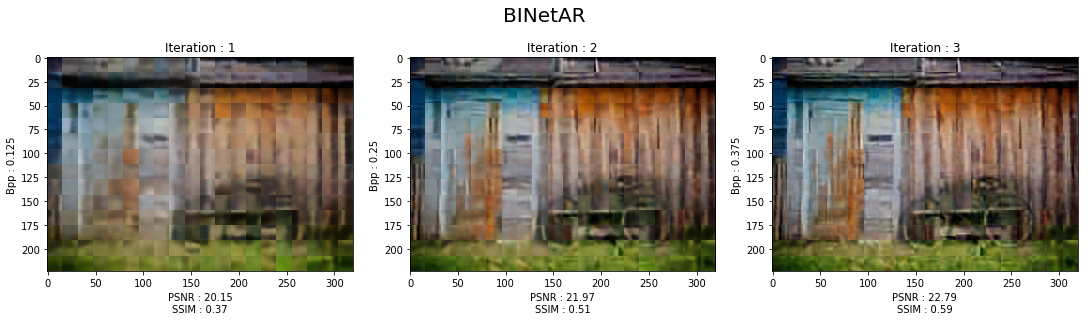

In [20]:
# Show Image 
eval_model.progressive_imshow(
    itrs=3
    # widget=True
)

**Model Evaluation on Test Data**

In [5]:
comp_ar_models = ev.CompareModels(
    models=[binet_ar, conv_ar],
    codecs=[],
    img_dir="~/Pictures/Clic/Professional"
)

**BINetAR vs ConvAR 32x32 Patch Reconstruction**

**32x32 SSIM**

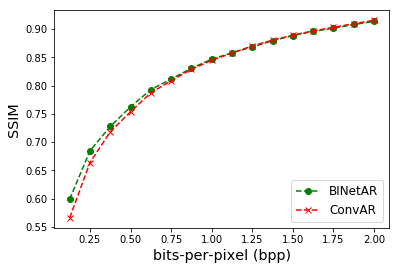

In [6]:
# Plot 32x32 SSIM 
comp_ar_models.display_compression_curve(metric="SSIM", dataset='test/32x32')

**32x32 PSNR**

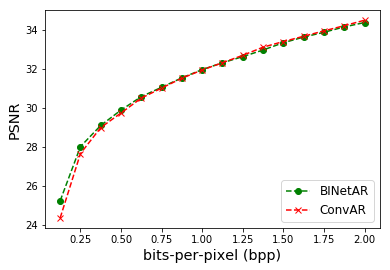

In [7]:
comp_ar_models.display_compression_curve(metric="PSNR", dataset='test/32x32')

**BINetAR vs ConvAR 224x320 Image Reconstruction**

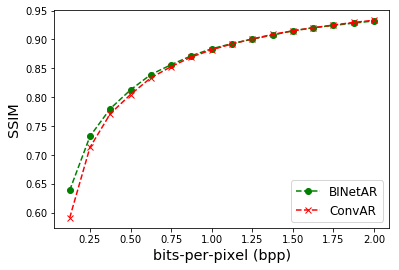

In [8]:
comp_ar_models.display_compression_curve(metric="SSIM", dataset='test')

## BINetOSR 

Binary inpainting included at first iteration of ConvGRU-OSR.

<img src="files/model_diag/binet_osr.png">

**Train Model**

In [ ]:
# train script cmd
cmd = [
    'python'      , 'train.py',
    '--sys'       , 'BINetOSR',
    '--epochs'    , '15000',
    '--learn_rate', '0.0001',
    '--gamma'     , '0.5',
    '--log'       , './logs/BINetOSR',
    '--trainDir'  , '~/Pictures/Clic/Professional',
    '--save_loc'  , './saved_models/BINetOSR',
    '--patch_size', '32',
    '--batch_size', '32',
    '--itrs'      , '16',
    '--bits'      , '128',
    '--verbose',
    '--checkpoint'
]

# run cmd
run_cmd(cmd)

**Load Model**

In [4]:
# define compression system
binet_osr = BINetOSR(
    itrs=16, 
    p_s=32, 
    b_n=128
)

# load model parameters
binet_osr.load_state_dict(
    torch.load(
        './saved_models/BINetOSR/BINetOSR.pt'
    )
)

**Model Results**

**Evaluate on Validation Data**

In [4]:
img_dir = '~/Pictures/Clic/Professional/valid'

# create an eval instance
eval_model = ev.EvaluateModel(
    img_dir, 
    binet_osr
)

**Compare 32x32 Patches**

SSIM : 0.9653467867570605
PSNR : 36.73842654406543


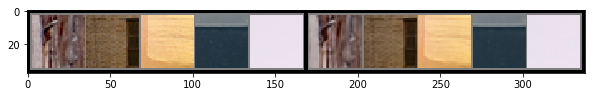

In [4]:
# comp patches
eval_model.compare_patches(itrs = 16)

**Progressive Image Compression**

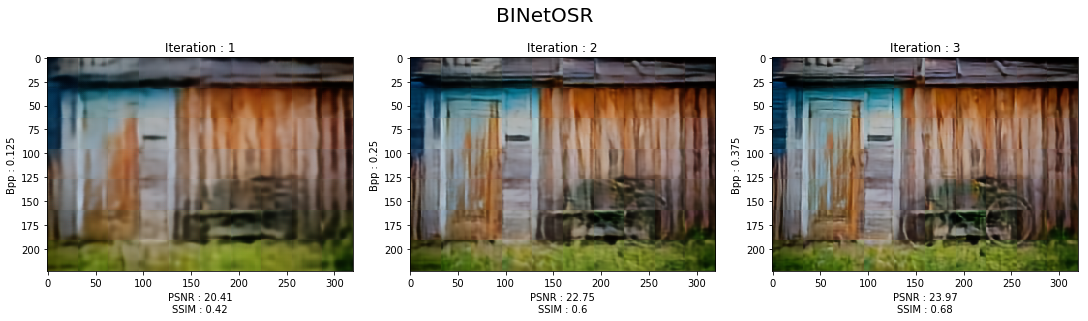

In [11]:
# Show Image 
eval_model.progressive_imshow(
    itrs=3,
    # widget=True
)

**Model Evaluation on Test Data**

In [5]:
comp_osr_models = ev.CompareModels(
    models=[binet_osr, conv_gru_osr],
    codecs=[],
    img_dir="~/Pictures/Clic/Professional"
)

**BINetOSR vs ConvGRU-OSR 32x32 Image Reconstruction**

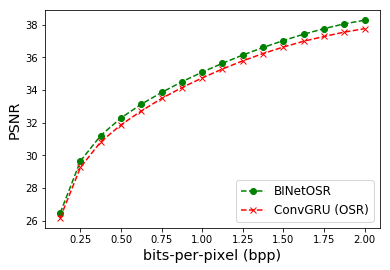

In [12]:
comp_osr_models.display_compression_curve(metric="PSNR", dataset='test/32x32')

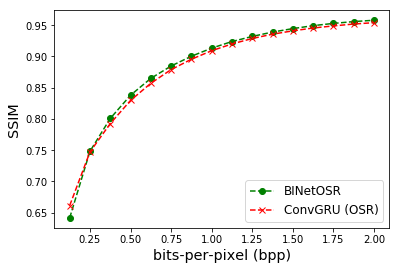

In [13]:
comp_osr_models.display_compression_curve(metric="SSIM", dataset='test/32x32')

In [25]:
comp_osr_models.display_auc(metric="PSNR", dataset="test/32x32", bpp_max=2.0, bpp_min=0.125)

Displaying AUC:

Deep Compression Models
BINetOSR : 65.10080885645905
ConvGRU (OSR) : 64.35256714838083

Standard Codecs


**BINetOSR vs ConvGRU-OSR 224x320 Image Reconstruction**

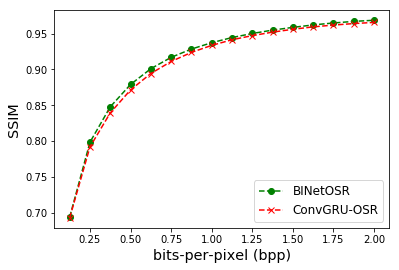

In [6]:
comp_osr_models.display_compression_curve(metric="SSIM", dataset='test')

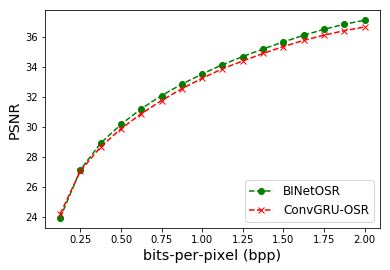

In [7]:
comp_osr_models.display_compression_curve(metric="PSNR", dataset='test')

## BINet vs Webp (Clic test dataset)

In [4]:
comp_binet_vs_webp = ev.CompareModels(
    models=[binet_osr, binet_ar],
    codecs=["WEBP", "JPEG"],
    img_dir="~/Pictures/Clic/Professional"
)

**SSIM 224x320 Image Reconstruction**

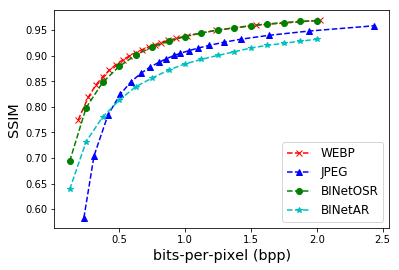

In [5]:
comp_binet_vs_webp.display_compression_curve(metric="SSIM", dataset="test")

**PSNR 224x320 Image Reconstruction**

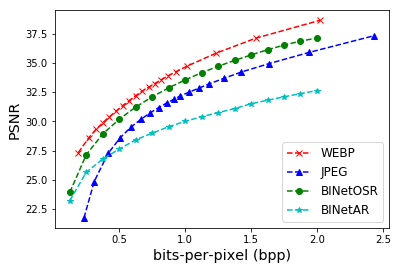

In [6]:
comp_binet_vs_webp.display_compression_curve(metric="PSNR", dataset="test")

## BINet vs. Webp (Kodak dataset)

In [5]:
comp_binet_vs_webp = ev.CompareModels(
    models=[binet_osr, binet_ar],
    codecs=["WEBP", "JPEG"],
    img_dir="~/Pictures/Clic/Professional/Kodak"
)

Creating Compression Curve File : 
Creating Compression Curve File : 


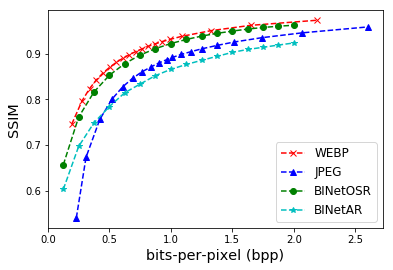

In [7]:
comp_binet_vs_webp.display_compression_curve(metric="SSIM", dataset="Kodak")

Creating Compression Curve File : 


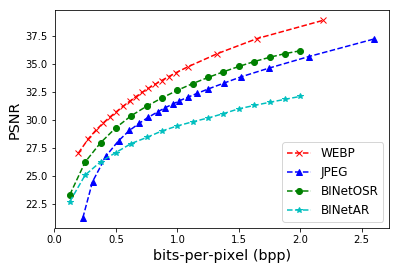

In [6]:
comp_binet_vs_webp.display_compression_curve(metric="PSNR", dataset="Kodak")

## Image Comparison (Kodak dataset)

**BINetAR vs. ConvAR vs. JPEG**

In [6]:
comp_binet_ar_vs_conv_ar_vs_jpeg = ev.CompareModels(
    models=[binet_ar, conv_ar],
    codecs=["JPEG"],
    img_dir="~/Pictures/Clic/Professional/Kodak"
)

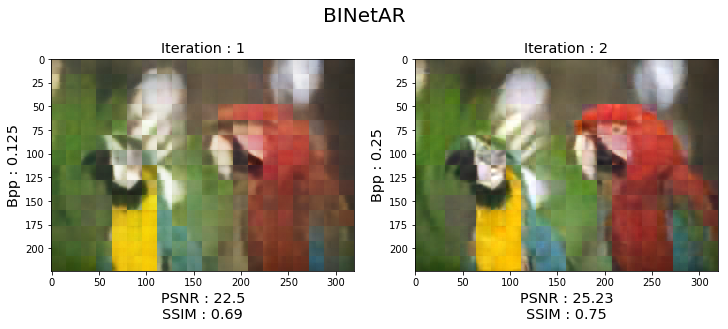

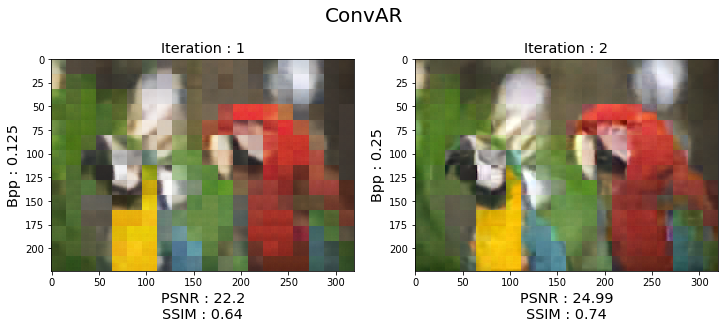

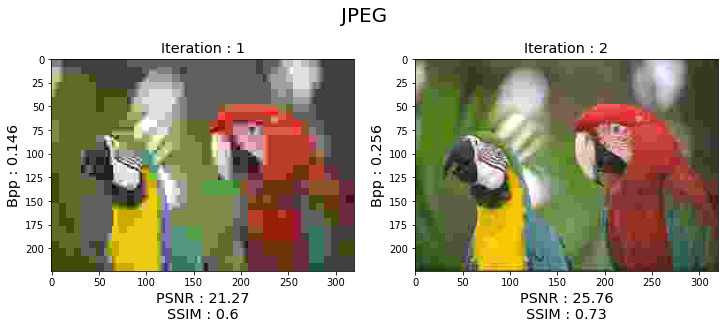

In [7]:
comp_binet_ar_vs_conv_ar_vs_jpeg.display_compressed_images(dataset="Parrot", itrs=2)

**BINetOSR vs. ConvGRU (OSR) vs. WebP**

In [8]:
comp_binet_osr_vs_conv_gru_osr_vs_webp = ev.CompareModels(
    models=[binet_osr, conv_gru_osr],
    codecs=["WEBP"],
    img_dir="~/Pictures/Clic/Professional/Kodak"
)

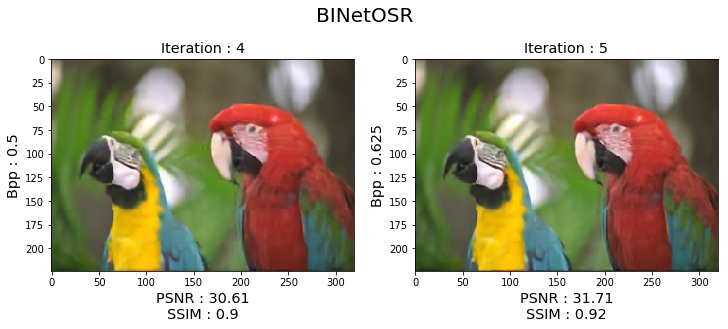

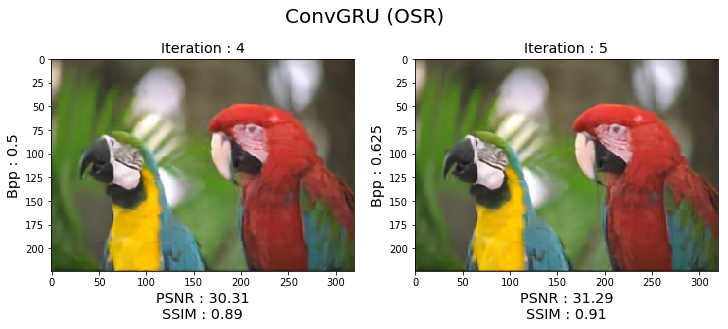

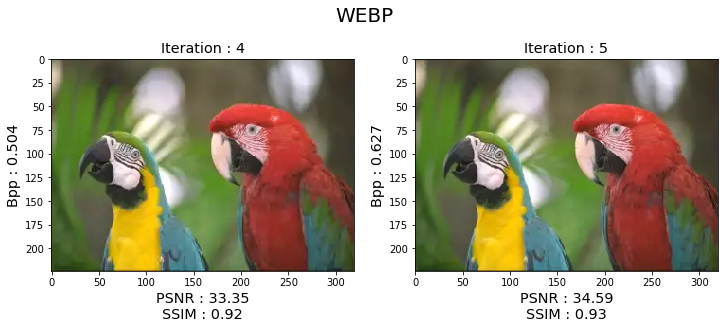

In [9]:
# Iterstion 4 -> 5 (3 is because of zero indexing)
comp_binet_osr_vs_conv_gru_osr_vs_webp.display_compressed_images(dataset="Parrot", itrs=5, start_itr=3)

## END ...